# <a id="contents"></a> Table of Contents

1. [Research Question](#research-question)
2. [Import Libraries](#imports)
3. [Standardizing Data](#standardizing-data)
4. [Loading Position Data](#loading-data)
5. [Descriptive Statistics and Visualization](#descriptive-stats)
   - 5.1 [Descriptive Statistics Calculation](#descriptive-stats-calc)
   - 5.2 [Displaying Descriptive Statistics as Heatmap](#descriptive-stats-heatmap)
6. [Distribution and Box Plot Visualization](#distribution-and-box-plot)
7. [Correlation Heatmaps](#correlation-heatmaps)
8. [Principal Component Analysis](#PCA)
   - 8.1 [Defense PCA](#defense-pca)
   - 8.2 [Midfileder PCA](#midfielder-pca)
   - 8.3 [Goalkeeper PCA](#goalkeeper-pca)
   - 8.4 [Forward PCA](#forward-pca)
9. [Baseline Models](#baseline-models)
   - 9.1 [Defense PCA and Model Baselines](#baseline-models-defense)
      - 9.1.A [Decision Tree](#baseline-models-defense-dt)
      - 9.1.B [Bagging](#baseline-models-defense-bagging)
      - 9.1.C [Linear Regression](#baseline-models-defense-logreg)
      - 9.1.D [Random Forest](#baseline-models-defense-rf)
      - 9.1.E [Gradient Boosting](#baseline-models-defense-gb)
   - 9.2 [Midfielder PCA and Model Baselines](#baseline-models-midfielder)
      - 9.2.A [Decision Tree](#baseline-models-midfielder-dt)
      - 9.2.B [Bagging](#baseline-models-midfielder-bagging)
      - 9.2.C [Linear Regression](#baseline-models-midfielder-logreg)
      - 9.1.D [Random Forest](#baseline-models-midfielder-rf)
      - 9.1.E [Gradient Boosting](#baseline-models-midfielder-gb)
   - 9.3 [Goalkeeper PCA and Model Baselines](#baseline-models-goalkeeper)
      - 9.3.A [Decision Tree](#baseline-models-goalkeeper-dt)
      - 9.3.B [Bagging](#baseline-models-goalkeeper-bagging)
      - 9.3.C [Linear Regression](#baseline-models-goalkeeper-logreg)
      - 9.1.D [Random Forest](#baseline-models-goalkeeper-rf)
      - 9.1.E [Gradient Boosting](#baseline-models-goalkeeper-gb)
   - 9.4 [Forward PCA and Model Baselines](#baseline-models-forward)
      - 9.4.A [Decision Tree](#baseline-models-forward-dt)
      - 9.4.B [Bagging](#baseline-models-forward-bagging)
      - 9.4.C [Linear Regression](#baseline-models-forward-logreg)
      - 9.1.D [Random Forest](#baseline-models-forward-rf)
      - 9.1.E [Gradient Boosting](#baseline-models-forward-gb)


<a id="research-question"></a>

## <div class='section'>Section 1: Research Question</div>


Our main research question is: How can players' skills across different positions in the top five European soccer leagues, derived from performance metrics, be used to predict their salaries? For our final project, we utilized data scraped from FBref.com to perform a Principal Component Analysis to explore similarities across top players and their respective positions.

<a id="imports"></a>

## <div class='section'>Section 2: Import Libraries</div>


In [1]:
import itertools
import math
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, \
                            roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, cross_val_predict, \
                        GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer



# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

<a id="standardizing-data"></a>

## <div class='section'>Section 3: Standardizing and Preprocessing Data</div>

[Return to contents](#contents)

Here, we define a `standardize` function that will be used to scale and standardize the data to ensure that each feature contributes equally to any subsequent analysis so that we can avoid biases due to differences in scale. Since our project involves the use of PCA, it is essential to standardize the data to ensure that each predictor contributes equally and without bias to the principal components.

In [2]:
# scaler = StandardScaler()
# def standardize(df):
    
#     if 'Player' in df.columns:
#         player_column = df['Player']

#     if 'Squad' in df.columns:
#         squad_column = df['Squad']

#     if 'Comp' in df.columns:
#         comp_column = df['Comp']

#     if 'Market Value (Euros)' in df.columns:
#         mv_column = df['Market Value (Euros)']

    
        
#     numeric_columns = df.select_dtypes(include='number').columns
#     standardized_data = scaler.fit_transform(df[numeric_columns])

#     standardized_df = pd.DataFrame(standardized_data, columns=numeric_columns)
#     standardized_df['Player'] = player_column.reset_index(drop=True)
#     standardized_df['Comp'] = comp_column.reset_index(drop=True)
#     standardized_df['Squad'] = squad_column.reset_index(drop=True)
#     standardized_df['Market Value (Euros)'] = mv_column.reset_index(drop=True)
    
#     return standardized_df


<a id="loading-data"></a>

## <div class='section'>Section 4: Loading Position Data</div>

[Return to contents](#contents)

Here, we load and `standardize` data from CSV files for each position, then organize them in a dictionary. To improve our analysis, we seperated our data into four datasets based on the four different player positions. This distinction is important since the relevant player statistics for different positions (e.g. outfielder vs. goalkeeper) are very different, and would therefore distort our PCA if left combined. Additionally, we rename the predictors to ease interpretability within our notebook.

In [3]:
# Make dataframes
goalkeepers = pd.read_csv("stats/GK_relevant_stats.csv")
defenders = pd.read_csv("stats/DF_relevant_stats.csv")
midfielders = pd.read_csv("stats/MF_relevant_stats.csv")
forwards = pd.read_csv("stats/FW_relevant_stats.csv")
# salaries = pd.read_csv('stats/salaries.csv')
market_values = pd.read_csv('stats/market_values.csv')


# Dictionary of dataframes for each position
dataframes = {
    'Goalkeepers': goalkeepers, 
    'Defenders': defenders, 
    'Midfielders': midfielders, 
    'Forwards': forwards
}

column_mapping = {
    'MP': 'Matches Played',
    'Starts': 'Starts',
    'Min': 'Minutes Played',
    '90s': '90-Minute Increments',
    'Gls': 'Goals',
    'Ast': 'Assists',
    'G+A': 'Goals + Assists',
    'G-PK': 'Goals (Excl. Penalties)',
    'PK': 'Penalty Goals',
    'PKatt': 'Penalty Attempts',
    'CrdY': 'Yellow Cards',
    'CrdR': 'Red Cards',
    'xG': 'Expected Goals',
    'npxG': 'Non-Penalty Expected Goals',
    'xAG': 'Expected Assists',
    'npxG+xAG': 'Expected Non-Penalty Goals + Assists',
    'PrgC': 'Progressive Carries',
    'PrgP': 'Progressive Passes',
    'PrgR': 'Progressive Runs',
    'Glsp90': 'Goals per 90',
    'Astp90': 'Assists per 90',
    'G+Ap90': 'Goals + Assists per 90',
    'xGp90': 'Expected Goals per 90',
    'xAGp90': 'Expected Assists per 90',
    'xG+xAGp90': 'Expected Goals + Assists per 90',
    'npxGp90': 'Non-Penalty Goals per 90',
    'npxG+xAGp90': 'Non-Penalty Goals + Assists per 90',
    'Sh': 'Shots',
    'SoT': 'Shots on Target',
    'SoT%': 'Shots on Target %',
    'Sh/90': 'Shots per 90',
    'SoT/90': 'Shots on Target per 90',
    'ShDist': 'Average Shot Distance',
    'npxG/Sh': 'Non-Penalty xG per Shot',
    'G-xG': 'Goals Minus xG',
    'Cmp': 'Passes Completed',
    'Att': 'Passes Attempted',
    'Cmp%': 'Pass Completion %',
    'PTotDist': 'Total Passing Distance',
    'PPrgDist': 'Progressive Passing Distance',
    'A-xAG': 'Assists Minus xAG',
    'KP': 'Key Passes',
    '1/3': 'Passes into Final Third',
    'PPA': 'Passes into Penalty Area',
    'Tkl': 'Tackles',
    'TklW': 'Tackles Won',
    'DTkl': 'Dribbles Tackled',
    'DTklAtt': 'Dribbles Tackled Attempts',
    'Tkl%': 'Tackle Success %',
    'Blocks': 'Blocks',
    'Int': 'Interceptions',
    'Clr': 'Clearances',
    'Touches': 'Touches',
    'Def Pen': 'Touches in Defensive Penalty Area',
    'Def 3rd': 'Touches in Defensive Third',
    'Mid 3rd': 'Touches in Midfield Third',
    'Att 3rd': 'Touches in Attacking Third',
    'Att Pen': 'Touches in Attacking Penalty Area',
    'TOAtt': 'Take-On Attempts',
    'TOSucc': 'Take-On Successes',
    'TOSucc%': 'Take-On Success %',
    'Tkld': 'Tackled',
    'Tkld%': 'Tackled %',
    'Carries': 'Carries',
    'CTotDist': 'Total Carry Distance',
    'CPrgDist': 'Progressive Carry Distance',
    'C1/3': 'Carries into Final Third',
    'CPA': 'Carries into Penalty Area',
    'Rec': 'Passes Received',
    'GA': 'Goals Allowed',
    'GA90': 'Goals Allowed per 90 Minutes',
    'SoTA': 'Shots on Target Against',
    'Saves': 'Saves Made',
    'Save%': 'Save Percentage',
    'CS': 'Clean Sheets',
    'CS%': 'Clean Sheet Percentage',
    'PSxG': 'Post-Shot Expected Goals',
    'PSxG/SoT': 'Post-Shot Expected Goals per Shot on Target',
    'PSxG+/-': 'Post-Shot Expected Goals Difference',
    'Opp': 'Opponent Shots',
    'Stp': 'Crosses Stopped',
    'Stp%': 'Crosses Stopped Percentage'
}

defenders.rename(columns=column_mapping, inplace=True)
goalkeepers.rename(columns=column_mapping, inplace=True)
midfielders.rename(columns=column_mapping, inplace=True)
forwards.rename(columns=column_mapping, inplace=True)

defenders = pd.merge(defenders, market_values, on='Player', how='inner')
midfielders = pd.merge(midfielders, market_values, on='Player', how='inner')
goalkeepers = pd.merge(goalkeepers, market_values, on='Player', how='inner')
forwards = pd.merge(forwards, market_values, on='Player', how='inner')

for position, df in dataframes.items():
    dataframes[position] = df.drop_duplicates(subset='Player', keep='first').reset_index(drop=True)


x_defenders = defenders.select_dtypes(include=[np.number]).drop(columns=['Market Value (Euros)'])
imputation = SimpleImputer(strategy='mean')
defenders_imputed = imputation.fit_transform(x_defenders)
scaler = StandardScaler()
x_defenders = scaler.fit_transform(defenders_imputed)
y_defenders = np.log1p(defenders['Market Value (Euros)'])


x_midfielders = midfielders.select_dtypes(include=[np.number]).drop(columns=['Market Value (Euros)'])
imputation = SimpleImputer(strategy='mean')
midfielders_imputed = imputation.fit_transform(x_midfielders)
scaler = StandardScaler()
x_midfielders = scaler.fit_transform(midfielders_imputed)
y_midfielders = np.log1p(midfielders['Market Value (Euros)'])


x_goalkeepers = goalkeepers.select_dtypes(include=[np.number]).drop(columns=['Market Value (Euros)'])
imputation = SimpleImputer(strategy='mean')
goalkeepers_imputed = imputation.fit_transform(x_goalkeepers)
scaler = StandardScaler()
x_goalkeepers = scaler.fit_transform(goalkeepers_imputed)
y_goalkeepers = np.log1p(goalkeepers['Market Value (Euros)'])


x_forwards = forwards.select_dtypes(include=[np.number]).drop(columns=['Market Value (Euros)'])
imputation = SimpleImputer(strategy='mean')
forwards_imputed = imputation.fit_transform(x_forwards)
scaler = StandardScaler()
x_forwards = scaler.fit_transform(forwards_imputed)
y_forwards = np.log1p(forwards['Market Value (Euros)'])


dataframes = {
    'Goalkeepers': goalkeepers, 
    'Defenders': defenders, 
    'Midfielders': midfielders, 
    'Forwards': forwards
}


In [4]:
forwards

Player Nation    Pos         Squad            Comp  Age  Born  \
0         Aaron Seydel    GER     FW  Darmstadt 98      Bundesliga   27  1996   
1      Abde Ezzalzouli    MAR  FW,MF     Barcelona         La Liga   21  2001   
2      Abde Ezzalzouli    MAR  FW,MF     Barcelona         La Liga   21  2001   
3      Abde Ezzalzouli    MAR     FW         Betis         La Liga   21  2001   
4      Abde Ezzalzouli    MAR     FW         Betis         La Liga   21  2001   
..                 ...    ...    ...           ...             ...  ...   ...   
656  Youssef En-Nesyri    MAR     FW       Sevilla         La Liga   26  1997   
657  Youssoufa Moukoko    GER     FW      Dortmund      Bundesliga   18  2004   
658     Yussuf Poulsen    DEN     FW    RB Leipzig      Bundesliga   29  1994   
659       Zeki Amdouni    SUI     FW       Burnley  Premier League   22  2000   
660       Zito Luvumbo    ANG  FW,MF      Cagliari         Serie A   21  2002   

     Matches Played  Starts  Minutes Played  90-Minute Increments  Goals  \
0                16       5             619                   6.9      1   
1                 2       0              68                   0.8      0   
2                 2       0              68                   0.8      0   
3                26       6             865                   9.6      1   
4                26       6             865                   9.6      1   
..              ...     ...             ...                   ...    ...   
656              33      28            2570                  28.6     16   
657              20       4             625                   6.9      5   
658              28      12            1217                  13.5      5   
659              34      27            1953                  21.7      5   
660              30      19            1946                  21.6      4   

     Assists  Goals + Assists  Goals (Excl. Penalties)  Penalty Goals  \
0          0                1                        1              0   
1          0                0                        0              0   
2          0                0                        0              0   
3          0                1                        1              0   
4          0                1                        1              0   
..       ...              ...                      ...            ...   
656        2               18                       15              1   
657        0                5                        5              0   
658        2                7                        5              0   
659        1                6                        4              1   
660        5                9                        4              0   

     Penalty Attempts  Yellow Cards  Red Cards  Expected Goals  \
0                   0             1          0             1.0   
1                   0             0          0             0.2   
2                   0             0          0             0.2   
3                   1             1          0             3.0   
4                   1             1          0             3.0   
..                ...           ...        ...             ...   
656                 1             4          0            10.8   
657                 0             1          0             3.9   
658                 0             0          0             5.7   
659                 1             2          0             5.8   
660                 0             5          0             4.0   

     Non-Penalty Expected Goals  Expected Assists  \
0                           1.0               0.7   
1                           0.2               0.1   
2                           0.2               0.1   
3                           2.2               0.3   
4                           2.2               0.3   
..                          ...               ...   
656                        10.0               1.3   
657                         3.9     

<a id="descriptive-stats"></a>

## <div class='section'>Section 5: Descriptive Statistics and Visualization</div>

[Return to contents](#contents)

Here, we calculate and visualize descriptive statistics for each position dataset which will provide insights into the central tendency, spread, and range of values for each feature in the dataset.


<a id="descriptive-stats-calc"></a>

#### <div class='sub-section'>5.1: Descriptive Statistics Calculation</div>

Here, we calculate the mean, standard deviation, median, min, max, and range of each numeric feature in the dataset.




In [5]:
def descriptive_stats(df):
    numeric_df = df.select_dtypes(include='number')
    stats = numeric_df.describe().T  # Transpose for readability
    stats['median'] = numeric_df.median()  # Add median
    stats['range'] = stats['max'] - stats['min']  # Calculate range
    return stats[['mean', 'std', 'median', 'min', 'max', 'range']]

<a id="descriptive-stats-heatmap"></a>

#### <div class='sub-section'>5.2: Displaying Descriptive Statistics as Heatmap</div>

Here, we create heatmaps to visualize the descriptive statistics for each feature and to help us easily spot outliers, patterns, and distributions across different features.

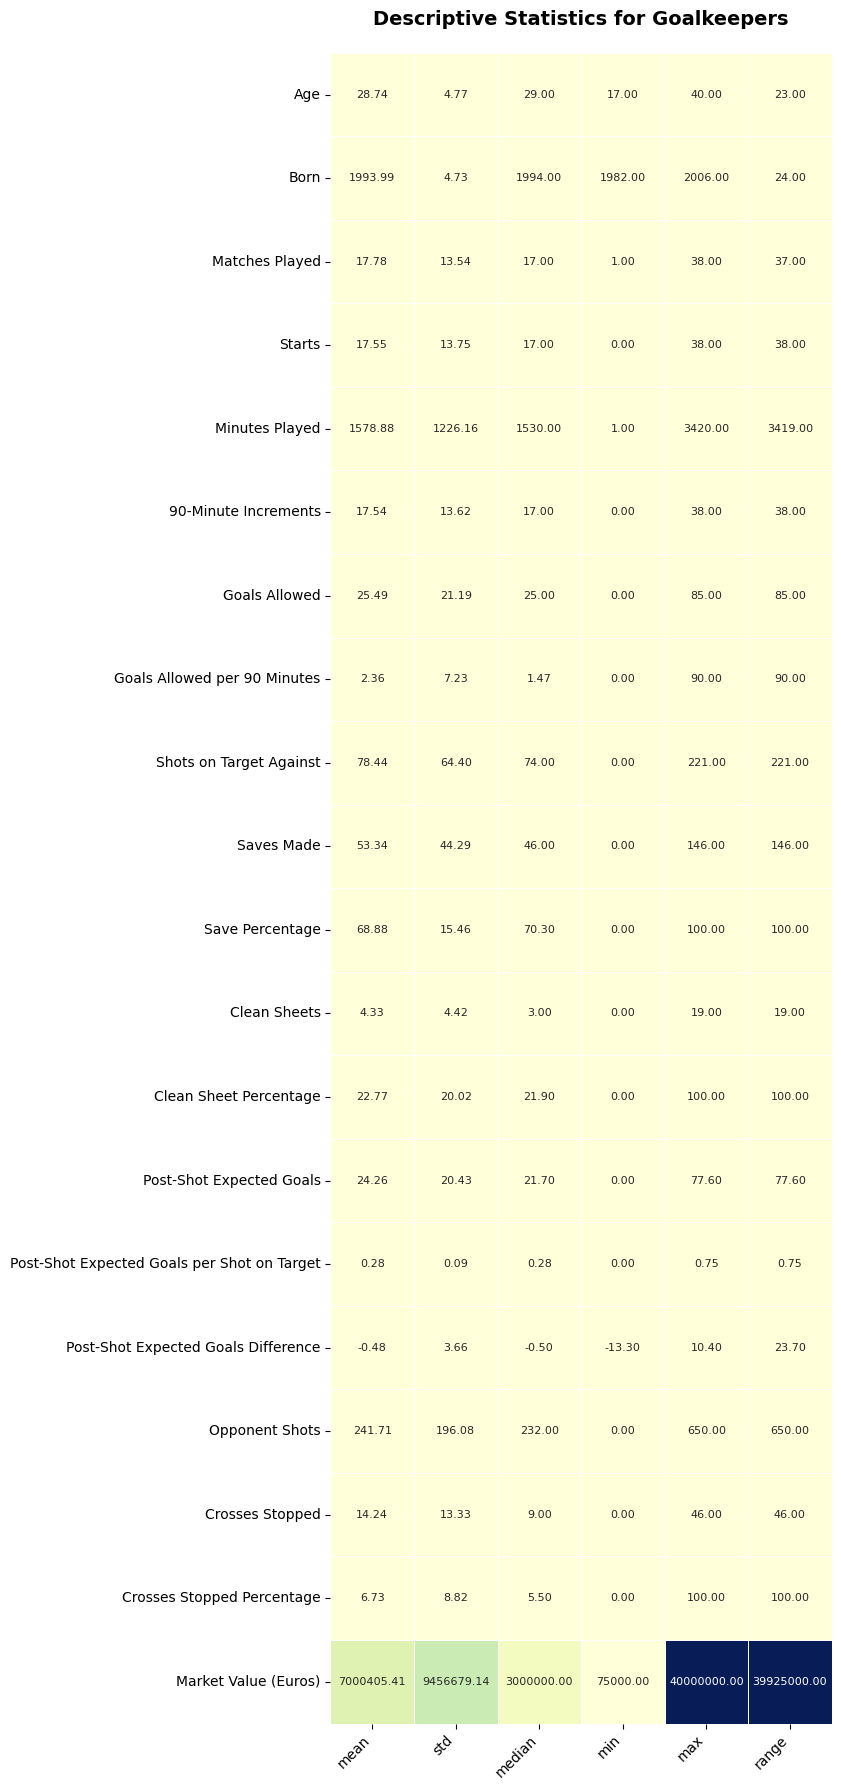

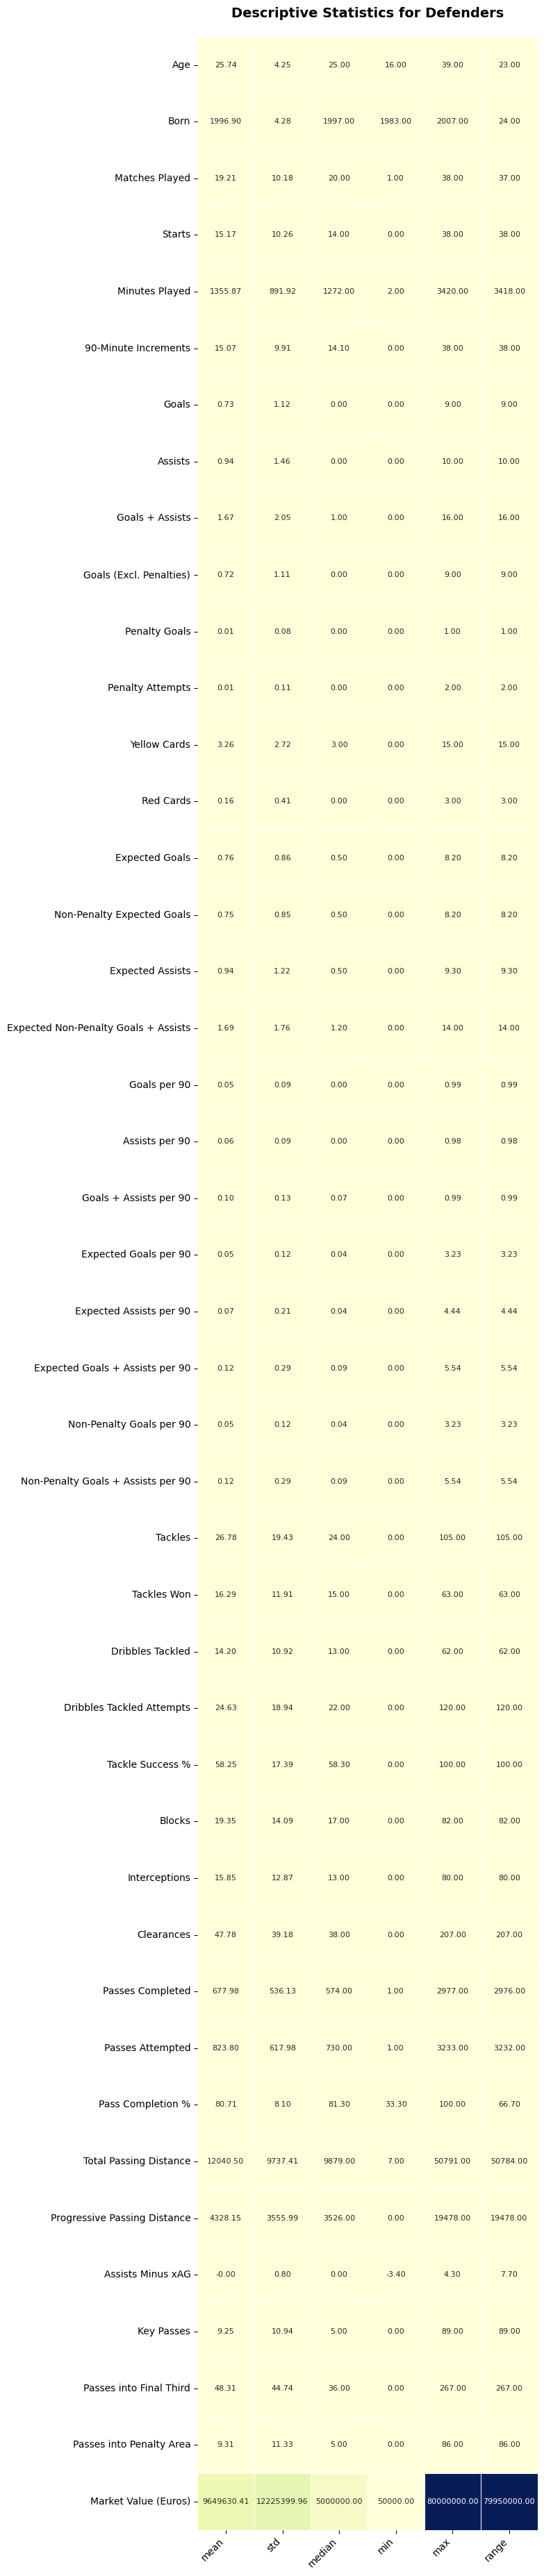

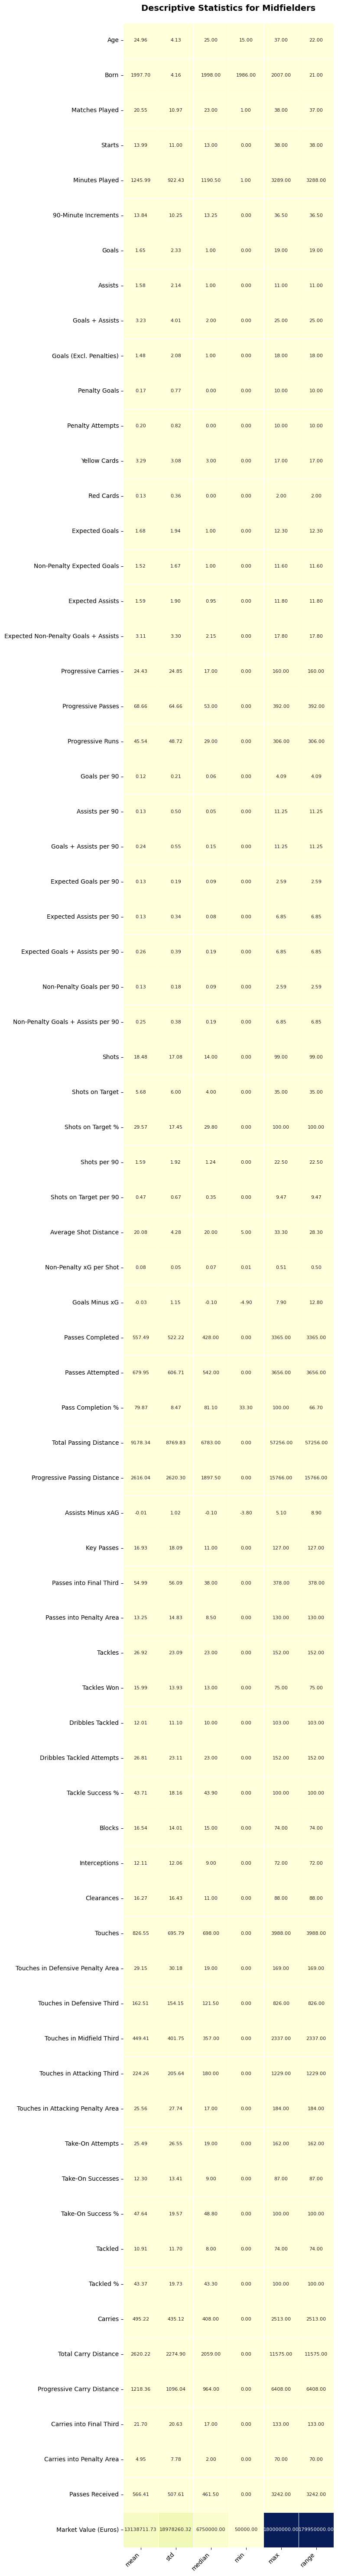

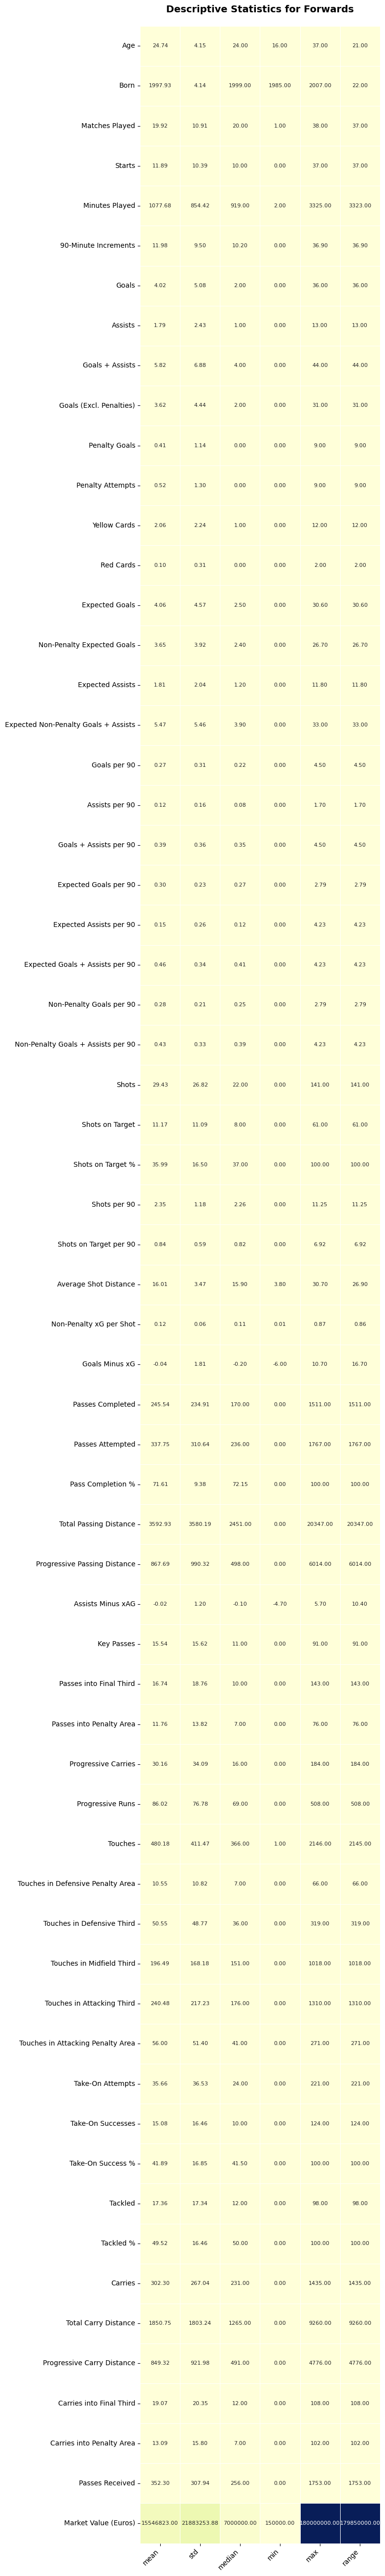

In [6]:
def display_heatmap(stats, title):
    fig, ax = plt.subplots(figsize=(12, len(stats) * 0.8 + 2))
    sns.heatmap(stats, annot=True, fmt=".2f", cmap="YlGnBu", cbar=False, linewidths=.5, 
                annot_kws={"size": 8}, ax=ax, square=True)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.title(title, fontweight="bold", fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()


# generating and displaying heatmap tables for each position's statistics
for position, df in dataframes.items():
    stats = descriptive_stats(df)
    display_heatmap(stats, f"Descriptive Statistics for {position}")

<a id="distribution-and-box-plot-visualization"></a>

## <div class='section'>Section 6: Distribution and Box Plot Visualization</div>

[Return to contents](#contents)

Here, we generate histograms and box plots for each feature to show the distribution and identify potential outliers. The histograms provide insight into how data points are distributed while box plots reveal central tendencies and variability. The histograms and box plots are then saved as PNG files in the 'plots' folder


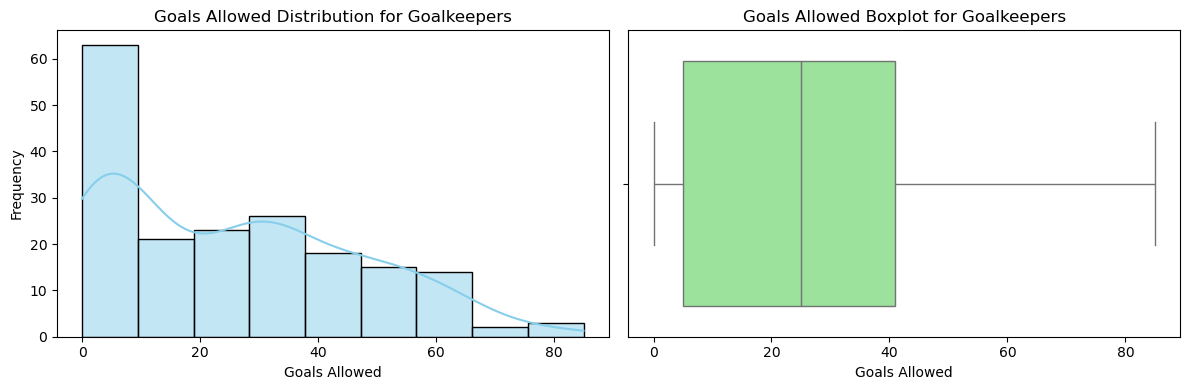

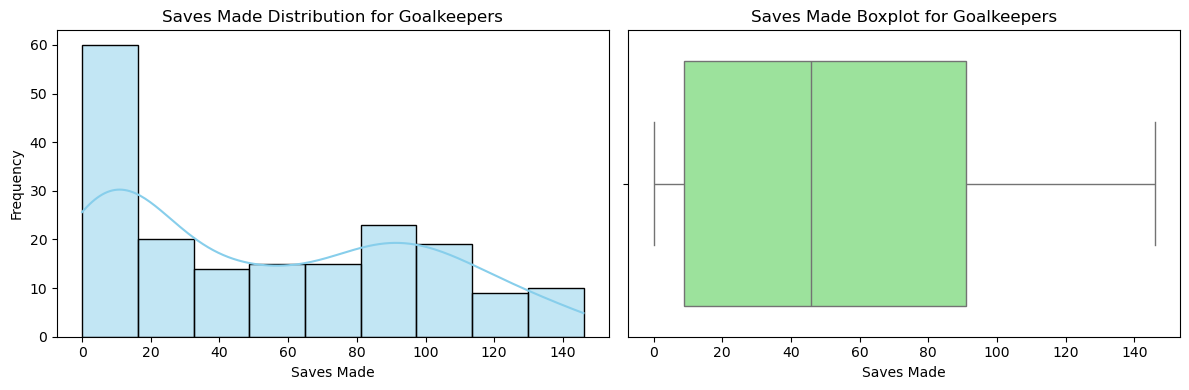

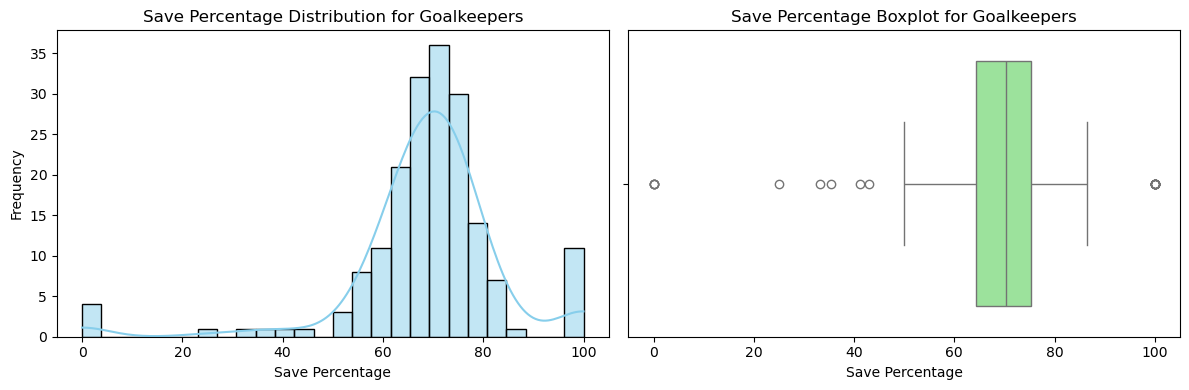

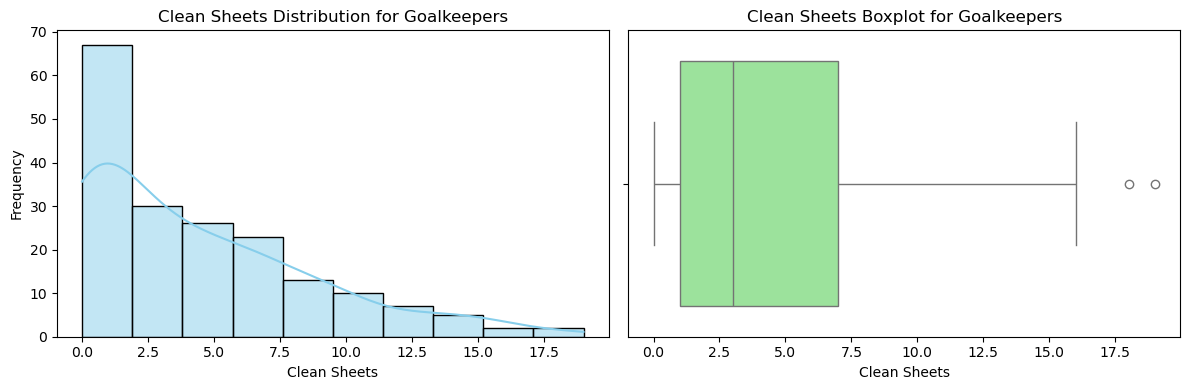

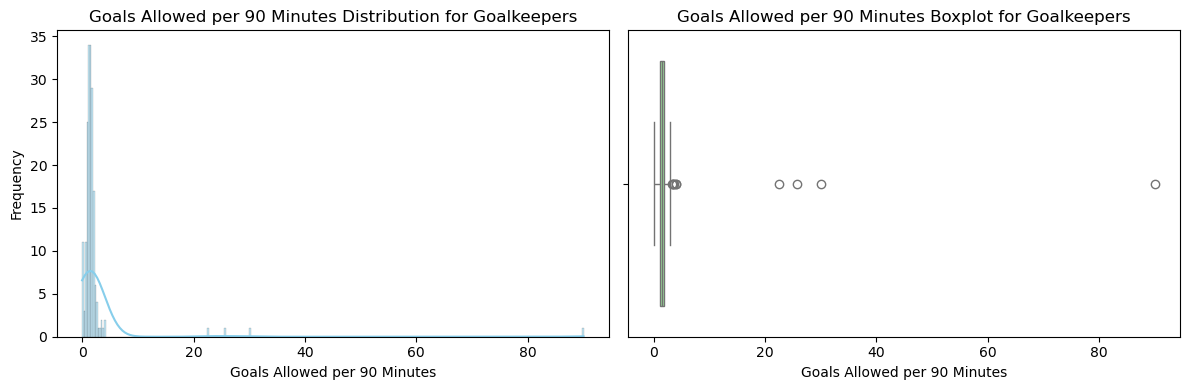

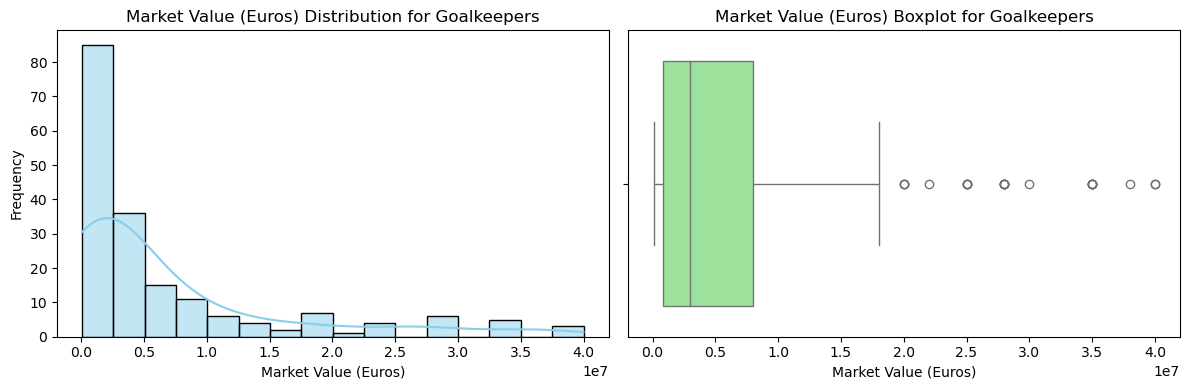

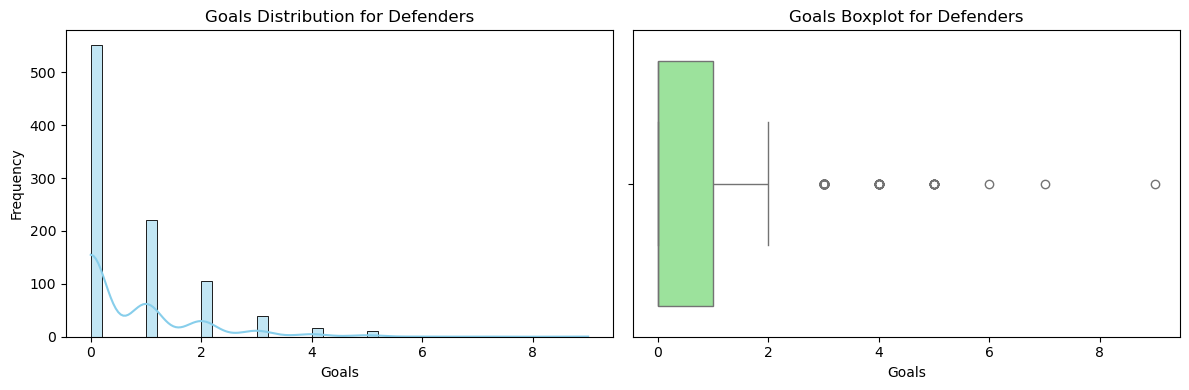

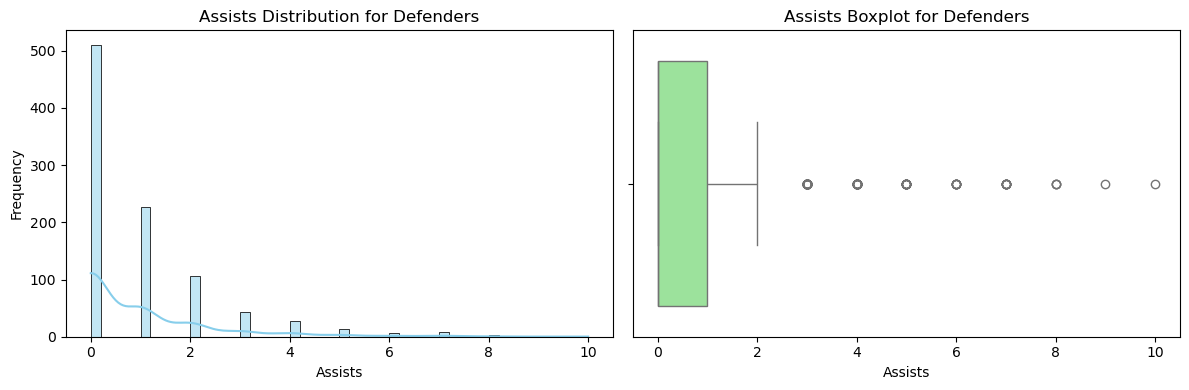

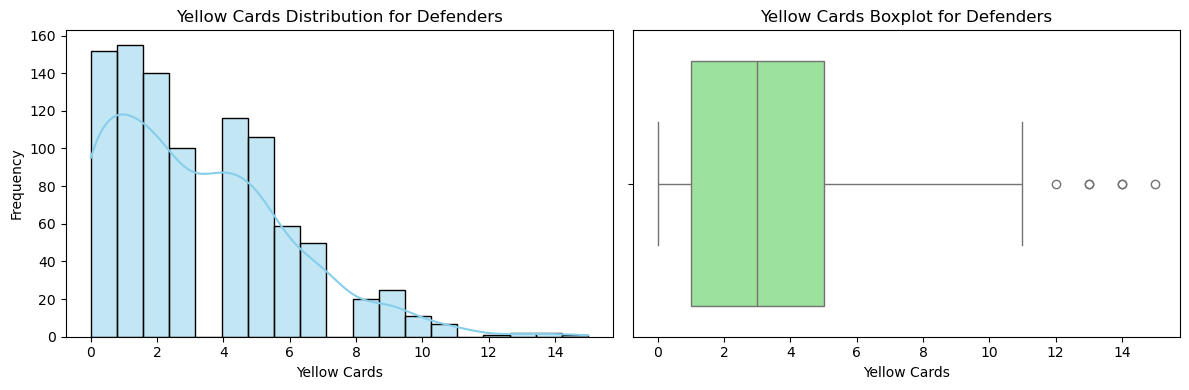

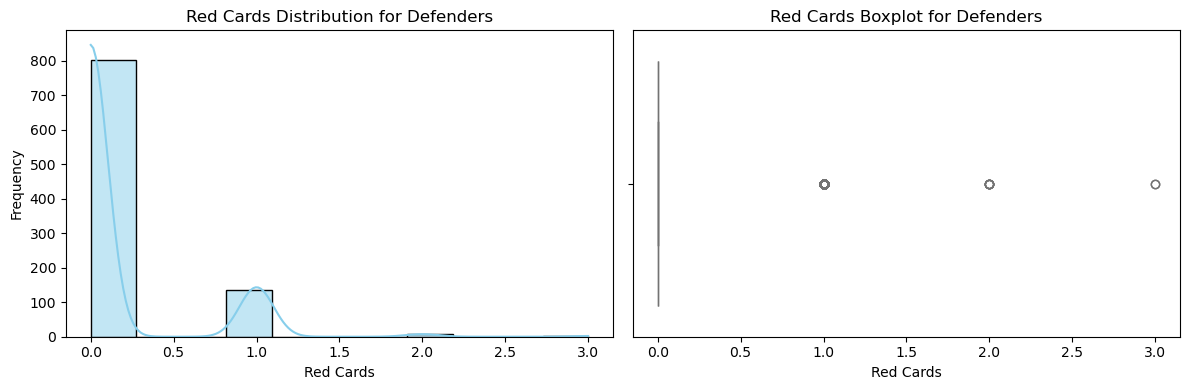

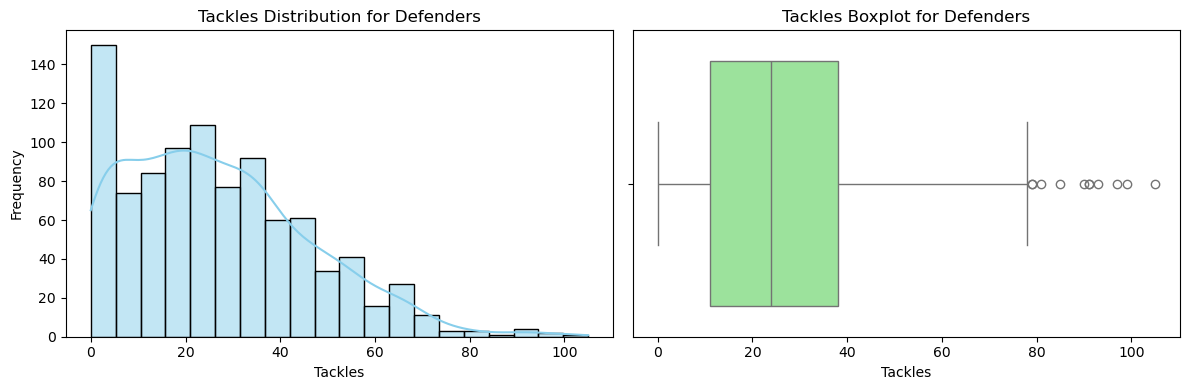

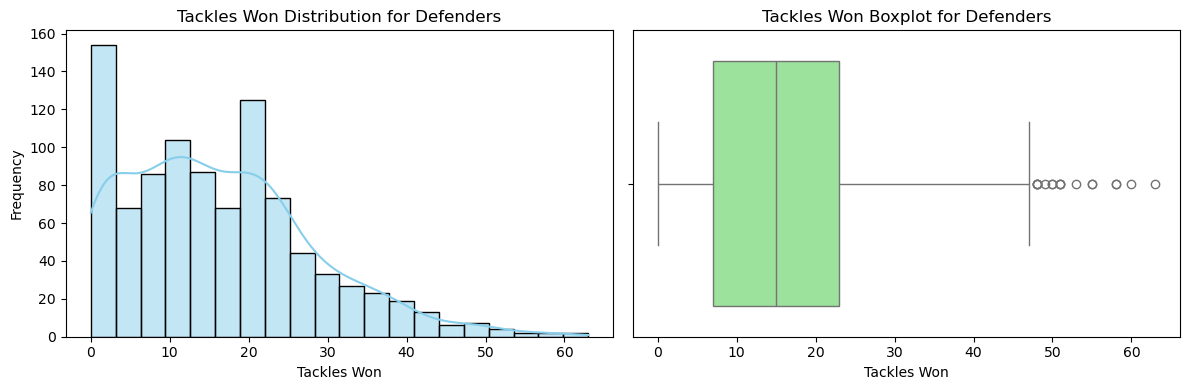

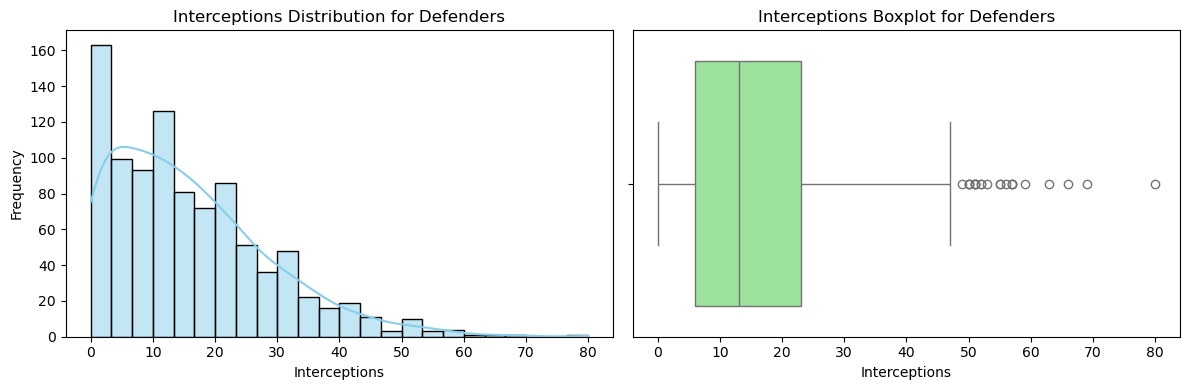

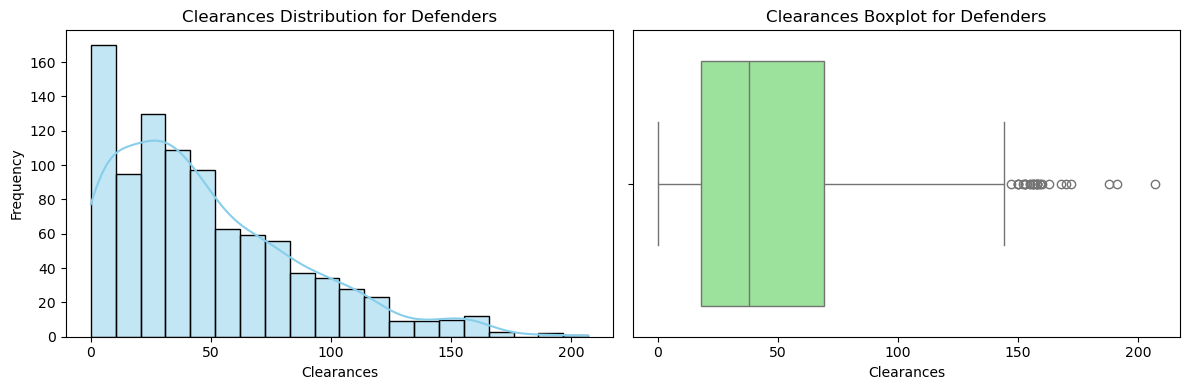

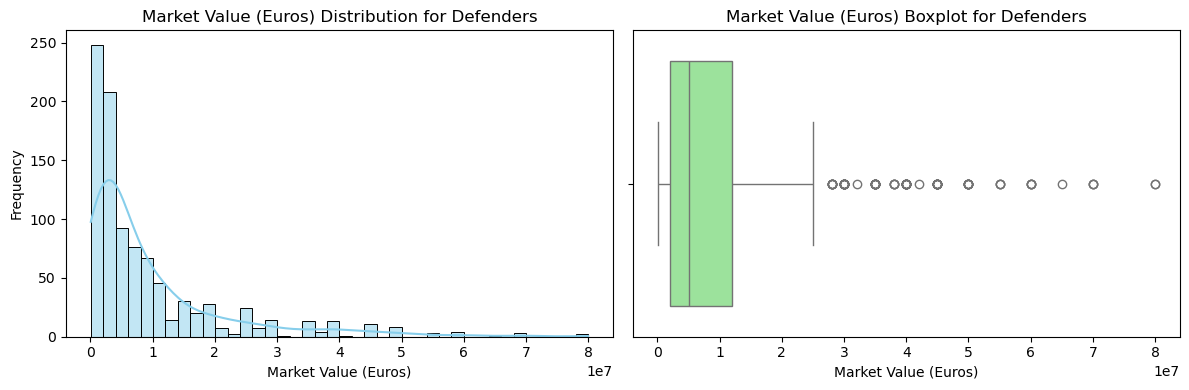

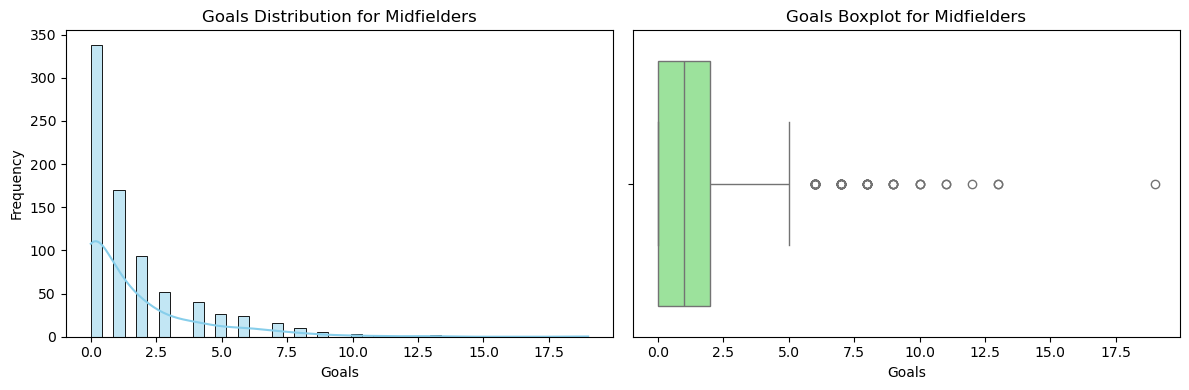

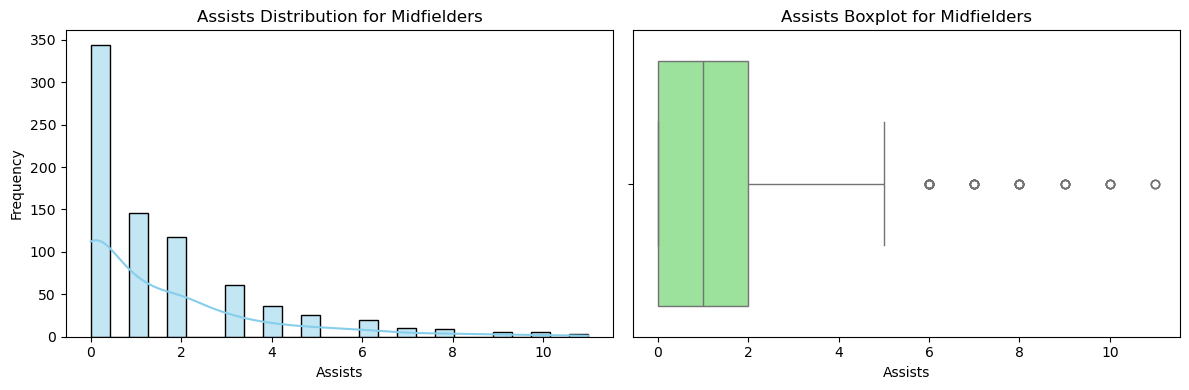

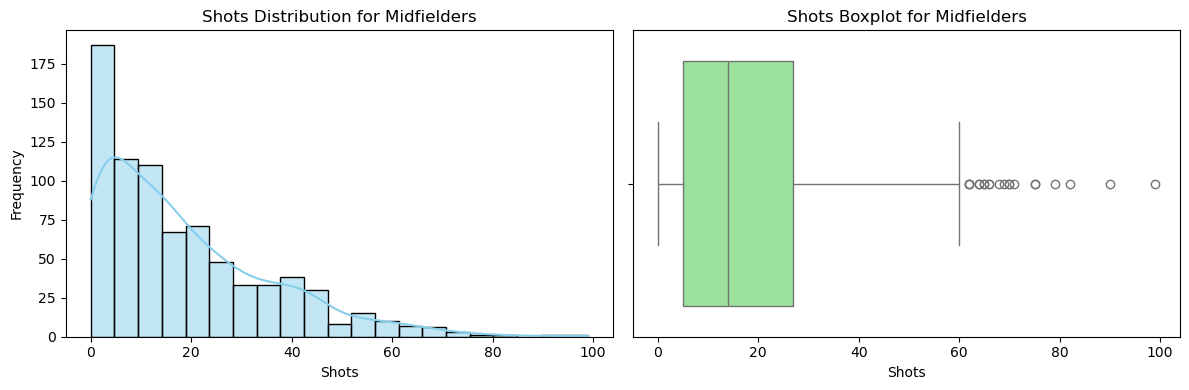

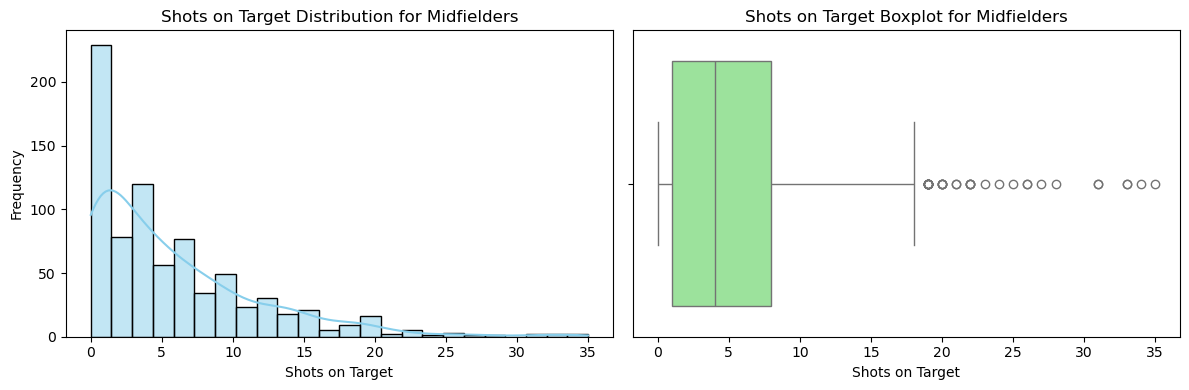

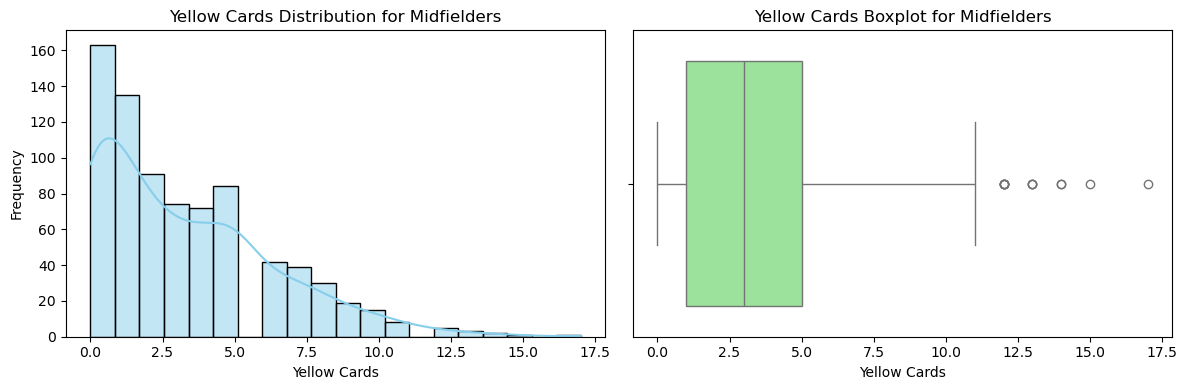

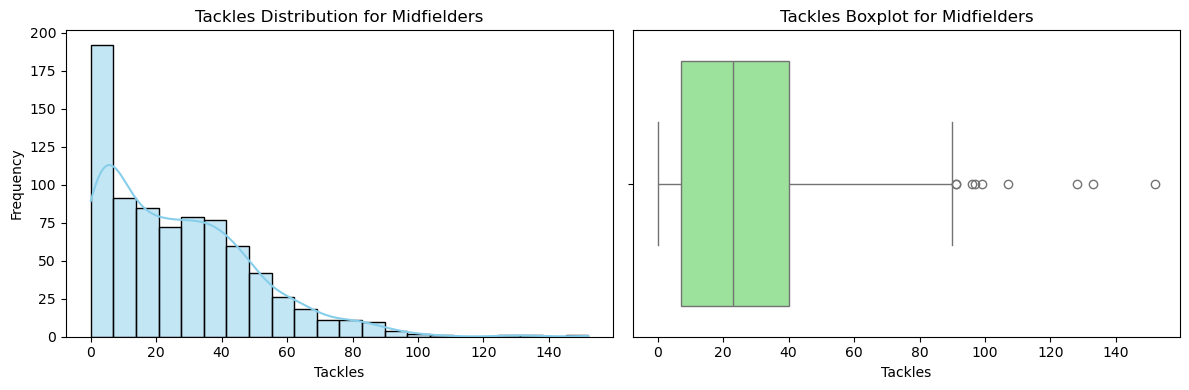

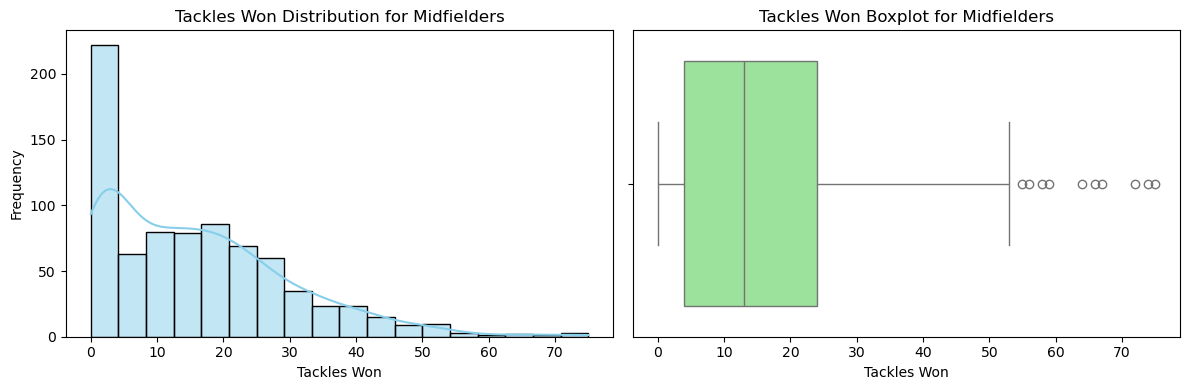

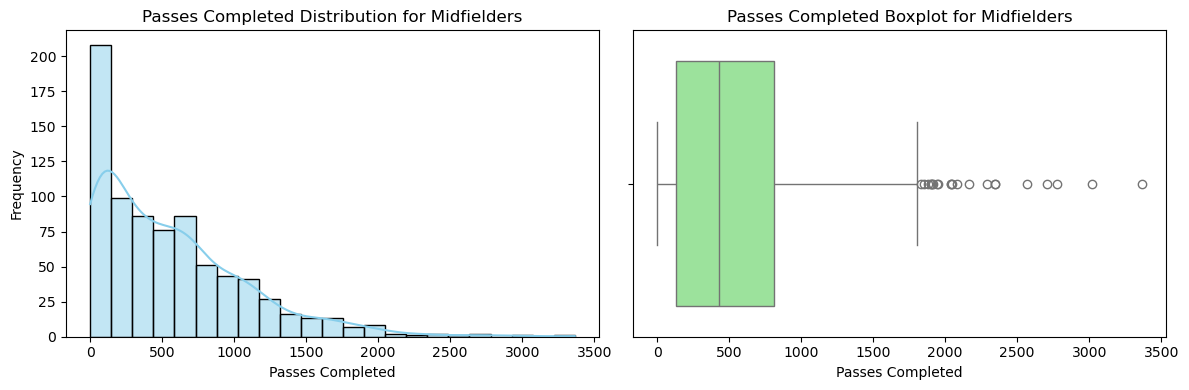

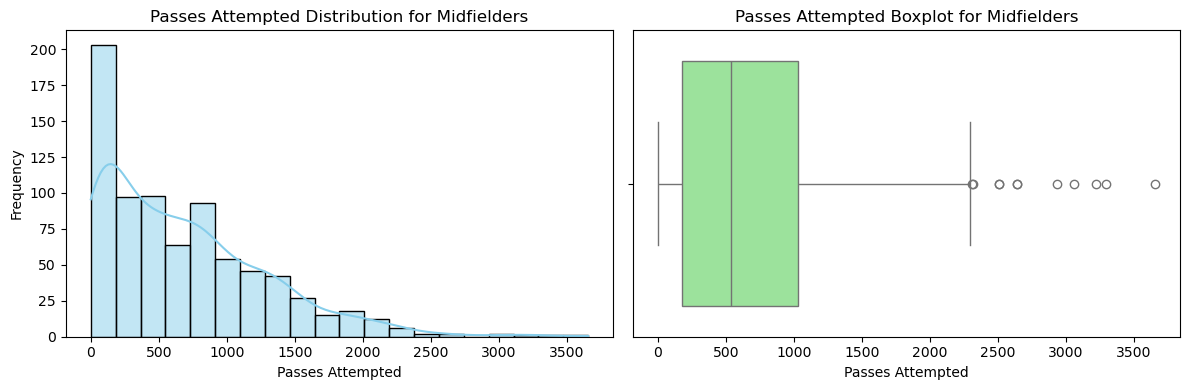

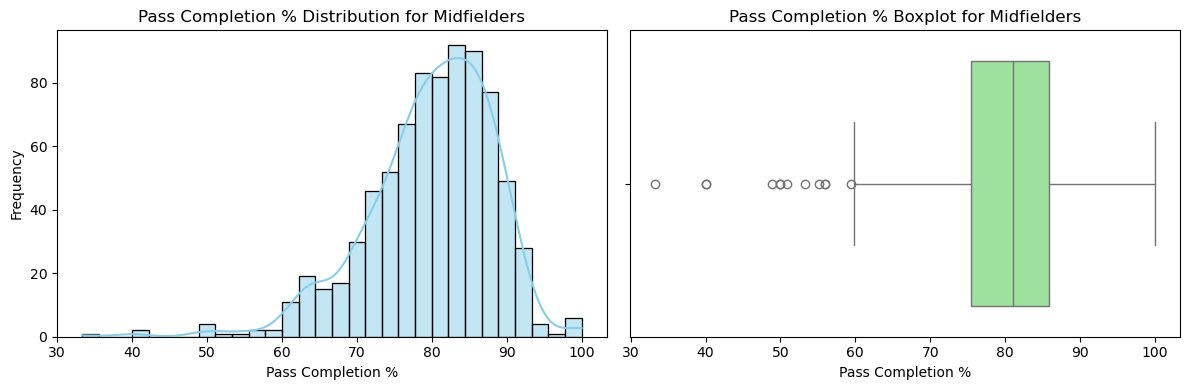

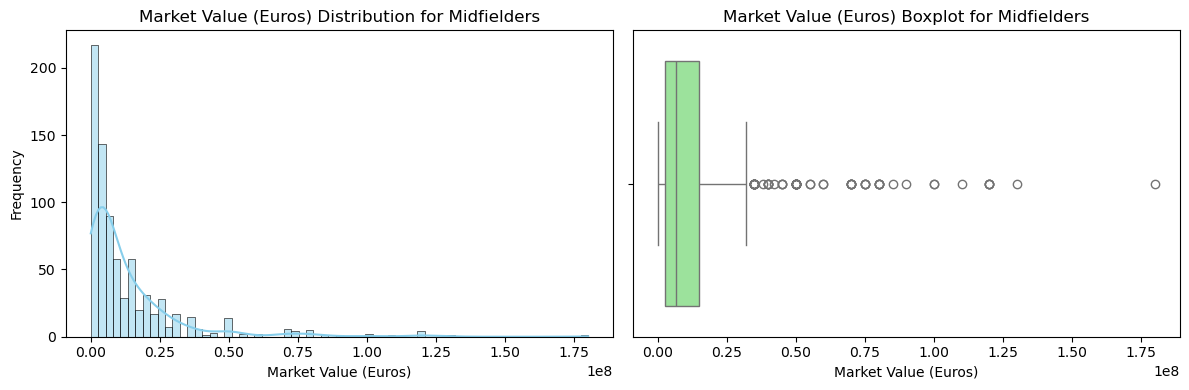

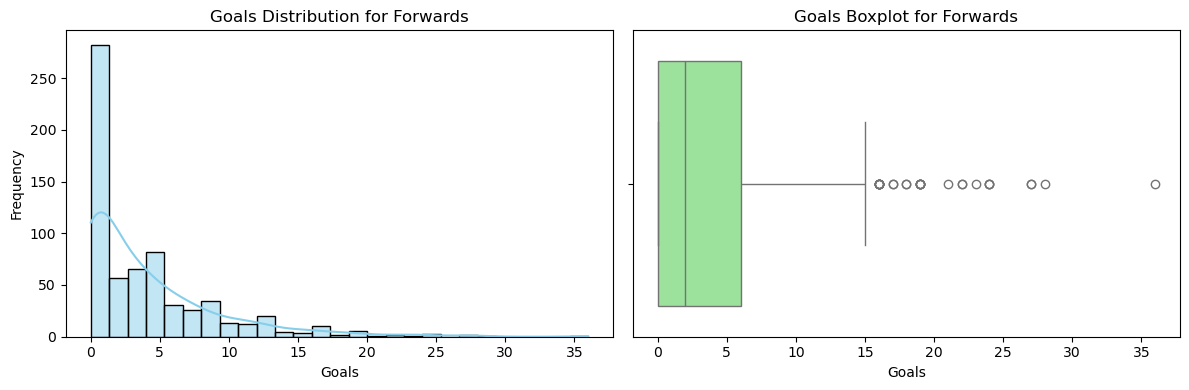

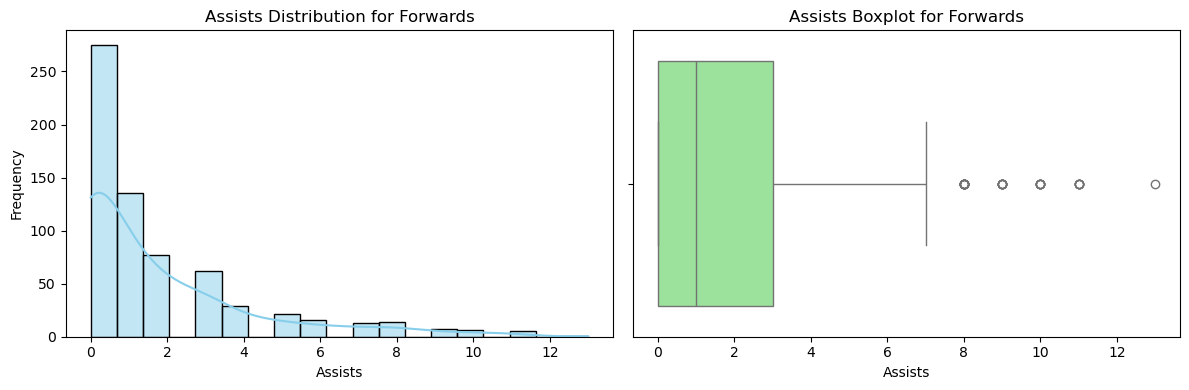

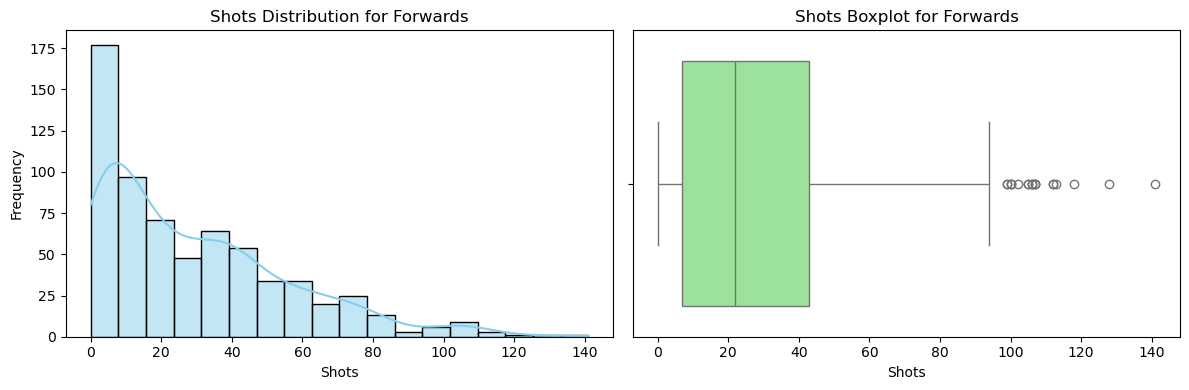

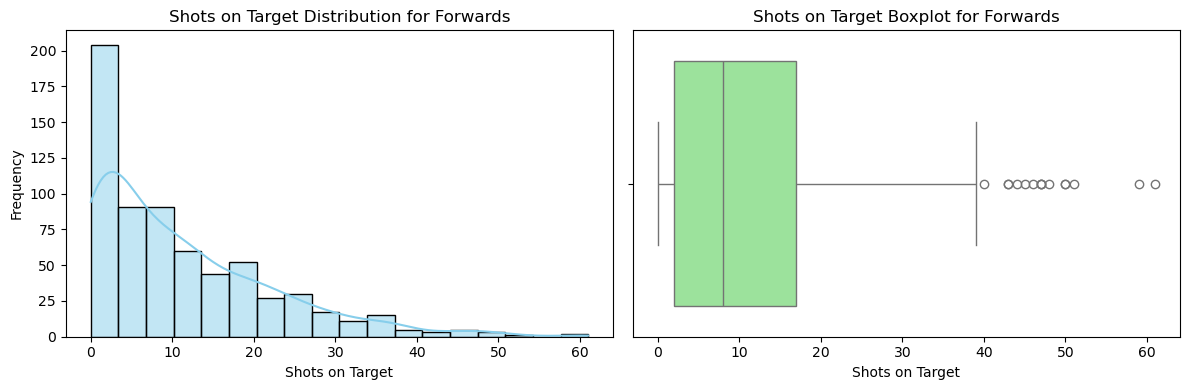

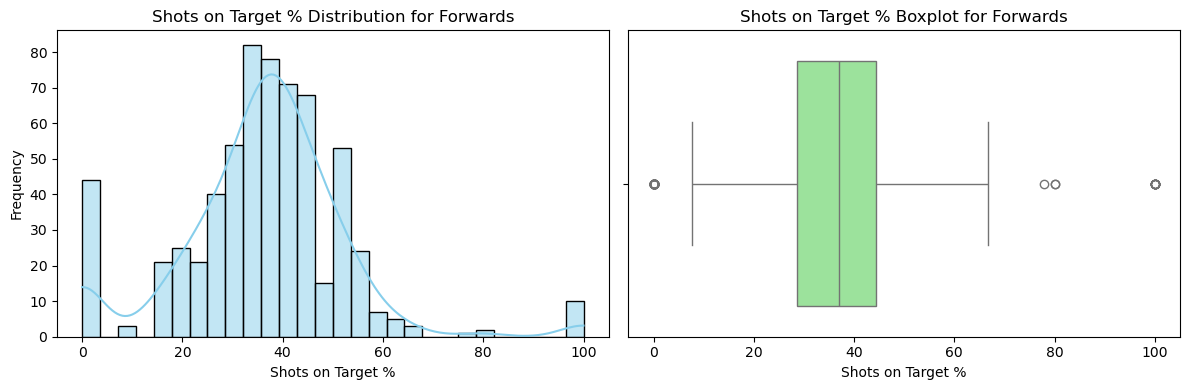

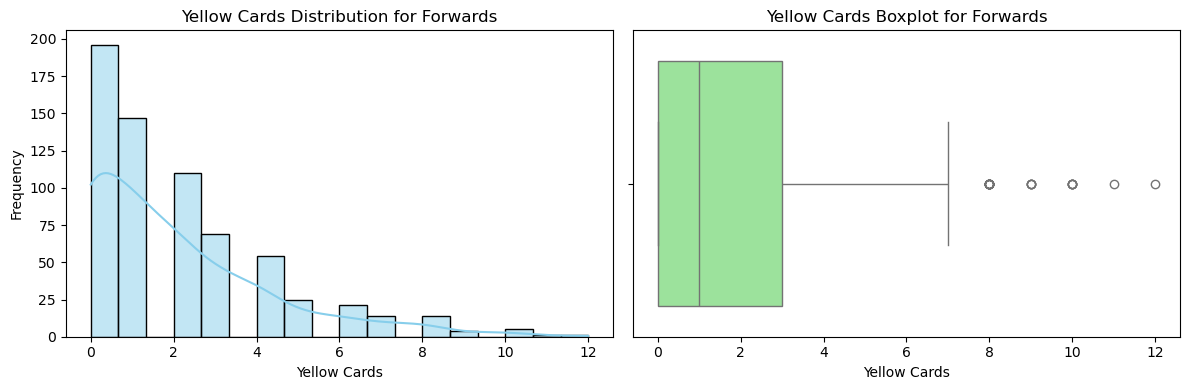

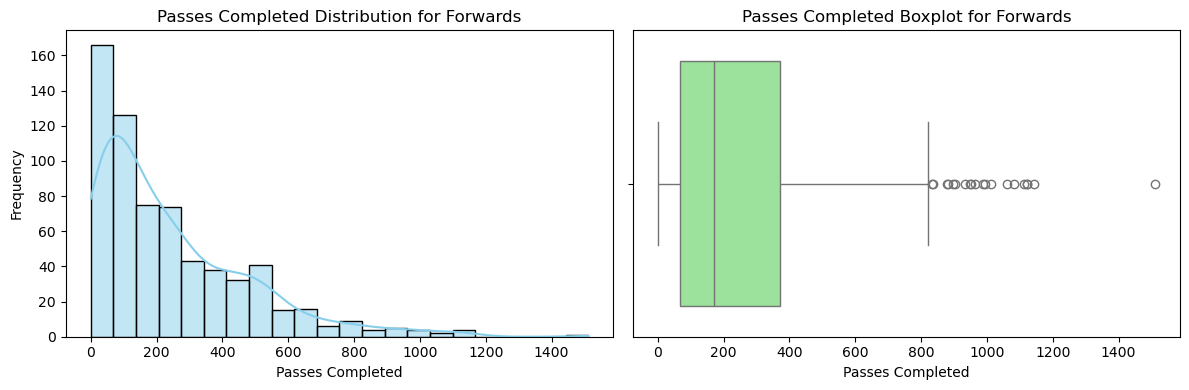

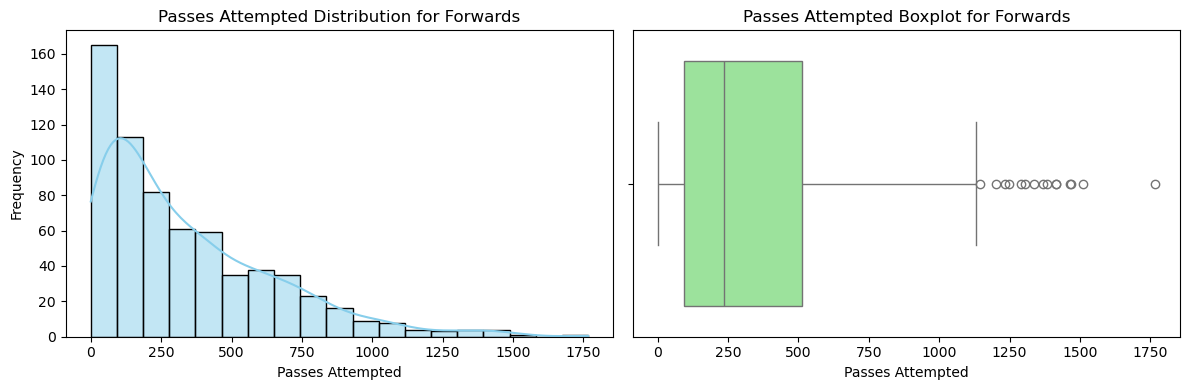

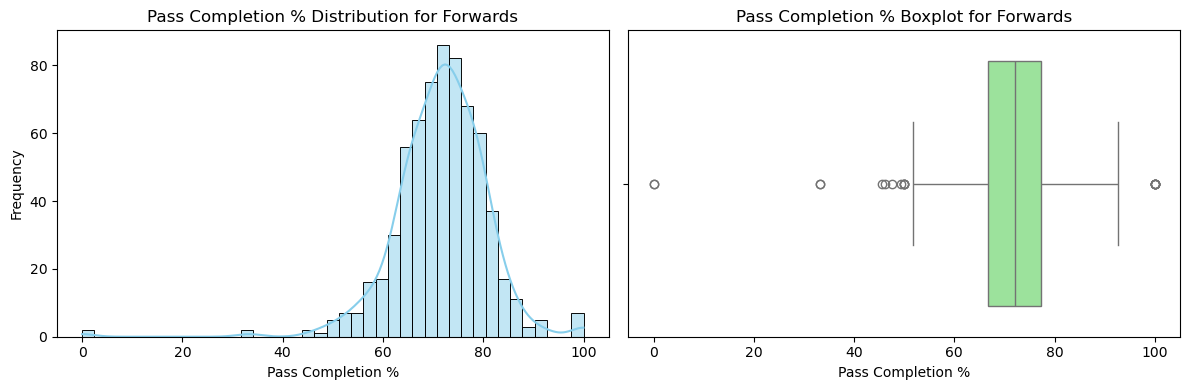

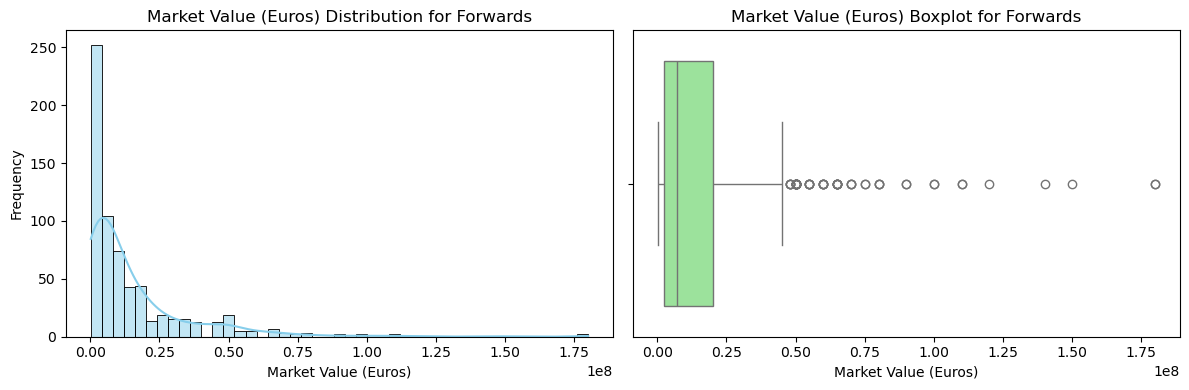

In [7]:
basic_stats = {
    'Goalkeepers': ['Goals Allowed', 'Saves Made', 'Save Percentage', 'Clean Sheets', 'Goals Allowed per 90 Minutes', 'Market Value (Euros)'],
    'Defenders': ['Goals', 'Assists', 'Yellow Cards', 'Red Cards', 'Tackles', 'Tackles Won', 'Interceptions', 'Clearances', 'Market Value (Euros)'],
    'Midfielders': ['Goals', 'Assists', 'Shots', 'Shots on Target', 'Yellow Cards', 'Tackles', 'Tackles Won', 'Passes Completed', 'Passes Attempted', 'Pass Completion %', 'Market Value (Euros)'],
    'Forwards': ['Goals', 'Assists', 'Shots', 'Shots on Target', 'Shots on Target %', 'Yellow Cards', 'Passes Completed', 'Passes Attempted', 'Pass Completion %', 'Market Value (Euros)']
}

def plot_and_save_plots(df, position, stats):
    for stat in stats:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        label = column_mapping.get(stat, stat)

        # histogram
        sns.histplot(df[stat].dropna(), kde=True, ax=axes[0], color="skyblue")
        axes[0].set_title(f'{label} Distribution for {position}')
        axes[0].set_xlabel(label)
        axes[0].set_ylabel('Frequency')

        # boxplot
        sns.boxplot(x=df[stat].dropna(), ax=axes[1], color="lightgreen")
        axes[1].set_title(f'{label} Boxplot for {position}')
        axes[1].set_xlabel(label)

        plt.tight_layout()
        plt.show()


for position, df in dataframes.items():
    plot_and_save_plots(df, position, basic_stats[position])


<a id="correlation-heatmaps"></a>

## <div class='section'>Section 7: Correlation Heatmaps</div>

[Return to contents](#contents)

Finally, we create correlation heatmaps to explore any positive or negative relationships between features that may be useful for further analysis or model building.


Generating correlation heatmap for Goalkeepers...


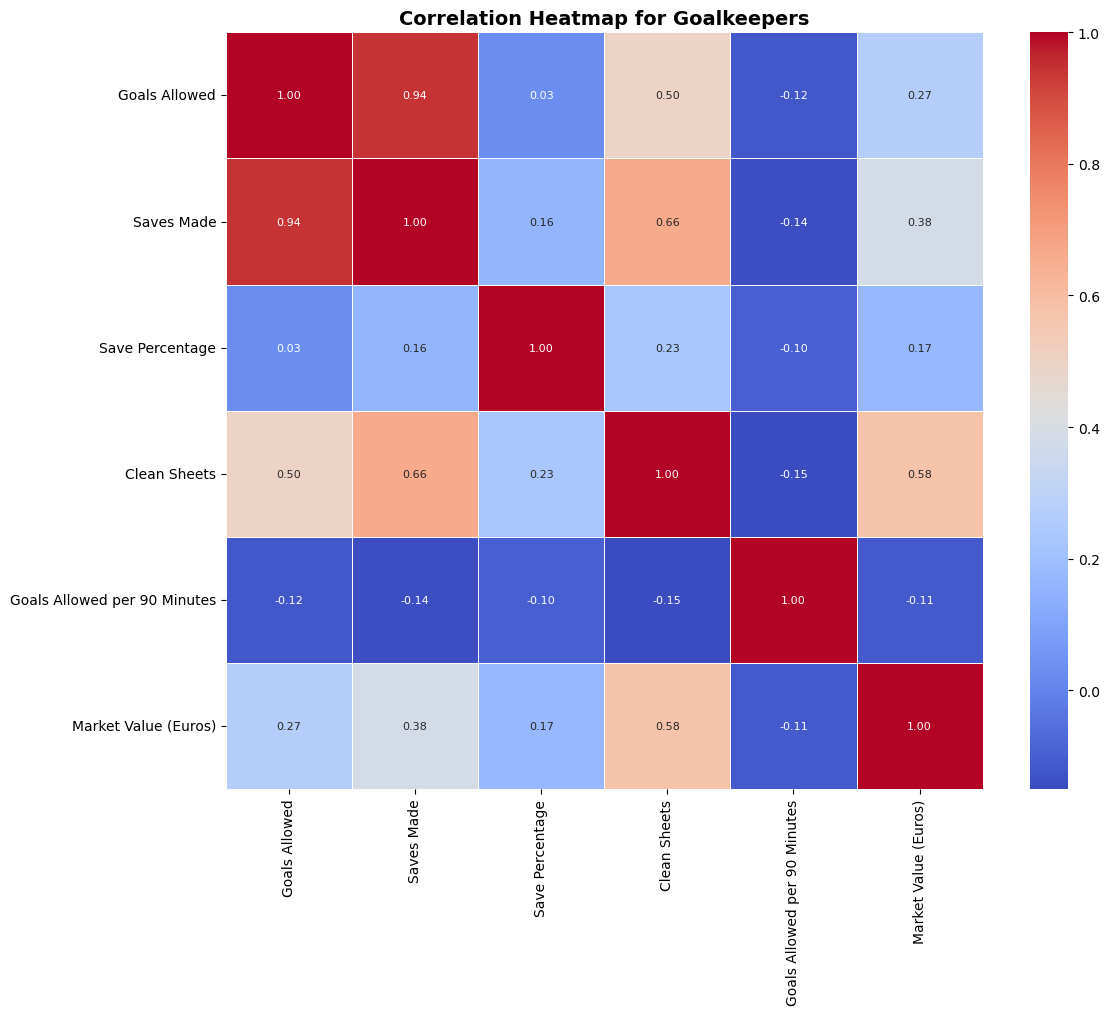

Generating correlation heatmap for Defenders...


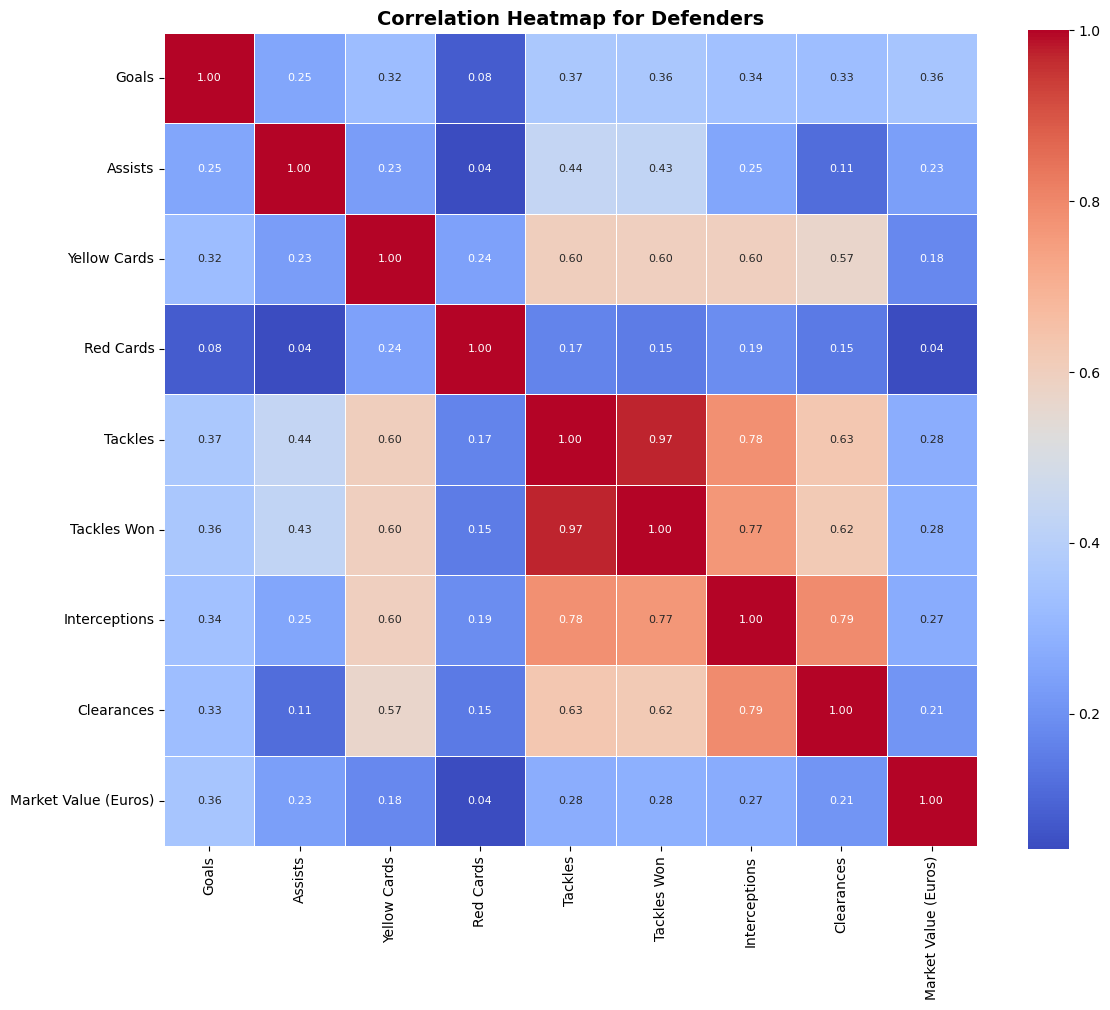

Generating correlation heatmap for Midfielders...


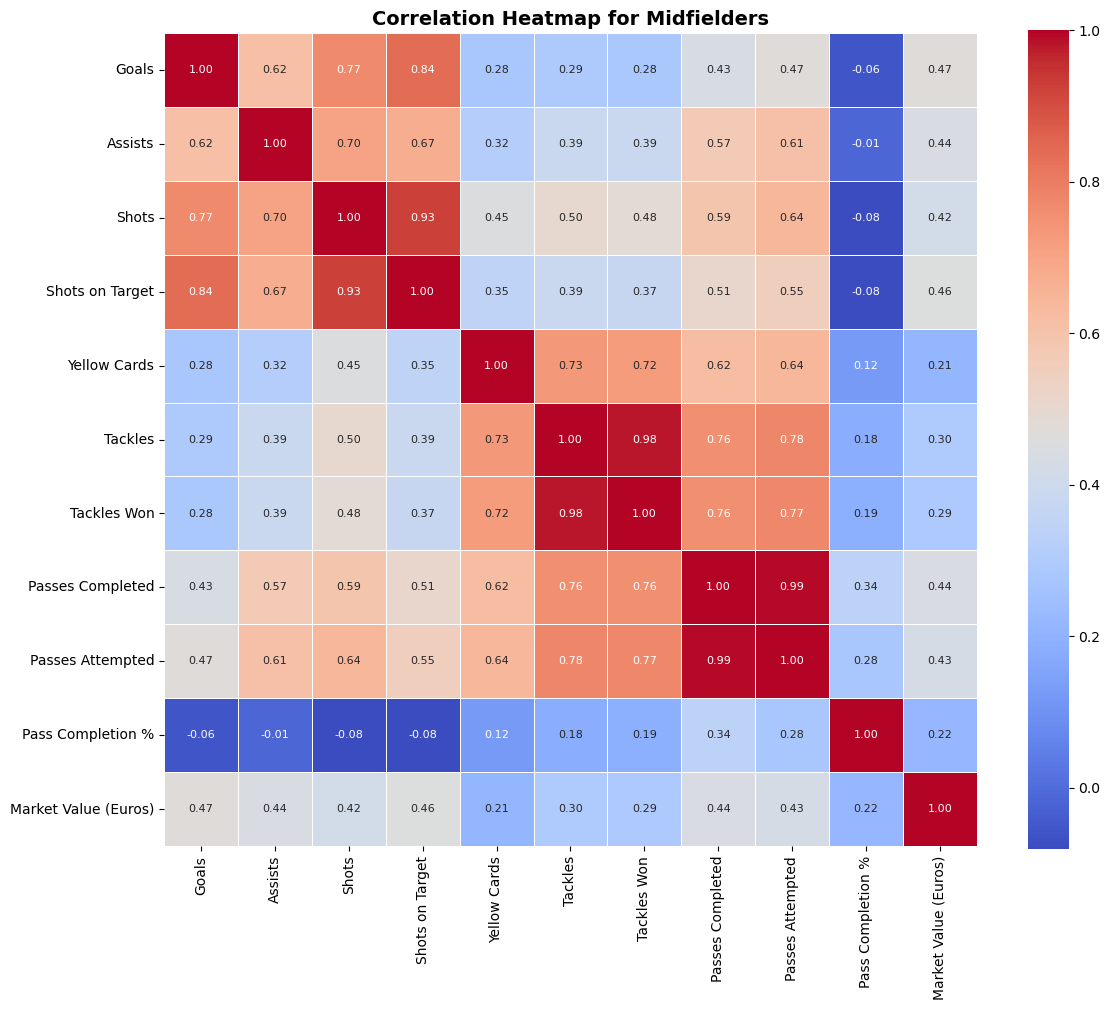

Generating correlation heatmap for Forwards...


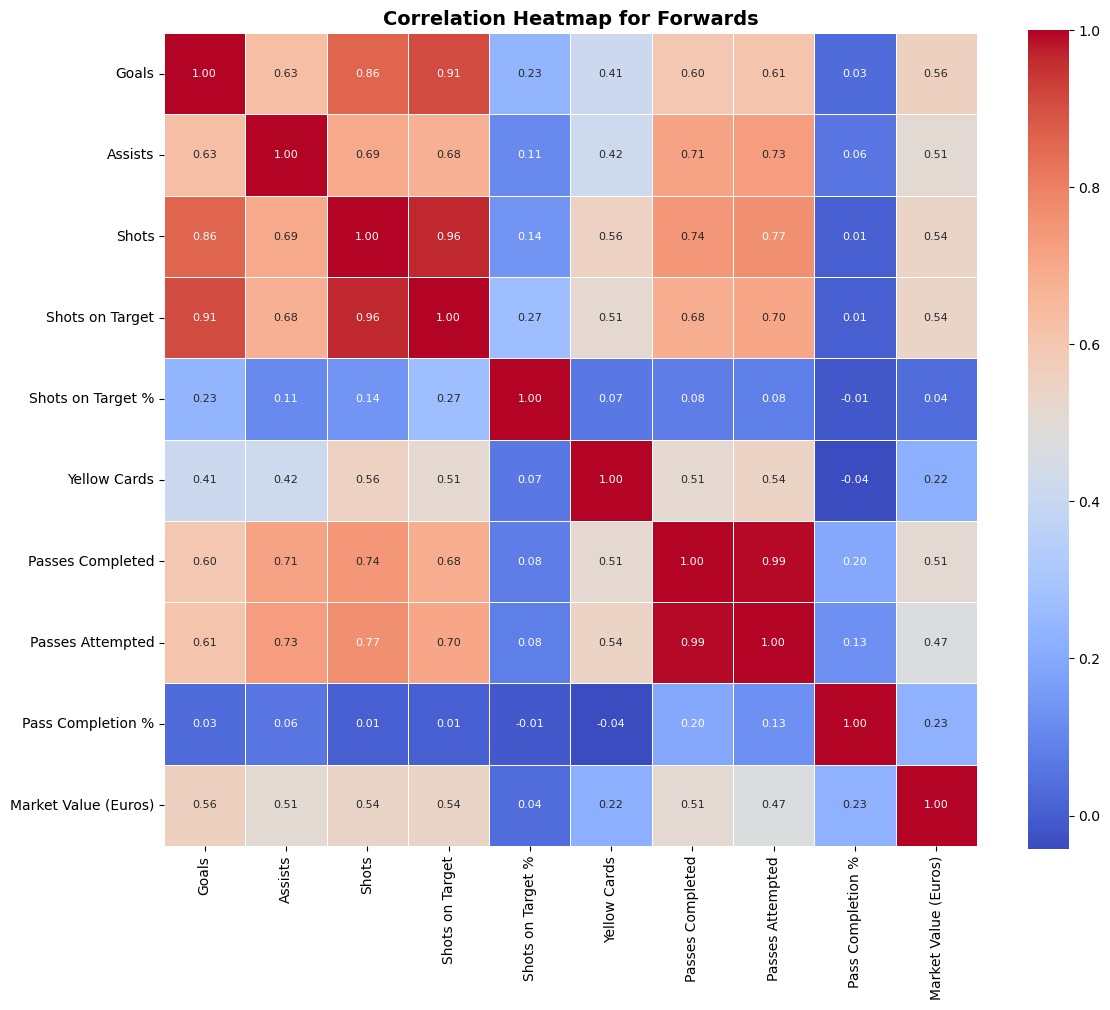

In [8]:
def save_correlation_heatmap(df, position, stats):
    df_filtered = df[stats]
    corr = df_filtered.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True,
                linewidths=0.5, annot_kws={"size": 8})
    plt.title(f'Correlation Heatmap for {position}', fontweight='bold', fontsize=14)
    plt.tight_layout()
    plt.show()

# generating and saving correlation heatmaps for each position
for position, df in dataframes.items():
    print(f"Generating correlation heatmap for {position}...")
    save_correlation_heatmap(df, position, basic_stats[position])


<a id="PCA"></a>

## <div class='section'>Section 8: Principal Component Analysis</div>

[Return to contents](#contents)

<a id="defense-pca"></a>

### <div class='subsection'>8.1 Defense PCA</div>

In this section we split the defender data into training and testing data and do a PCA analysis on the training data. 

[Return to Section 8](#PCA)

The total number of components is: 43.
The number of components required to explain 95% of the variance is: 15.


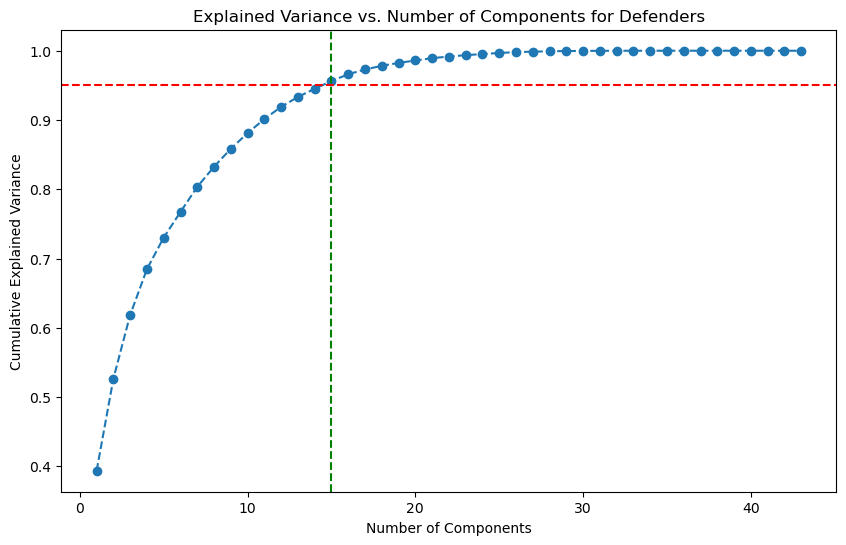

In [9]:
x_defender_train, x_defender_test, y_defender_train, y_defender_test = train_test_split(x_defenders, y_defenders, test_size=0.2, random_state=42)

pca = PCA()
defender_train_pca = pca.fit_transform(x_defender_train)
defender_test_pca = pca.transform(x_defender_test)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

defender_valid_components = np.argmax(cumulative_variance >= 0.95) + 1

print(f"The total number of components is: {pca.n_components_}.")
print(f"The number of components required to explain 95% of the variance is: {defender_valid_components}.")

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance,marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.axvline(x=defender_valid_components, color='g', linestyle='--', label=f'{defender_valid_components} Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components for Defenders')
plt.show()


In order to explain 95% of the variancee, only 16 principal components are needed. The steepness of the initial curve demonstrates that only a small number of components determine most of the variance in defencer performance. This analysis is helpful for PCA because it gives insight into how many components will be most helpful for the final model, and these principal components will be used in our baseline models as well. 

In [10]:
pca_95 = PCA(n_components=defender_valid_components)
defender_train_pca_95 = pca_95.fit_transform(x_defender_train)
defender_test_pca_95 = pca_95.transform(x_defender_test)

explained_variance_ratio_95 = pca_95.explained_variance_ratio_
cumulative_variance_95 = np.cumsum(explained_variance_ratio_95)

x_defender_train_indices, x_defender_test_indices, y_defender_train, y_defender_test = train_test_split(
    defenders.index, y_defenders, test_size=0.2, random_state=42
)


x_defender_train_df = pd.DataFrame(defender_train_pca_95, columns=[f"PC{i+1}" for i in range(defender_train_pca_95.shape[1])])
x_defender_train_df['Player'] = defenders.iloc[x_defender_train_indices]['Player'].values


x_defender_test_df = pd.DataFrame(defender_test_pca_95, columns=[f"PC{i+1}" for i in range(defender_test_pca_95.shape[1])])
x_defender_test_df['Player'] = defenders.iloc[x_defender_test_indices]['Player'].values

# Select the top 10 defenders based on PC1
top_defenders = x_defender_train_df.nlargest(10, 'PC1')
print("Top 10 defenders based on PC1:")
print(top_defenders[['Player', 'PC1']])




Top 10 defenders based on PC1:
                     Player     PC1
257             Pedro Porro  14.058
733     Giovanni Di Lorenzo  12.108
250        Jeremie Frimpong  11.099
678        Antonee Robinson  10.921
57               David Raum  10.487
404           Alfie Doughty  10.130
208         Kieran Trippier  10.122
518           Sergi Cardona  10.021
146  Trent Alexander-Arnold   9.992
488         Cristian Romero   9.984


We thought that this this information would be interesting to note so that when we did our later comparisons we could have another metric to use to compare models with each other. These players also tend to be higher-performing.

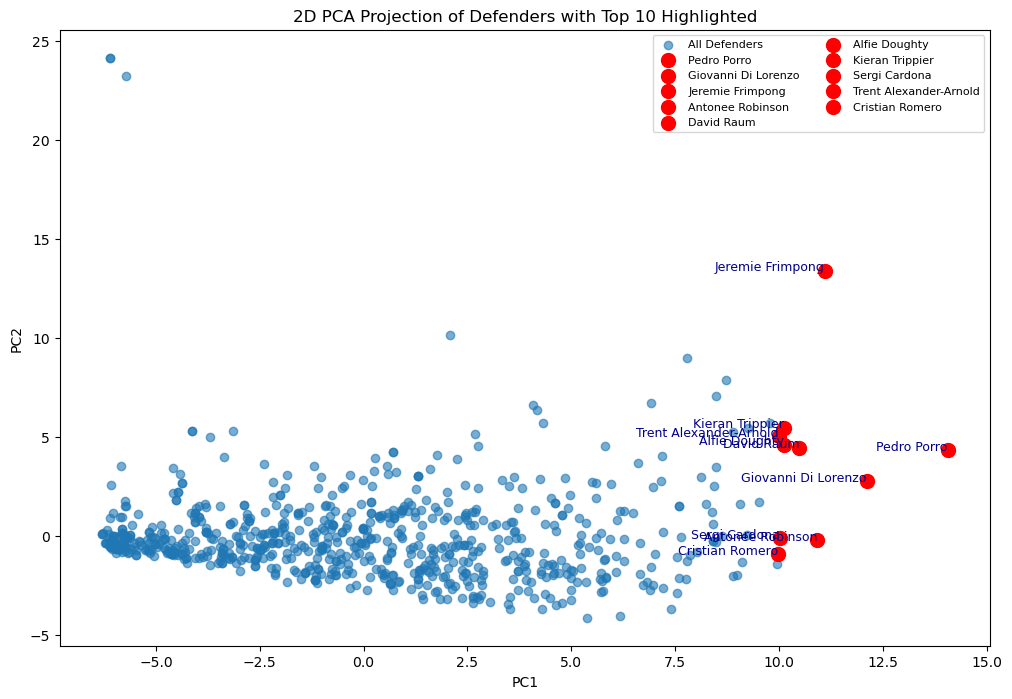

In [11]:
plt.figure(figsize=(12, 8))
plt.scatter(defender_train_pca[:, 0], defender_train_pca[:, 1], alpha=0.6, label="All Defenders")

for _, row in top_defenders.iterrows():
    pc1 = row['PC1']
    pc2 = row['PC2']
    plt.scatter(pc1, pc2, color='red', s=100, label=row['Player'])
    plt.text(pc1, pc2, row['Player'], fontsize=9, ha='right', color='darkblue')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA Projection of Defenders with Top 10 Highlighted")
plt.legend(loc='best', fontsize=8, ncol=2)
plt.show()

This plot demonstrates that most of the defenders are clustered and spread outwards. It is also apparent that there are no distinct groups outside of the large mass. However, the "top" defenders are at the edges of the cluster due to their high PC1 values. It is interesting to investigate why our higher performing athletes tend to be on the outskirts of the PCA. 

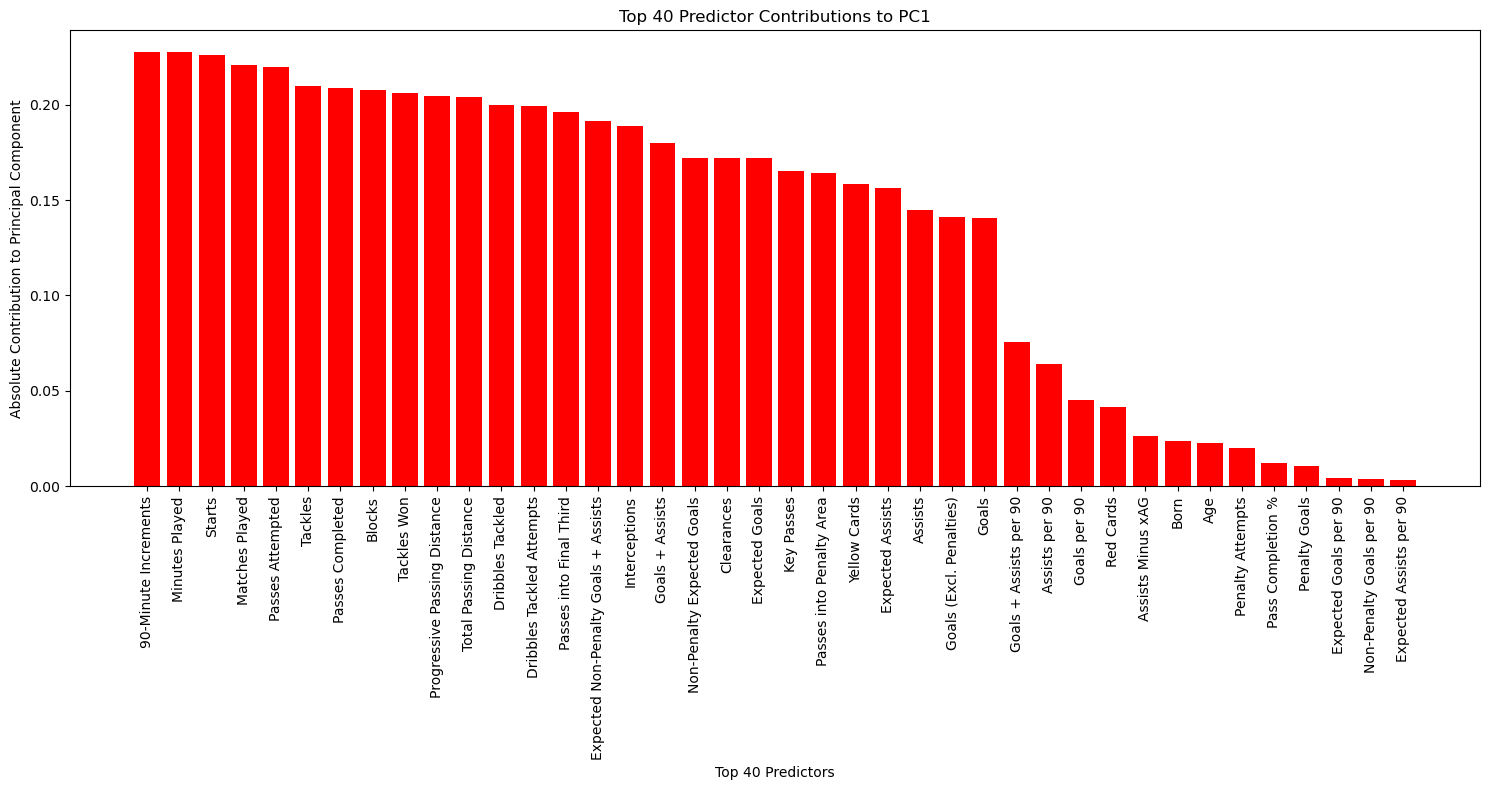

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
feature_names = defenders.select_dtypes(include=[np.number]).columns
pc_loadings = pca.components_[0]
absolute_loadings = np.abs(pc_loadings)

top_indices = np.argsort(absolute_loadings)[-40:][::-1]
top_features = feature_names[top_indices]
top_contributions = absolute_loadings[top_indices]
ax.bar(top_features, top_contributions, color='red')
ax.set_title('Top 40 Predictor Contributions to PC1')
ax.set_xticks(range(len(top_features)))
ax.set_xticklabels(top_features, rotation=90)
ax.set_xlabel('Top 40 Predictors')
ax.set_ylabel('Absolute Contribution to Principal Component')

plt.tight_layout()
plt.show()

Here, we can see the most important features to our first principal components. This gives us an idea of what features contribute most to the variance within athletes.

<a id="midfielder-pca"></a>

### <div class='subsection'>8.2 Midfielder PCA</div>

In this section we split the midfielder data into training and testing data and do a PCA analysis on the training data. 

[Return to Section 8](#PCA)

The total number of components is: 71.
The number of components required to explain 95% of the variance is: 20.


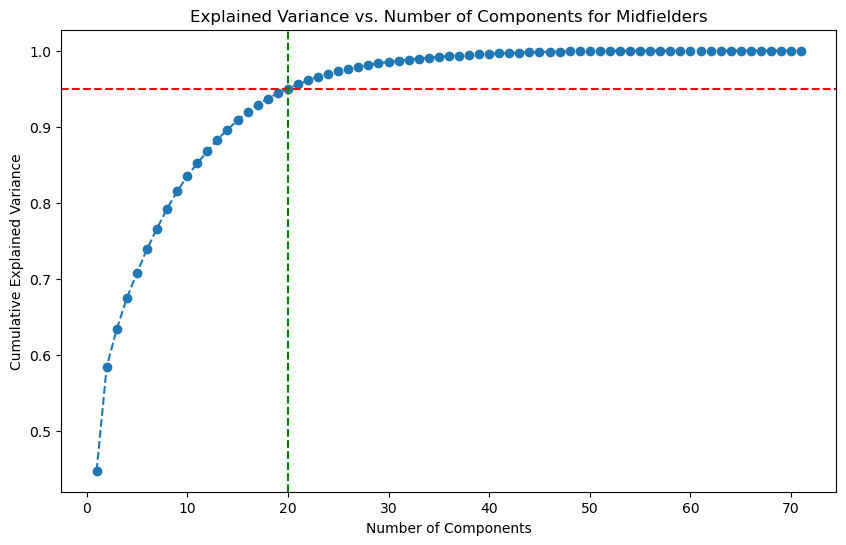

In [13]:
x_midfielder_train, x_midfielder_test, y_midfielder_train, y_midfielder_test = train_test_split(x_midfielders, y_midfielders, test_size=0.2, random_state=42)

pca = PCA()
midfielder_train_pca = pca.fit_transform(x_midfielder_train)
midfielder_test_pca = pca.transform(x_midfielder_test)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

midfielder_valid_components = np.argmax(cumulative_variance >= 0.95) + 1

print(f"The total number of components is: {pca.n_components_}.")
print(f"The number of components required to explain 95% of the variance is: {midfielder_valid_components}.")

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance,marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.axvline(x=midfielder_valid_components, color='g', linestyle='--', label=f'{midfielder_valid_components} Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components for Midfielders')
plt.show()

In order to explain 95% of the variancee, only 20 principal components are needed. The steepness of the initial curve demonstrates that only a small number of components determine most of the variance in defencer performance. This analysis is helpful for PCA because it gives insight into how many components will be most helpful for the final model, and these principal components will be used in our baseline models as well. 

In [14]:
pca_95 = PCA(n_components=midfielder_valid_components)
midfielder_train_pca_95 = pca_95.fit_transform(x_midfielder_train)
midfielder_test_pca_95 = pca_95.transform(x_midfielder_test)

explained_variance_ratio_95 = pca_95.explained_variance_ratio_
cumulative_variance_95 = np.cumsum(explained_variance_ratio_95)

x_midfielder_train_indices, x_midfielder_test_indices, y_midfielder_train, y_midfielder_test = train_test_split(
    midfielders.index, y_midfielders, test_size=0.2, random_state=42
)


x_midfielder_train_df = pd.DataFrame(midfielder_train_pca_95, columns=[f"PC{i+1}" for i in range(midfielder_train_pca_95.shape[1])])
x_midfielder_train_df['Player'] = midfielders.iloc[x_midfielder_train_indices]['Player'].values


x_midfielder_test_df = pd.DataFrame(midfielder_test_pca_95, columns=[f"PC{i+1}" for i in range(midfielder_test_pca_95.shape[1])])
x_midfielder_test_df['Player'] = midfielders.iloc[x_midfielder_test_indices]['Player'].values


top_midfielders = x_midfielder_train_df.nlargest(10, 'PC1')
print("Top 10 midfielders based on PC1:")
print(top_midfielders[['Player', 'PC1']])


Top 10 midfielders based on PC1:
              Player     PC1
502            Rodri  19.665
373      Pascal Groß  18.293
250  Bruno Fernandes  18.231
197  Bruno Guimarães  16.616
96   Martin Ødegaard  16.388
117      Declan Rice  14.755
518  Jude Bellingham  14.658
387     Kevin Stöger  14.300
126    Téji Savanier  14.272
245   İlkay Gündoğan  14.196


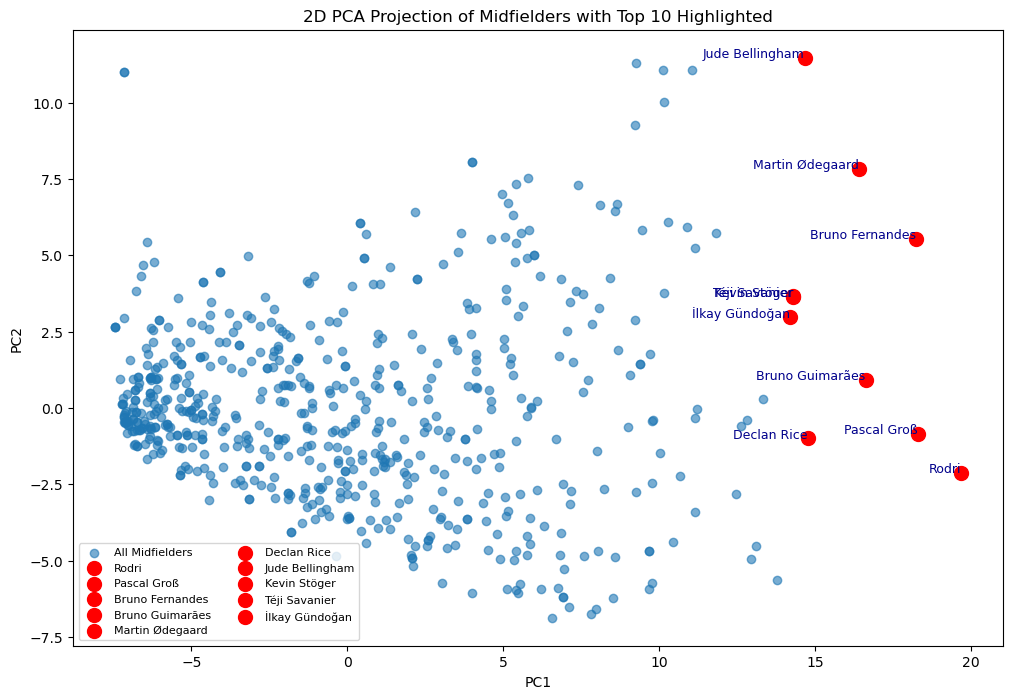

In [15]:
plt.figure(figsize=(12, 8))
plt.scatter(midfielder_train_pca[:, 0], midfielder_train_pca[:, 1], alpha=0.6, label="All Midfielders")

for _, row in top_midfielders.iterrows():
    pc1 = row['PC1']
    pc2 = row['PC2']
    plt.scatter(pc1, pc2, color='red', s=100, label=row['Player'])
    plt.text(pc1, pc2, row['Player'], fontsize=9, ha='right', color='darkblue')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA Projection of Midfielders with Top 10 Highlighted")
plt.legend(loc='best', fontsize=8, ncol=2)
plt.show()

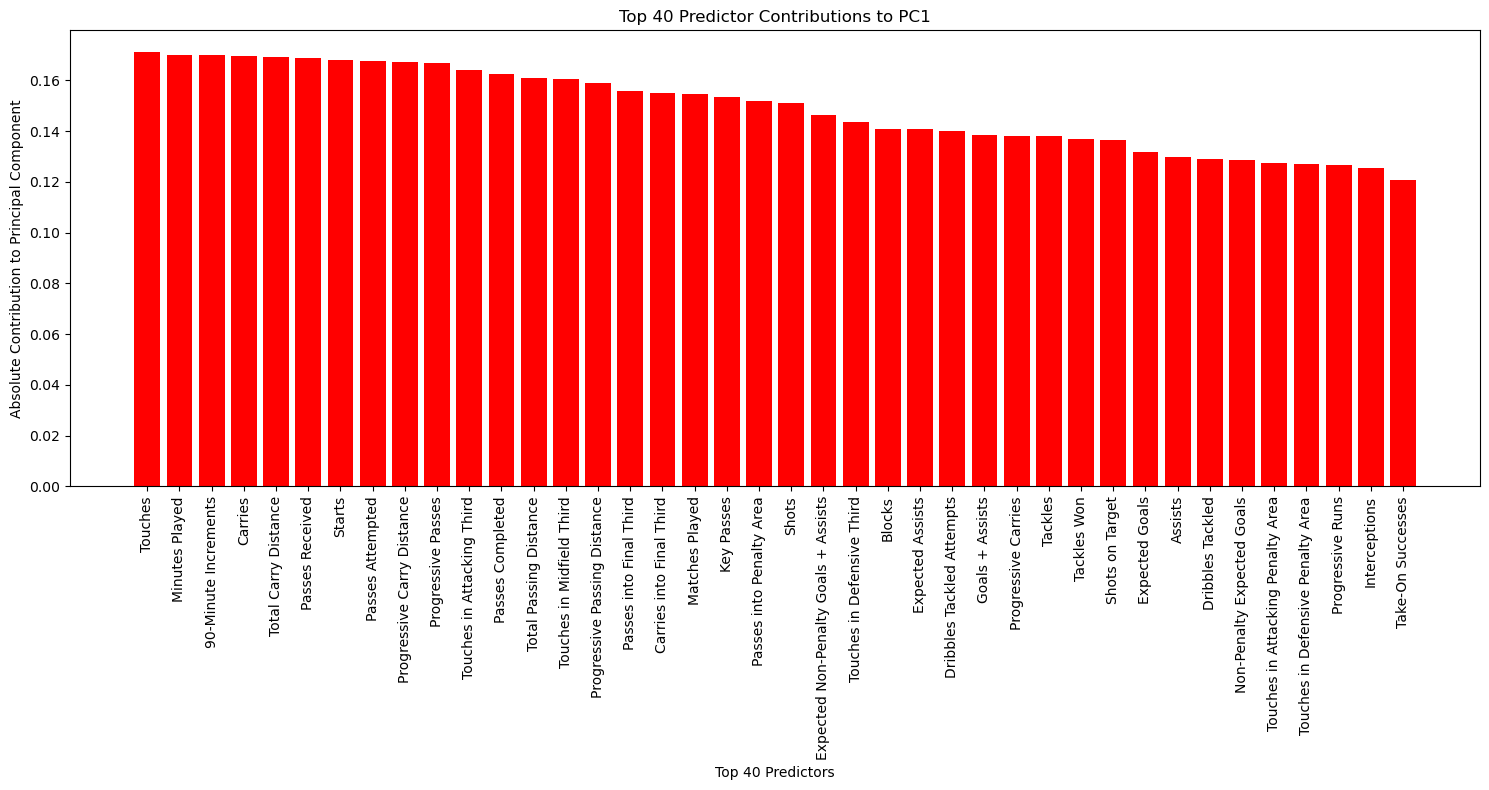

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
feature_names = midfielders.select_dtypes(include=[np.number]).columns
pc_loadings = pca.components_[0]
absolute_loadings = np.abs(pc_loadings)

top_indices = np.argsort(absolute_loadings)[-40:][::-1]
top_features = feature_names[top_indices]
top_contributions = absolute_loadings[top_indices]
ax.bar(top_features, top_contributions, color='red')
ax.set_title('Top 40 Predictor Contributions to PC1')
ax.set_xticks(range(len(top_features)))
ax.set_xticklabels(top_features, rotation=90)
ax.set_xlabel('Top 40 Predictors')
ax.set_ylabel('Absolute Contribution to Principal Component')

plt.tight_layout()
plt.show()

<a id="goalkeeper-pca"></a>

### <div class='subsection'>8.3 Goalkeeper PCA</div>

In this section we split the goalkeeper data into training and testing data and do a PCA analysis on the training data.

[Return to Section 8](#PCA)

The total number of components is: 19.
The number of components required to explain 95% of the variance is: 7.


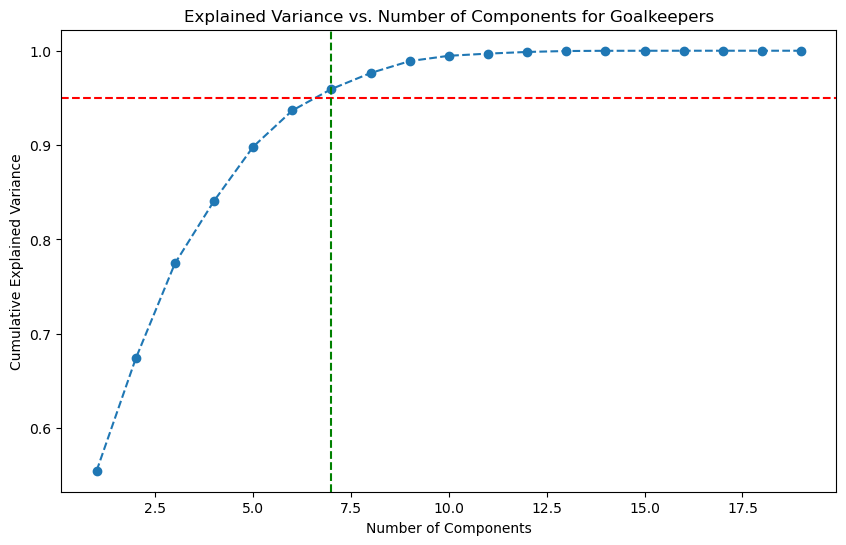

In [17]:
x_goalkeeper_train, x_goalkeeper_test, y_goalkeeper_train, y_goalkeeper_test = train_test_split(x_goalkeepers, y_goalkeepers, test_size=0.2, random_state=42)

pca = PCA()
goalkeeper_train_pca = pca.fit_transform(x_goalkeeper_train)
goalkeeper_test_pca = pca.transform(x_goalkeeper_test)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

goalkeeper_valid_components = np.argmax(cumulative_variance >= 0.95) + 1

print(f"The total number of components is: {pca.n_components_}.")
print(f"The number of components required to explain 95% of the variance is: {goalkeeper_valid_components}.")

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance,marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.axvline(x=goalkeeper_valid_components, color='g', linestyle='--', label=f'{goalkeeper_valid_components} Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components for Goalkeepers')
plt.show()

In order to explain 95% of the variancee, only 8 principal components are needed. The steepness of the initial curve demonstrates that only a small number of components determine most of the variance in defencer performance. This analysis is helpful for PCA because it gives insight into how many components will be most helpful for the final model, and these principal components will be used in our baseline models as well. 

In [18]:
pca_95 = PCA(n_components=goalkeeper_valid_components)
goalkeeper_train_pca_95 = pca_95.fit_transform(x_goalkeeper_train)
goalkeeper_test_pca_95 = pca_95.transform(x_goalkeeper_test)

explained_variance_ratio_95 = pca_95.explained_variance_ratio_
cumulative_variance_95 = np.cumsum(explained_variance_ratio_95)

x_goalkeeper_train_indices, x_goalkeeper_test_indices, y_goalkeeper_train, y_goalkeeper_test = train_test_split(
    goalkeepers.index, y_goalkeepers, test_size=0.2, random_state=42
)


x_goalkeeper_train_df = pd.DataFrame(goalkeeper_train_pca_95, columns=[f"PC{i+1}" for i in range(goalkeeper_train_pca_95.shape[1])])
x_goalkeeper_train_df['Player'] = goalkeepers.iloc[x_goalkeeper_train_indices]['Player'].values


x_goalkeeper_test_df = pd.DataFrame(goalkeeper_test_pca_95, columns=[f"PC{i+1}" for i in range(goalkeeper_test_pca_95.shape[1])])
x_goalkeeper_test_df['Player'] = goalkeepers.iloc[x_goalkeeper_test_indices]['Player'].values


top_goalkeepers = x_goalkeeper_train_df.nlargest(10, 'PC1')
print("Top 10 goalkeepers based on PC1:")
print(top_goalkeepers[['Player', 'PC1']])

Top 10 goalkeepers based on PC1:
                   Player    PC1
107           André Onana  5.565
104       Filip Jørgensen  5.169
112       Thomas Kaminski  5.059
79        Paulo Gazzaniga  4.997
64        Jordan Pickford  4.927
9            Mark Flekken  4.830
20                José Sá  4.810
113  Giorgi Mamardashvili  4.788
2              Bernd Leno  4.701
110        Oliver Baumann  4.652


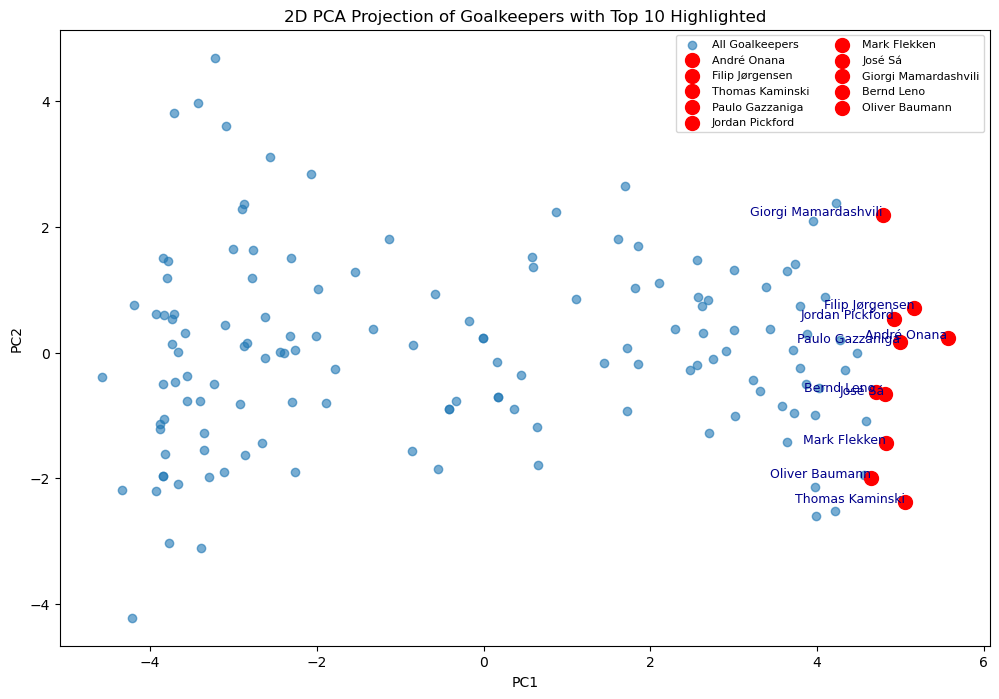

In [19]:
plt.figure(figsize=(12, 8))
plt.scatter(goalkeeper_train_pca[:, 0], goalkeeper_train_pca[:, 1], alpha=0.6, label="All Goalkeepers")

for _, row in top_goalkeepers.iterrows():
    pc1 = row['PC1']
    pc2 = row['PC2']
    plt.scatter(pc1, pc2, color='red', s=100, label=row['Player'])
    plt.text(pc1, pc2, row['Player'], fontsize=9, ha='right', color='darkblue')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA Projection of Goalkeepers with Top 10 Highlighted")
plt.legend(loc='best', fontsize=8, ncol=2)
plt.show()

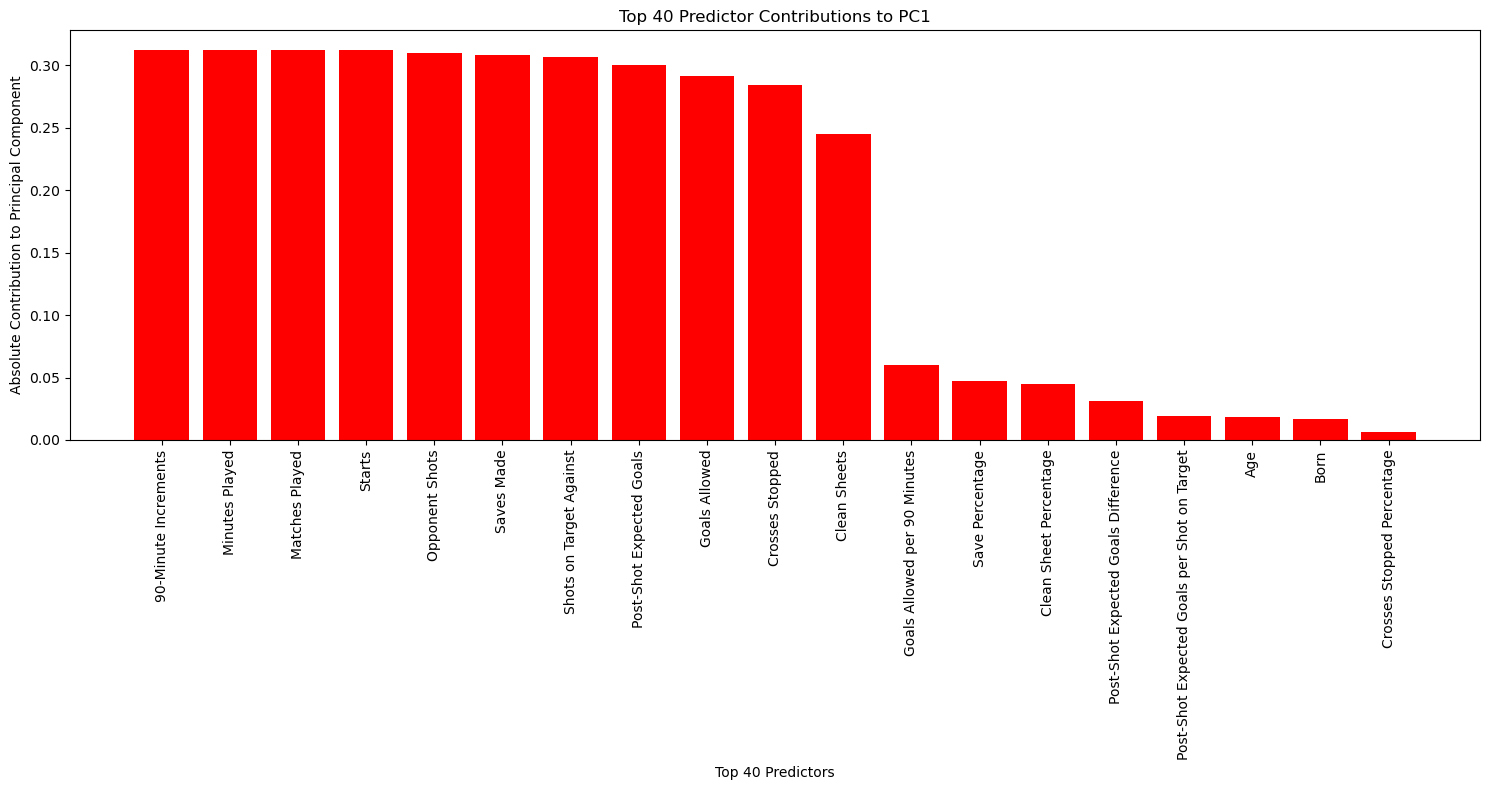

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
feature_names = goalkeepers.select_dtypes(include=[np.number]).columns
pc_loadings = pca.components_[0]
absolute_loadings = np.abs(pc_loadings)

top_indices = np.argsort(absolute_loadings)[-40:][::-1]
top_features = feature_names[top_indices]
top_contributions = absolute_loadings[top_indices]
ax.bar(top_features, top_contributions, color='red')
ax.set_title('Top 40 Predictor Contributions to PC1')
ax.set_xticks(range(len(top_features)))
ax.set_xticklabels(top_features, rotation=90)
ax.set_xlabel('Top 40 Predictors')
ax.set_ylabel('Absolute Contribution to Principal Component')

plt.tight_layout()
plt.show()

<a id="forward-pca-2"></a>

### <div class='subsection'>8.4 Forward PCA</div>


In this section we split the defender data into training and testing data and do a PCA analysis on the training data. 

[Return to Section 8](#PCA)

The total number of components is: 62.
The number of components required to explain 95% of the variance is: 17.


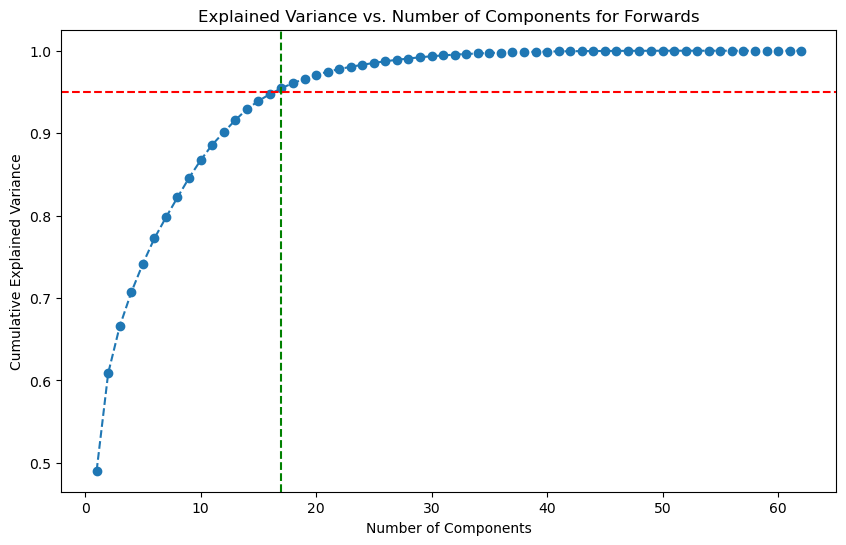

In [21]:
x_forward_train, x_forward_test, y_forward_train, y_forward_test = train_test_split(x_forwards, y_forwards, test_size=0.2, random_state=42)

pca = PCA()
forward_train_pca = pca.fit_transform(x_forward_train)
forward_test_pca = pca.transform(x_forward_test)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

forward_valid_components = np.argmax(cumulative_variance >= 0.95) + 1

print(f"The total number of components is: {pca.n_components_}.")
print(f"The number of components required to explain 95% of the variance is: {forward_valid_components}.")

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance,marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.axvline(x=forward_valid_components, color='g', linestyle='--', label=f'{forward_valid_components} Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components for Forwards')
plt.show()


In order to explain 95% of the variance, only 18 principal components are needed. The steepness of the initial curve demonstrates that only a small number of components determine most of the variance in defencer performance. This analysis is helpful for PCA because it gives insight into how many components will be most helpful for the final model, and these principal components will be used in our baseline models as well. 

In [22]:
pca_95 = PCA(n_components=forward_valid_components)
forward_train_pca_95 = pca_95.fit_transform(x_forward_train)
forward_test_pca_95 = pca_95.transform(x_forward_test)

explained_variance_ratio_95 = pca_95.explained_variance_ratio_
cumulative_variance_95 = np.cumsum(explained_variance_ratio_95)

x_forward_train_indices, x_forward_test_indices, y_forward_train, y_forward_test = train_test_split(
    forwards.index, y_forwards, test_size=0.2, random_state=42
)


x_forward_train_df = pd.DataFrame(forward_train_pca_95, columns=[f"PC{i+1}" for i in range(forward_train_pca_95.shape[1])])
x_forward_train_df['Player'] = forwards.iloc[x_forward_train_indices]['Player'].values


x_forward_test_df = pd.DataFrame(forward_test_pca_95, columns=[f"PC{i+1}" for i in range(forward_test_pca_95.shape[1])])
x_forward_test_df['Player'] = forwards.iloc[x_forward_test_indices]['Player'].values


top_forwards = x_forward_train_df.nlargest(10, 'PC1')
print("Top 10 forwards based on PC1:")
print(top_forwards[['Player', 'PC1']])

Top 10 forwards based on PC1:
                    Player     PC1
155            Cole Palmer  19.283
296            Cole Palmer  19.283
320            Bukayo Saka  19.139
211  Khvicha Kvaratskhelia  16.852
328          Kylian Mbappé  16.197
293    Romain Del Castillo  15.058
441            Rafael Leão  14.388
281          Chris Führich  14.365
20              Harry Kane  14.227
203       Dejan Kulusevski  13.923


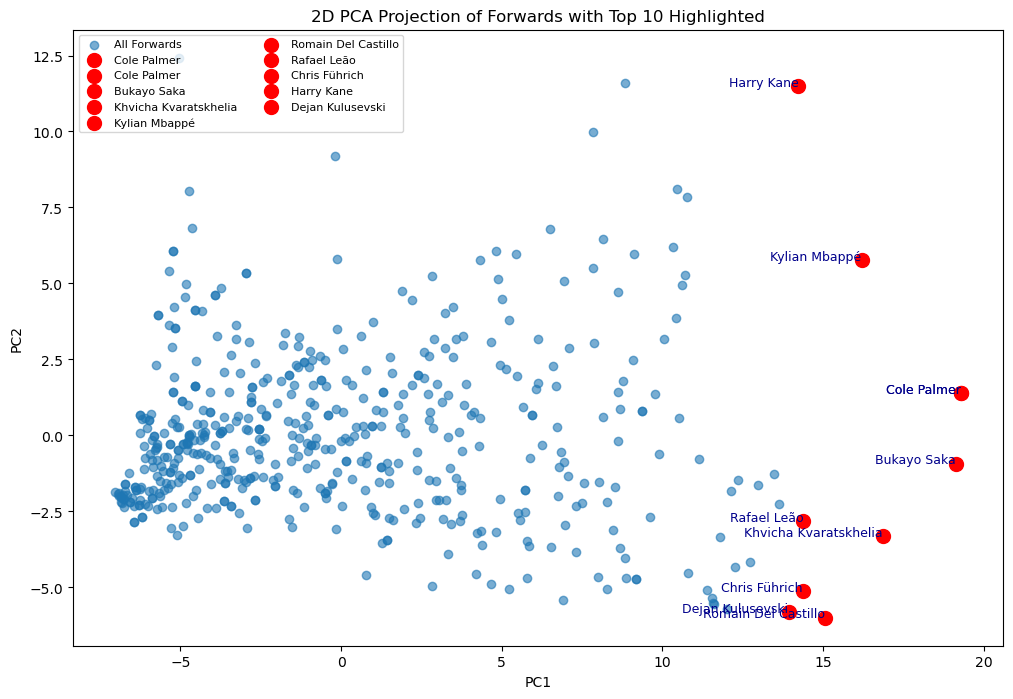

In [23]:
plt.figure(figsize=(12, 8))
plt.scatter(forward_train_pca[:, 0], forward_train_pca[:, 1], alpha=0.6, label="All Forwards")

for _, row in top_forwards.iterrows():
    pc1 = row['PC1']
    pc2 = row['PC2']
    plt.scatter(pc1, pc2, color='red', s=100, label=row['Player'])
    plt.text(pc1, pc2, row['Player'], fontsize=9, ha='right', color='darkblue')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA Projection of Forwards with Top 10 Highlighted")
plt.legend(loc='best', fontsize=8, ncol=2)
plt.show()

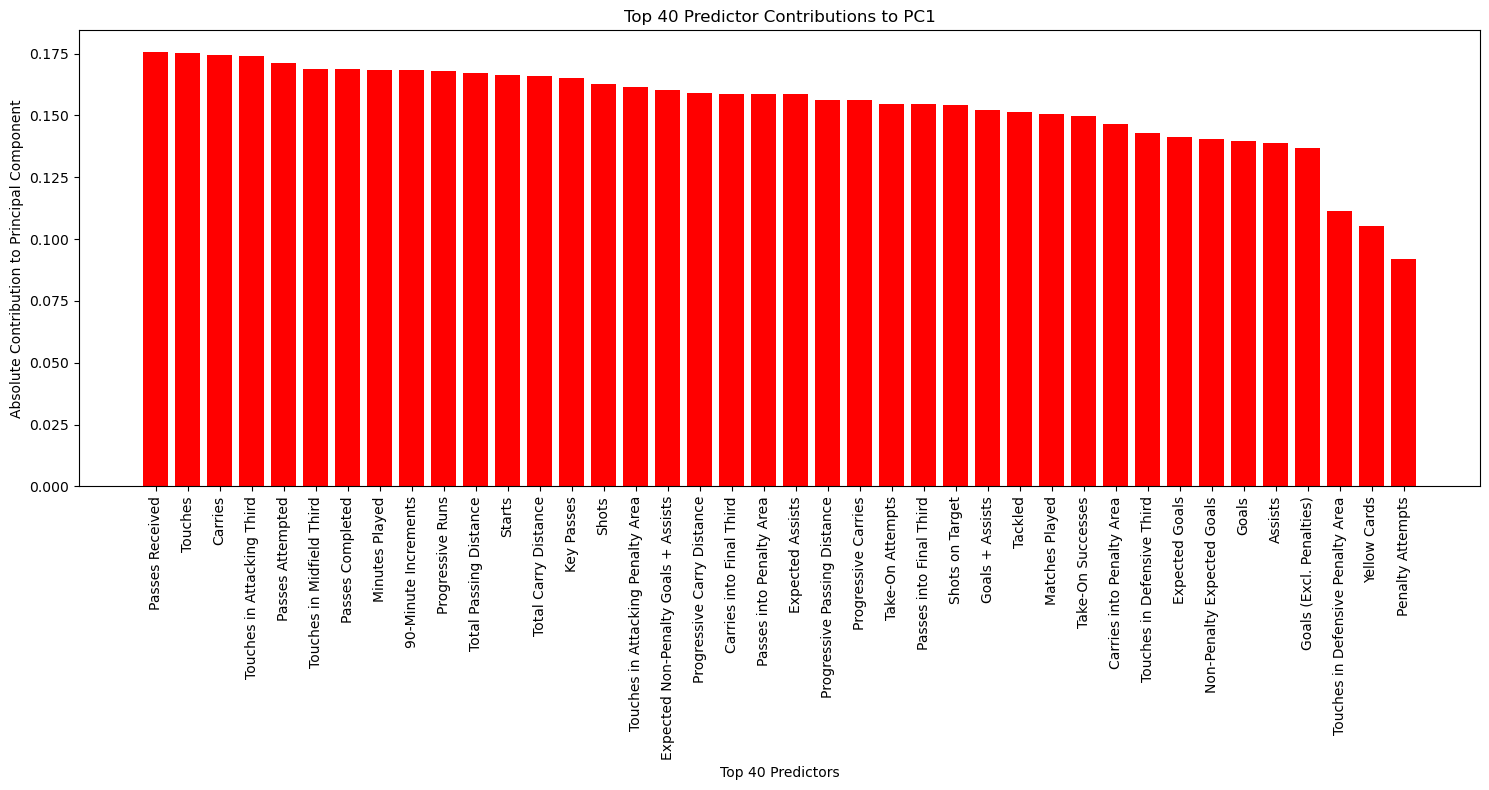

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
feature_names = forwards.select_dtypes(include=[np.number]).columns
pc_loadings = pca.components_[0]
absolute_loadings = np.abs(pc_loadings)

top_indices = np.argsort(absolute_loadings)[-40:][::-1]
top_features = feature_names[top_indices]
top_contributions = absolute_loadings[top_indices]
ax.bar(top_features, top_contributions, color='red')
ax.set_title('Top 40 Predictor Contributions to PC1')
ax.set_xticks(range(len(top_features)))
ax.set_xticklabels(top_features, rotation=90)
ax.set_xlabel('Top 40 Predictors')
ax.set_ylabel('Absolute Contribution to Principal Component')

plt.tight_layout()
plt.show()

<a id="baseline-models"></a>

## <div class='section'>Section 9: Baseline Modeling</div>

[Return to contents](#contents)


### <a id="baseline-models-defense-dt"></a> 9.1.A Defensive Player Decision Tree

In [25]:
criterion = ['squared_error', 'friedman_mse']
first_depth = 2
final_depth = 30
step = 1

results = []

for cur_criterion in criterion:
    for max_depth in range(first_depth, final_depth + 1, step):
        dt = DecisionTreeRegressor(criterion=cur_criterion, max_depth=max_depth, random_state=42)
        
        scores = cross_val_score(dt, X=defender_train_pca, y=y_defender_train, cv=5, n_jobs=-1, scoring='r2')
        
        cur_results = {
            'criterion': cur_criterion,
            'depth': max_depth,
            'all_cv': scores,
            'mean_cv': scores.mean()
        }
        results.append(cur_results)


df = pd.DataFrame(results)


best_param = df.sort_values(by='mean_cv', ascending=False).iloc[0]

df_squared = df[df['criterion'] == 'squared_error']
df_friedman = df[df['criterion'] == 'friedman_mse']


best_depth_squared = df_squared.loc[df_squared['mean_cv'].idxmax(), 'depth']
best_depth_friedman = df_friedman.loc[df_friedman['mean_cv'].idxmax(), 'depth']


model_tree_squared = DecisionTreeRegressor(max_depth=int(best_depth_squared), criterion='squared_error', random_state=42)
model_tree_friedman = DecisionTreeRegressor(max_depth=int(best_depth_friedman), criterion='friedman_mse', random_state=42)


model_tree_squared.fit(defender_train_pca, y_defender_train)
model_tree_friedman.fit(defender_train_pca, y_defender_train)


train_pred_squared = model_tree_squared.predict(defender_train_pca)
train_pred_friedman = model_tree_friedman.predict(defender_train_pca)

r2_train_squared = r2_score(y_defender_train, train_pred_squared)
r2_train_friedman = r2_score(y_defender_train, train_pred_friedman)

cv_r2_squared = df_squared.loc[df_squared['mean_cv'].idxmax(), 'mean_cv']
cv_r2_friedman = df_friedman.loc[df_friedman['mean_cv'].idxmax(), 'mean_cv']

print("================ [Squared Error (Using PCA)] ================")
print("Training R²: {:.4f}".format(r2_train_squared))
print("Cross-Validation R²: {:.4f}".format(cv_r2_squared))

print("\n================ [Friedman MSE (Using PCA)] ================")
print("Training R²: {:.4f}".format(r2_train_friedman))
print("Cross-Validation R²: {:.4f}".format(cv_r2_friedman))


if cv_r2_squared >= cv_r2_friedman:
    model = model_tree_squared
    best_criterion = 'squared_error'
    best_depth = best_depth_squared
else:
    model = model_tree_friedman
    best_criterion = 'friedman_mse'
    best_depth = best_depth_friedman


pred = model.predict(defender_test_pca)


pred_exp = np.expm1(pred)
y_test_exp = np.expm1(y_defender_test)


test_r2 = r2_score(y_test_exp, pred_exp)
test_mse = mean_squared_error(y_test_exp, pred_exp)
test_mae = mean_absolute_error(y_test_exp, pred_exp)

print("\n================ [Best Decision Tree Model] ================")
print(f"Best Criterion: {best_criterion}")
print(f"Best Depth: {best_depth}")
print("\nTest R²: {:.4f}".format(test_r2))
print("Test MSE: {:.4f}".format(test_mse))
print("Test MAE: {:.4f}".format(test_mae))


defenders_results_df = pd.DataFrame(columns=['model', 'r2', 'mse', 'mae'])
new_row = pd.DataFrame({
    'model': ['Decision Tree'],  
    'r2': [round(test_r2, 4)],
    'mse': [round(test_mse, 4)],
    'mae': [round(test_mae, 4)]
})

defenders_results_df = pd.concat([defenders_results_df, new_row], ignore_index=True)
display(defenders_results_df)


================ [Squared Error (Using PCA)] ================
Training R²: 0.5101
Cross-Validation R²: 0.2708

================ [Friedman MSE (Using PCA)] ================
Training R²: 0.5101
Cross-Validation R²: 0.2708

================ [Best Decision Tree Model] ================
Best Criterion: squared_error
Best Depth: 4

Test R²: 0.3599
Test MSE: 88018581430391.5781
Test MAE: 5288522.4763


/var/folders/gf/xxqycrk54d9c_hw_hkbc1zgh0000gn/T/ipykernel_11158/1383089991.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  defenders_results_df = pd.concat([defenders_results_df, new_row], ignore_index=True)


model    r2        mse        mae
0  Decision Tree  0.36  8.802e+13  5.289e+06

The regression results indicate that the decision tree model struggles to generalize beyond the training data. Although the training R² of approximately 0.2496 suggests that the model can capture some patterns within the training set, the cross-validation R² of around 0.14 shows a substantial drop in performance, indicating overfitting. More concerning is the R² (0.099) on the test set, which implies that the model’s predictions are worse than a simple baseline that always predicts the mean value. This poor generalization, combined with the elevated training scores, strongly suggests that the decision tree regressor in its current form is not well suited for this annual wage prediction task. Further model refinement, feature engineering, or alternative modeling approaches are necessary to achieve more reliable and meaningful results.

### <a id="baseline-models-defense-bagging"></a> 9.1.B Defense Player Bagging Model

In [26]:


bagging_defenders = BaggingRegressor(random_state=42, n_estimators=50)

bagging_defenders.fit(defender_train_pca, y_defender_train)
                      
y_pred_bagging = bagging_defenders.predict(defender_test_pca)

r2 = r2_score(np.expm1(y_defender_test), np.expm1(y_pred_bagging))
mse = mean_squared_error(np.expm1(y_defender_test), np.expm1(y_pred_bagging))
mae = mean_absolute_error(np.expm1(y_defender_test), np.expm1(y_pred_bagging))


print("\nTest R² (Bagging): {:.4f}".format(r2))
print("Test MSE (Bagging): {:.4f}".format(mse))
print("Test MAE (Bagging): {:.4f}".format(mae))

new_row = pd.DataFrame({
    'model': ['Bagging (Decision Trees)'],  
    'r2': [round(r2, 4)],
    'mse': [round(mse, 4)],
    'mae': [round(mae, 4)]

})

defenders_results_df = pd.concat([defenders_results_df, new_row], ignore_index=True)
display(defenders_results_df)


Test R² (Bagging): 0.4454
Test MSE (Bagging): 76263133579373.5312
Test MAE (Bagging): 4417952.3029


model     r2        mse        mae
0             Decision Tree  0.360  8.802e+13  5.289e+06
1  Bagging (Decision Trees)  0.445  7.626e+13  4.418e+06

The results suggest that while the decision trees can capture some variance in the training data (with a training R² around 0.24) and achieve low cross-validation scores (just above 0.20), the generalization to unseen data remains challenging. Even after employing bagging, the test R² is only about 0.202, indicating that the ensemble model explains very little of the variance in the test set. The test MSE of approximately 0.450 further highlights the gap between training and testing performance, suggesting that these models, in their current configurations, have limited predictive power for this particular task.

### <a id="baseline-models-defense-logreg"></a> 9.1.C Defensive Player Linear Regression Model

In [27]:

lr = LinearRegression()
lr.fit(defender_train_pca, y_defender_train)


pred = lr.predict(defender_test_pca)

r2 = r2_score(np.expm1(y_defender_test), np.expm1(pred))
mse = mean_squared_error(np.expm1(y_defender_test), np.expm1(pred))
mae = mean_absolute_error(np.expm1(y_defender_test), np.expm1(pred))

print("\nTest R² (Linear Regression): {:.4f}".format(r2))
print("Test MSE (Linear Regression): {:.4f}".format(mse))
print("Test MAE (Linear Regression): {:.4f}".format(mae))


new_row = pd.DataFrame({
    'model': ['LinearReg'],  
    'r2': [round(r2,4)],
    'mse': [round(mse,4)],
    'mae': [round(mae,4)]
})


defenders_results_df = pd.concat([defenders_results_df, new_row], ignore_index=True)
display(defenders_results_df)



Test R² (Linear Regression): 0.5782
Test MSE (Linear Regression): 57997715646067.8281
Test MAE (Linear Regression): 4200011.7294


model     r2        mse        mae
0             Decision Tree  0.360  8.802e+13  5.289e+06
1  Bagging (Decision Trees)  0.445  7.626e+13  4.418e+06
2                 LinearReg  0.578  5.800e+13  4.200e+06

### <a id="baseline-models-defense-rf"></a> 9.1.D Defensive Player Random Forest Model

In [28]:
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)  
rf_model.fit(defender_train_pca, y_defender_train)

pred = rf_model.predict(defender_test_pca)

r2 = r2_score(np.expm1(y_defender_test), np.expm1(pred))
mse = mean_squared_error(np.expm1(y_defender_test), np.expm1(pred))
mae = mean_absolute_error(np.expm1(y_defender_test), np.expm1(pred))

print("\nTest R² (Random Forest): {:.4f}".format(r2))
print("Test MSE (Random Forest): {:.4f}".format(mse))
print("Test MAE (Random Forest): {:.4f}".format(mae))


new_row = pd.DataFrame({
    'model': ['Random Forest'],  
    'r2': [round(r2,4)],
    'mse': [round(mse,4)],
    'mae': [round(mae,4)]
})
defenders_results_df = pd.concat([defenders_results_df, new_row], ignore_index=True)
display(defenders_results_df)




Test R² (Random Forest): 0.4396
Test MSE (Random Forest): 77065643248252.8438
Test MAE (Random Forest): 4380836.4864


model     r2        mse        mae
0             Decision Tree  0.360  8.802e+13  5.289e+06
1  Bagging (Decision Trees)  0.445  7.626e+13  4.418e+06
2                 LinearReg  0.578  5.800e+13  4.200e+06
3             Random Forest  0.440  7.707e+13  4.381e+06

### <a id="baseline-models-defense-gb"></a> 9.1.E Defensive Gradient Boosting Forest Model

In [29]:
gb_model = GradientBoostingRegressor(random_state=109, n_estimators=100)  
gb_model.fit(defender_train_pca, y_defender_train)

pred = gb_model.predict(defender_test_pca)

r2 = r2_score(np.expm1(y_defender_test), np.expm1(pred))
mse = mean_squared_error(np.expm1(y_defender_test), np.expm1(pred))
mae = mean_absolute_error(np.expm1(y_defender_test), np.expm1(pred))

print("Baseline Gradient Boosting Results:")
print("\nTest R² (Gradient Boosting): {:.4f}".format(r2))
print("Test MSE (Gradient Boosting): {:.4f}".format(mse))
print("Test MAE (Gradient Boosting): {:.4f}".format(mae))

new_row = pd.DataFrame({
    'model': ['Gradient Boosting'],  
    'r2': [round(r2,4)],
    'mse': [round(mse,4)],
    'mae': [round(mae,4)]
})
defenders_results_df = pd.concat([defenders_results_df, new_row], ignore_index=True)
display(defenders_results_df)

Baseline Gradient Boosting Results:

Test R² (Gradient Boosting): 0.4732
Test MSE (Gradient Boosting): 72446941745908.8594
Test MAE (Gradient Boosting): 4402114.7929


model     r2        mse        mae
0             Decision Tree  0.360  8.802e+13  5.289e+06
1  Bagging (Decision Trees)  0.445  7.626e+13  4.418e+06
2                 LinearReg  0.578  5.800e+13  4.200e+06
3             Random Forest  0.440  7.707e+13  4.381e+06
4         Gradient Boosting  0.473  7.245e+13  4.402e+06

### <a id="baseline-models-defense-mix"></a> 9.1.F Defensive Mixture of Experts Foest Model

In [30]:
expert1 = gb_model
expert2 = rf_model

expert1.fit(defender_train_pca, y_defender_train)
expert2.fit(defender_train_pca, y_defender_train)

expert_preds_train = np.column_stack([
    expert1.predict(defender_train_pca),
    expert2.predict(defender_train_pca),
])

y_train_array = np.array(y_defender_train)

gating_labels = np.argmin(np.abs(expert_preds_train - y_train_array[:, np.newaxis]), axis=1)

gating_network = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)
gating_network.fit(defender_train_pca, gating_labels)

expert1_preds = expert1.predict(defender_test_pca)
expert2_preds = expert2.predict(defender_test_pca)

gating_weights = gating_network.predict_proba(defender_test_pca)

final_preds = (
    gating_weights[:, 0] * expert1_preds +
    gating_weights[:, 1] * expert2_preds
)

final_preds_exp = np.expm1(final_preds)
y_defender_test_exp = np.expm1(y_defender_test)

r2 = r2_score(y_defender_test_exp, final_preds_exp)
mse = mean_squared_error(y_defender_test_exp, final_preds_exp)
mae = mean_absolute_error(y_defender_test_exp, final_preds_exp)

print("Mixture of Experts Results:")
print("\nTest R² (Mixture of Experts): {:.4f}".format(r2))
print("Test MSE (Mixture of Experts): {:.4f}".format(mse))
print("Test MAE (Mixture of Experts): {:.4f}".format(mae))

new_row = pd.DataFrame({
    'model': ['Mixture of Experts'],  
    'r2': [round(r2,4)],
    'mse': [round(mse,4)],
    'mae': [round(mae,4)]
})
defenders_results_df = pd.concat([defenders_results_df, new_row], ignore_index=True)
display(defenders_results_df)

Mixture of Experts Results:

Test R² (Mixture of Experts): 0.4700
Test MSE (Mixture of Experts): 72887752924402.0781
Test MAE (Mixture of Experts): 4222250.4014


/Users/benistaowusu-amo/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


model     r2        mse        mae
0             Decision Tree  0.360  8.802e+13  5.289e+06
1  Bagging (Decision Trees)  0.445  7.626e+13  4.418e+06
2                 LinearReg  0.578  5.800e+13  4.200e+06
3             Random Forest  0.440  7.707e+13  4.381e+06
4         Gradient Boosting  0.473  7.245e+13  4.402e+06
5        Mixture of Experts  0.470  7.289e+13  4.222e+06

When using linear regression, we see that it is better at predicting the league of the players compared to the other models, highlighting that it could be an optimal option for our model.

<a id="baseline-models-midfielder"></a>

## <div class='sub-section'>9.2: Midfielder Model Baselines (Decision Tree, Bagging, Logistic Regression)

### <a id="baseline-models-midfielder-dt"></a> 9.2.A Midfielder Player Decision Tree Baseline Model

In [31]:
criterion = ['squared_error', 'friedman_mse']
first_depth = 2
final_depth = 30
step = 1

results = []

for cur_criterion in criterion:
    for max_depth in range(first_depth, final_depth + 1, step):
        dt = DecisionTreeRegressor(criterion=cur_criterion, max_depth=max_depth, random_state=42)
        
        scores = cross_val_score(dt, X=midfielder_train_pca, y=y_midfielder_train, cv=5, n_jobs=-1, scoring='r2')
        
        cur_results = {
            'criterion': cur_criterion,
            'depth': max_depth,
            'all_cv': scores,
            'mean_cv': scores.mean()
        }
        results.append(cur_results)


df = pd.DataFrame(results)


best_param = df.sort_values(by='mean_cv', ascending=False).iloc[0]

df_squared = df[df['criterion'] == 'squared_error']
df_friedman = df[df['criterion'] == 'friedman_mse']


best_depth_squared = df_squared.loc[df_squared['mean_cv'].idxmax(), 'depth']
best_depth_friedman = df_friedman.loc[df_friedman['mean_cv'].idxmax(), 'depth']


model_tree_squared = DecisionTreeRegressor(max_depth=int(best_depth_squared), criterion='squared_error', random_state=42)
model_tree_friedman = DecisionTreeRegressor(max_depth=int(best_depth_friedman), criterion='friedman_mse', random_state=42)


model_tree_squared.fit(midfielder_train_pca, y_midfielder_train)
model_tree_friedman.fit(midfielder_train_pca, y_midfielder_train)


train_pred_squared = model_tree_squared.predict(midfielder_train_pca)
train_pred_friedman = model_tree_friedman.predict(midfielder_train_pca)

r2_train_squared = r2_score(y_midfielder_train, train_pred_squared)
r2_train_friedman = r2_score(y_midfielder_train, train_pred_friedman)

cv_r2_squared = df_squared.loc[df_squared['mean_cv'].idxmax(), 'mean_cv']
cv_r2_friedman = df_friedman.loc[df_friedman['mean_cv'].idxmax(), 'mean_cv']

print("================ [Squared Error (Using PCA)] ================")
print("Training R²: {:.4f}".format(r2_train_squared))
print("Cross-Validation R²: {:.4f}".format(cv_r2_squared))

print("\n================ [Friedman MSE (Using PCA)] ================")
print("Training R²: {:.4f}".format(r2_train_friedman))
print("Cross-Validation R²: {:.4f}".format(cv_r2_friedman))


if cv_r2_squared >= cv_r2_friedman:
    model = model_tree_squared
    best_criterion = 'squared_error'
    best_depth = best_depth_squared
else:
    model = model_tree_friedman
    best_criterion = 'friedman_mse'
    best_depth = best_depth_friedman


pred = model.predict(midfielder_test_pca)


pred_exp = np.expm1(pred)
y_test_exp = np.expm1(y_midfielder_test)


test_r2 = r2_score(y_test_exp, pred_exp)
test_mse = mean_squared_error(y_test_exp, pred_exp)
test_mae = mean_absolute_error(y_test_exp, pred_exp)

print("\n================ [Best Decision Tree Model] ================")
print(f"Best Criterion: {best_criterion}")
print(f"Best Depth: {best_depth}")
print("\nTest R²: {:.4f}".format(test_r2))
print("Test MSE: {:.4f}".format(test_mse))
print("Test MAE: {:.4f}".format(test_mae))


midfielders_results_df = pd.DataFrame(columns=['model', 'r2', 'mse'])
new_row = pd.DataFrame({
    'model': ['Decision Tree'],  
    'r2': [round(test_r2, 4)],
    'mse': [round(test_mse, 4)],
    'mae': [round(test_mae, 4)]
})

midfielders_results_df = pd.concat([midfielders_results_df, new_row], ignore_index=True)
display(midfielders_results_df)


================ [Squared Error (Using PCA)] ================
Training R²: 0.2723
Cross-Validation R²: 0.1887

================ [Friedman MSE (Using PCA)] ================
Training R²: 0.2723
Cross-Validation R²: 0.1887

================ [Best Decision Tree Model] ================
Best Criterion: squared_error
Best Depth: 2

Test R²: 0.1286
Test MSE: 345168804701913.7500
Test MAE: 10166291.6345


/var/folders/gf/xxqycrk54d9c_hw_hkbc1zgh0000gn/T/ipykernel_11158/2118253328.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  midfielders_results_df = pd.concat([midfielders_results_df, new_row], ignore_index=True)


model     r2        mse        mae
0  Decision Tree  0.129  3.452e+14  1.017e+07

The midfielder model's performance metrics reveal a substantial discrepancy between training and evaluation phases, highlighting significant challenges in effectively predicting annual wages. With a training R² of approximately 0.29, the Decision Tree Regressor demonstrates a weak ability to explain the variance within the training dataset, suggesting that the model does not capture meaningful patterns from the training data. This performance translates to unseen data, as evidenced by the cross-validation R² values of around 0.1808 and a test R² of -0.06. The negative R² on the test set indicates that the model is performing worse than a simple baseline that always predicts the mean wage, underscoring severe prediction issues. Additionally, the test Mean Squared Error (MSE) of 0.484 further emphasizes the model's poor predictive accuracy.

### <a id="baseline-models-midfielder-bagging"></a> 9.2.B Midfielder Player Bagging Baseline Model

In [32]:
bagging_midfielders = BaggingRegressor(random_state=42, n_estimators=50)

bagging_midfielders.fit(midfielder_train_pca, y_midfielder_train)
                      
y_pred_bagging = bagging_midfielders.predict(midfielder_test_pca)

r2 = r2_score(np.expm1(y_midfielder_test), np.expm1(y_pred_bagging))
mse = mean_squared_error(np.expm1(y_midfielder_test), np.expm1(y_pred_bagging))
mae = mean_absolute_error(np.expm1(y_midfielder_test), np.expm1(y_pred_bagging))


print("\nTest R² (Bagging): {:.4f}".format(r2))
print("Test MSE (Bagging): {:.4f}".format(mse))
print("Test MAE (Bagging): {:.4f}".format(mae))

new_row = pd.DataFrame({
    'model': ['Bagging (Decision Trees)'],  
    'r2': [round(r2, 4)],
    'mse': [round(mse, 4)],
    'mae': [round(mae, 4)]

})

midfielders_results_df = pd.concat([midfielders_results_df, new_row], ignore_index=True)
display(midfielders_results_df)



Test R² (Bagging): 0.3079
Test MSE (Bagging): 274138944480787.9375
Test MAE (Bagging): 8170948.5020


model     r2        mse        mae
0             Decision Tree  0.129  3.452e+14  1.017e+07
1  Bagging (Decision Trees)  0.308  2.741e+14  8.171e+06

The decision tree performed worse for the midfielders than the defenders. The r^2 is negative, indicating that the model performs worse than a naive model.

### <a id="baseline-models-midfielder-logreg"></a> 9.2.C Midfielder Player Linear Regression Baseline Model

In [33]:
lr = LinearRegression()
lr.fit(midfielder_train_pca, y_midfielder_train)

# Predict continuous values
pred = lr.predict(midfielder_test_pca)

# Compute regression metrics
r2 = r2_score(np.expm1(y_midfielder_test), np.expm1(pred))
mse = mean_squared_error(np.expm1(y_midfielder_test), np.expm1(pred))
mae = mean_absolute_error(np.expm1(y_midfielder_test), np.expm1(pred))

print("\nTest R² (Linear Regression): {:.4f}".format(r2))
print("Test MSE (Linear Regression): {:.4f}".format(mse))
print("Test MAE (Linear Regression): {:.4f}".format(mae))

# Create a new row for the results DataFrame
new_row = pd.DataFrame({
    'model': ['LinearReg'],  
    'r2': [round(r2, 4)],
    'mse': [round(mse, 4)],
    'mae': [round(mae, 4)]
})

# Concatenate with existing results
midfielders_results_df = pd.concat([midfielders_results_df, new_row], ignore_index=True)
display(midfielders_results_df)



Test R² (Linear Regression): 0.5664
Test MSE (Linear Regression): 171732936036861.5625
Test MAE (Linear Regression): 7199605.2048


model     r2        mse        mae
0             Decision Tree  0.129  3.452e+14  1.017e+07
1  Bagging (Decision Trees)  0.308  2.741e+14  8.171e+06
2                 LinearReg  0.566  1.717e+14  7.200e+06

### <a id="baseline-models-midfielder-rf"></a> 9.2.D Midfielder Player Random Forest Baseline Model

In [34]:
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)  
rf_model.fit(midfielder_train_pca, y_midfielder_train)

pred = rf_model.predict(midfielder_test_pca)

r2 = r2_score(np.expm1(y_midfielder_test), np.expm1(pred))
mse = mean_squared_error(np.expm1(y_midfielder_test), np.expm1(pred))
mae = mean_absolute_error(np.expm1(y_midfielder_test), np.expm1(pred))

print("\nTest R² (Random Forest): {:.4f}".format(r2))
print("Test MSE (Random Forest): {:.4f}".format(mse))
print("Test MAE (Random Forest): {:.4f}".format(mae))

# Create a new row for the results DataFrame
new_row = pd.DataFrame({
    'model': ['Random Forest'],  
    'r2': [round(r2, 4)],
    'mse': [round(mse, 4)],
    'mae': [round(mae, 4)]
})

midfielders_results_df = pd.concat([midfielders_results_df, new_row], ignore_index=True)
display(midfielders_results_df)




Test R² (Random Forest): 0.3241
Test MSE (Random Forest): 267716899070181.5938
Test MAE (Random Forest): 8008738.4155


model     r2        mse        mae
0             Decision Tree  0.129  3.452e+14  1.017e+07
1  Bagging (Decision Trees)  0.308  2.741e+14  8.171e+06
2                 LinearReg  0.566  1.717e+14  7.200e+06
3             Random Forest  0.324  2.677e+14  8.009e+06

### <a id="baseline-models-midfielder-gradient"></a> 9.2.E Midfielder Player Gradient Boosting Baseline Model

In [35]:
gb_model = GradientBoostingRegressor(random_state=109, n_estimators=100)  
gb_model.fit(midfielder_train_pca, y_midfielder_train)

pred = gb_model.predict(midfielder_test_pca)

r2 = r2_score(np.expm1(y_midfielder_test), np.expm1(pred))
mse = mean_squared_error(np.expm1(y_midfielder_test), np.expm1(pred))
mae = mean_absolute_error(np.expm1(y_midfielder_test), np.expm1(pred))

print("Baseline Gradient Boosting Results:")
print("\nTest R² (Gradient Boosting): {:.4f}".format(r2))
print("Test MSE (Gradient Boosting): {:.4f}".format(mse))
print("Test MAE (Gradient Boosting): {:.4f}".format(mae))

new_row = pd.DataFrame({
    'model': ['Gradient Boosting'],  
    'r2': [round(r2, 4)],
    'mse': [round(mse, 4)],
    'mae': [round(mae, 4)]
})
midfielders_results_df = pd.concat([midfielders_results_df, new_row], ignore_index=True)
display(midfielders_results_df)



Baseline Gradient Boosting Results:

Test R² (Gradient Boosting): 0.4971
Test MSE (Gradient Boosting): 199203442588381.7500
Test MAE (Gradient Boosting): 7682401.1752


model     r2        mse        mae
0             Decision Tree  0.129  3.452e+14  1.017e+07
1  Bagging (Decision Trees)  0.308  2.741e+14  8.171e+06
2                 LinearReg  0.566  1.717e+14  7.200e+06
3             Random Forest  0.324  2.677e+14  8.009e+06
4         Gradient Boosting  0.497  1.992e+14  7.682e+06

### <a id="baseline-models-midfielder-mix"></a> 9.2.F Midfielder Player Mixture of Experts Baseline Model

In [ ]:
expert1 = gb_model
expert2 = rf_model

expert1.fit(midfielder_train_pca, y_midfielder_train)
expert2.fit(midfielder_train_pca, y_midfielder_train)

expert_preds_train = np.column_stack([
    expert1.predict(midfielder_train_pca),
    expert2.predict(midfielder_train_pca),
])

y_train_array = np.array(y_midfielder_train)

gating_labels = np.argmin(np.abs(expert_preds_train - y_train_array[:, np.newaxis]), axis=1)

gating_network = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)
gating_network.fit(midfielder_train_pca, gating_labels)

expert1_preds = expert1.predict(midfielder_test_pca)
expert2_preds = expert2.predict(midfielder_test_pca)

gating_weights = gating_network.predict_proba(midfielder_test_pca)

final_preds = (
    gating_weights[:, 0] * expert1_preds +
    gating_weights[:, 1] * expert2_preds
)

final_preds_exp = np.expm1(final_preds)
y_midfielder_test_exp = np.expm1(y_midfielder_test)

r2 = r2_score(y_midfielder_test_exp, final_preds_exp)
mse = mean_squared_error(y_midfielder_test_exp, final_preds_exp)
mae = mean_absolute_error(y_midfielder_test_exp, final_preds_exp)

print("Mixture of Experts Results:")
print("\nTest R² (Mixture of Experts): {:.4f}".format(r2))
print("Test MSE (Mixture of Experts): {:.4f}".format(mse))
print("Test MAE (Mixture of Experts): {:.4f}".format(mae))

new_row = pd.DataFrame({
    'model': ['Mixture of Experts'],  
    'r2': [round(r2, 4)],
    'mse': [round(mse, 4)],
    'mae': [round(mae, 4)]
})
midfielders_results_df = pd.concat([midfielders_results_df, new_row], ignore_index=True)
display(midfielders_results_df)




Similar to the defenders data set, logistic regression outperforms the decision tree in terms of various accuracy metrics, indicating it's strength as a model. 

<a id="baseline-models-goalkeeper"></a>

## <div class='sub-section'>9.3: Goalkeeper Model Baselines (Decision Tree, Bagging, Logistic Regression)</div>



### <a id="baseline-models-goalkeeper-dt"></a> 9.3.A Goalkeeper Decision Tree Baseline Model

In [ ]:
criterion = ['squared_error', 'friedman_mse']
first_depth = 2
final_depth = 30
step = 1

results = []

for cur_criterion in criterion:
    for max_depth in range(first_depth, final_depth + 1, step):
        dt = DecisionTreeRegressor(criterion=cur_criterion, max_depth=max_depth, random_state=42)
        
        scores = cross_val_score(dt, X=goalkeeper_train_pca, y=y_goalkeeper_train, cv=5, n_jobs=-1, scoring='r2')
        
        cur_results = {
            'criterion': cur_criterion,
            'depth': max_depth,
            'all_cv': scores,
            'mean_cv': scores.mean()
        }
        results.append(cur_results)


df = pd.DataFrame(results)


best_param = df.sort_values(by='mean_cv', ascending=False).iloc[0]

df_squared = df[df['criterion'] == 'squared_error']
df_friedman = df[df['criterion'] == 'friedman_mse']


best_depth_squared = df_squared.loc[df_squared['mean_cv'].idxmax(), 'depth']
best_depth_friedman = df_friedman.loc[df_friedman['mean_cv'].idxmax(), 'depth']


model_tree_squared = DecisionTreeRegressor(max_depth=int(best_depth_squared), criterion='squared_error', random_state=42)
model_tree_friedman = DecisionTreeRegressor(max_depth=int(best_depth_friedman), criterion='friedman_mse', random_state=42)


model_tree_squared.fit(goalkeeper_train_pca, y_goalkeeper_train)
model_tree_friedman.fit(goalkeeper_train_pca, y_goalkeeper_train)


train_pred_squared = model_tree_squared.predict(goalkeeper_train_pca)
train_pred_friedman = model_tree_friedman.predict(goalkeeper_train_pca)

r2_train_squared = r2_score(y_goalkeeper_train, train_pred_squared)
r2_train_friedman = r2_score(y_goalkeeper_train, train_pred_friedman)

cv_r2_squared = df_squared.loc[df_squared['mean_cv'].idxmax(), 'mean_cv']
cv_r2_friedman = df_friedman.loc[df_friedman['mean_cv'].idxmax(), 'mean_cv']

print("================ [Squared Error (Using PCA)] ================")
print("Training R²: {:.4f}".format(r2_train_squared))
print("Cross-Validation R²: {:.4f}".format(cv_r2_squared))

print("\n================ [Friedman MSE (Using PCA)] ================")
print("Training R²: {:.4f}".format(r2_train_friedman))
print("Cross-Validation R²: {:.4f}".format(cv_r2_friedman))


if cv_r2_squared >= cv_r2_friedman:
    model = model_tree_squared
    best_criterion = 'squared_error'
    best_depth = best_depth_squared
else:
    model = model_tree_friedman
    best_criterion = 'friedman_mse'
    best_depth = best_depth_friedman


pred = model.predict(goalkeeper_test_pca)


pred_exp = np.expm1(pred)
y_test_exp = np.expm1(y_goalkeeper_test)


test_r2 = r2_score(y_test_exp, pred_exp)
test_mse = mean_squared_error(y_test_exp, pred_exp)
test_mae = mean_absolute_error(y_test_exp, pred_exp)

print("\n================ [Best Decision Tree Model] ================")
print(f"Best Criterion: {best_criterion}")
print(f"Best Depth: {best_depth}")
print("\nTest R²: {:.4f}".format(test_r2))
print("Test MSE: {:.4f}".format(test_mse))
print("Test MAE: {:.4f}".format(test_mae))


goalkeepers_results_df = pd.DataFrame(columns=['model', 'r2', 'mse'])
new_row = pd.DataFrame({
    'model': ['Decision Tree'],  
    'r2': [round(test_r2, 4)],
    'mse': [round(test_mse, 4)],
    'mae': [round(test_mae, 4)]
})

goalkeepers_results_df = pd.concat([goalkeepers_results_df, new_row], ignore_index=True)
display(goalkeepers_results_df)


The Decision Tree model’s performance metrics reveal that the learned patterns do not generalize well. Although the training R² is around 0.231, indicating that the model captures some variance in the training data, but barely performs better than a naive model (r^2 of 0). The substantial drop from training to cross-validation (and later to test) underscores severe overfitting and suggests that the model is not reliably capturing the underlying relationships necessary to predict goalkeeper wages. The test MSE of approximately 2.39 further supports the notion that the current model configuration is far from satisfactory, and that more robust feature engineering, hyperparameter tuning, or entirely different modeling approaches may be necessary.

### <a id="baseline-models-goalkeeper-bagging"></a> 9.3.B Goalkeeper Bagging Baseline Model

In [ ]:
bagging_goalkeepers = BaggingRegressor(random_state=42, n_estimators=50)

bagging_goalkeepers.fit(goalkeeper_train_pca, y_goalkeeper_train)
                      
y_pred_bagging = bagging_goalkeepers.predict(goalkeeper_test_pca)

r2 = r2_score(np.expm1(y_goalkeeper_test), np.expm1(y_pred_bagging))
mse = mean_squared_error(np.expm1(y_goalkeeper_test), np.expm1(y_pred_bagging))
mae = mean_absolute_error(np.expm1(y_goalkeeper_test), np.expm1(y_pred_bagging))


print("\nTest R² (Bagging): {:.4f}".format(r2))
print("Test MSE (Bagging): {:.4f}".format(mse))
print("Test MAE (Bagging): {:.4f}".format(mae))

new_row = pd.DataFrame({
    'model': ['Bagging (Decision Trees)'],  
    'r2': [round(r2, 4)],
    'mse': [round(mse, 4)],
    'mae': [round(mae, 4)]

})

goalkeepers_results_df = pd.concat([goalkeepers_results_df, new_row], ignore_index=True)
display(goalkeepers_results_df)

The bagging model performs very well on the goalkeeper data relative to the decision tree model.

### <a id="baseline-models-goalkeeper-logreg"></a> 9.3.C Goalkeeper Linear Regression Baseline Model

In [ ]:
lr = LinearRegression()
lr.fit(goalkeeper_train_pca, y_goalkeeper_train)

# Predict continuous values
pred = lr.predict(goalkeeper_test_pca)

# Compute regression metrics
r2 = r2_score(np.expm1(y_goalkeeper_test), np.expm1(pred))
mse = mean_squared_error(np.expm1(y_goalkeeper_test), np.expm1(pred))
mae = mean_absolute_error(np.expm1(y_goalkeeper_test), np.expm1(pred))

print("\nTest R² (Linear Regression): {:.4f}".format(r2))
print("Test MSE (Linear Regression): {:.4f}".format(mse))
print("Test MAE (Linear Regression): {:.4f}".format(mae))

# Create a new row for the results DataFrame
new_row = pd.DataFrame({
    'model': ['LinearReg'],  
    'r2': [round(r2, 4)],
    'mse': [round(mse, 4)],
    'mae': [round(mae, 4)]
})

# Concatenate with existing results
goalkeepers_results_df = pd.concat([goalkeepers_results_df, new_row], ignore_index=True)
display(goalkeepers_results_df)

### <a id="baseline-models-goalkeeper-rf"></a> 9.3.D Goalkeeper Random Forest Baseline Model

In [ ]:
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)  
rf_model.fit(goalkeeper_train_pca, y_goalkeeper_train)

pred = rf_model.predict(goalkeeper_test_pca)

r2 = r2_score(np.expm1(y_goalkeeper_test), np.expm1(pred))
mse = mean_squared_error(np.expm1(y_goalkeeper_test), np.expm1(pred))
mae = mean_absolute_error(np.expm1(y_goalkeeper_test), np.expm1(pred))

print("\nTest R² (Random Forest): {:.4f}".format(r2))
print("Test MSE (Random Forest): {:.4f}".format(mse))
print("Test MAE (Random Forest): {:.4f}".format(mae))

# Create a new row for the results DataFrame
new_row = pd.DataFrame({
    'model': ['Random Forest'],  
    'r2': [round(r2, 4)],
    'mse': [round(mse, 4)],
    'mae': [round(mae, 4)]
})

goalkeepers_results_df = pd.concat([goalkeepers_results_df, new_row], ignore_index=True)
display(goalkeepers_results_df)



### <a id="baseline-models-goalkeeper-gb"></a> 9.3.E Goalkeeper Gradient Boosting Baseline Model

In [ ]:
gb_model = GradientBoostingRegressor(random_state=109, n_estimators=100)  
gb_model.fit(goalkeeper_train_pca, y_goalkeeper_train)

pred = gb_model.predict(goalkeeper_test_pca)

r2 = r2_score(np.expm1(y_goalkeeper_test), np.expm1(pred))
mse = mean_squared_error(np.expm1(y_goalkeeper_test), np.expm1(pred))
mae = mean_absolute_error(np.expm1(y_goalkeeper_test), np.expm1(pred))

print("Baseline Gradient Boosting Results:")
print("\nTest R² (Gradient Boosting): {:.4f}".format(r2))
print("Test MSE (Gradient Boosting): {:.4f}".format(mse))
print("Test MAE (Gradient Boosting): {:.4f}".format(mae))

new_row = pd.DataFrame({
    'model': ['Gradient Boosting'],  
    'r2': [round(r2, 4)],
    'mse': [round(mse, 4)],
    'mae': [round(mae, 4)]
})
goalkeepers_results_df = pd.concat([goalkeepers_results_df, new_row], ignore_index=True)
display(goalkeepers_results_df)


### <a id="baseline-models-goalkeeper-mix"></a> 9.3.F Goalkeeper Mixture of Experts Baseline Model

In [ ]:
expert1 = gb_model
expert2 = rf_model

expert1.fit(goalkeeper_train_pca, y_goalkeeper_train)
expert2.fit(goalkeeper_train_pca, y_goalkeeper_train)

expert_preds_train = np.column_stack([
    expert1.predict(goalkeeper_train_pca),
    expert2.predict(goalkeeper_train_pca),
])

y_train_array = np.array(y_goalkeeper_train)

gating_labels = np.argmin(np.abs(expert_preds_train - y_train_array[:, np.newaxis]), axis=1)

gating_network = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)
gating_network.fit(goalkeeper_train_pca, gating_labels)

expert1_preds = expert1.predict(goalkeeper_test_pca)
expert2_preds = expert2.predict(goalkeeper_test_pca)

gating_weights = gating_network.predict_proba(goalkeeper_test_pca)

final_preds = (
    gating_weights[:, 0] * expert1_preds +
    gating_weights[:, 1] * expert2_preds
)

final_preds_exp = np.expm1(final_preds)
y_goalkeeper_test_exp = np.expm1(y_goalkeeper_test)

r2 = r2_score(y_goalkeeper_test_exp, final_preds_exp)
mse = mean_squared_error(y_goalkeeper_test_exp, final_preds_exp)
mae = mean_absolute_error(y_goalkeeper_test_exp, final_preds_exp)

print("Mixture of Experts Results:")
print("\nTest R² (Mixture of Experts): {:.4f}".format(r2))
print("Test MSE (Mixture of Experts): {:.4f}".format(mse))
print("Test MAE (Mixture of Experts): {:.4f}".format(mae))

new_row = pd.DataFrame({
    'model': ['Mixture of Experts'],  
    'r2': [round(r2, 4)],
    'mse': [round(mse, 4)],
    'mae': [round(mae, 4)]
})
goalkeepers_results_df = pd.concat([goalkeepers_results_df, new_row], ignore_index=True)
display(goalkeepers_results_df)


It appears that the random forest model is the best model for the goalkeeper data thus far although it still has a lot of room for improvement given it's very low r2 score. The bagging model is next best with a higher MSE and a lower r2 score than the RF model. The linear regression model is the worst model, having the lowest r2 score.

<a id="baseline-models-forward"></a>

## <div class='sub-section'>9.4: Forward Model Baselines (Decision Tree, Bagging, Logistic Regression)</div>


### <a id="baseline-models-forward-dt"></a> 9.4.A Forward Player Decision Tree Baseline Model

In [ ]:
criterion = ['squared_error', 'friedman_mse']
first_depth = 2
final_depth = 30
step = 1

results = []

for cur_criterion in criterion:
    for max_depth in range(first_depth, final_depth + 1, step):
        dt = DecisionTreeRegressor(criterion=cur_criterion, max_depth=max_depth, random_state=42)
        
        scores = cross_val_score(dt, X=forward_train_pca, y=y_forward_train, cv=5, n_jobs=-1, scoring='r2')
        
        cur_results = {
            'criterion': cur_criterion,
            'depth': max_depth,
            'all_cv': scores,
            'mean_cv': scores.mean()
        }
        results.append(cur_results)


df = pd.DataFrame(results)


best_param = df.sort_values(by='mean_cv', ascending=False).iloc[0]

df_squared = df[df['criterion'] == 'squared_error']
df_friedman = df[df['criterion'] == 'friedman_mse']


best_depth_squared = df_squared.loc[df_squared['mean_cv'].idxmax(), 'depth']
best_depth_friedman = df_friedman.loc[df_friedman['mean_cv'].idxmax(), 'depth']


model_tree_squared = DecisionTreeRegressor(max_depth=int(best_depth_squared), criterion='squared_error', random_state=42)
model_tree_friedman = DecisionTreeRegressor(max_depth=int(best_depth_friedman), criterion='friedman_mse', random_state=42)


model_tree_squared.fit(forward_train_pca, y_forward_train)
model_tree_friedman.fit(forward_train_pca, y_forward_train)


train_pred_squared = model_tree_squared.predict(forward_train_pca)
train_pred_friedman = model_tree_friedman.predict(forward_train_pca)

r2_train_squared = r2_score(y_forward_train, train_pred_squared)
r2_train_friedman = r2_score(y_forward_train, train_pred_friedman)

cv_r2_squared = df_squared.loc[df_squared['mean_cv'].idxmax(), 'mean_cv']
cv_r2_friedman = df_friedman.loc[df_friedman['mean_cv'].idxmax(), 'mean_cv']

print("================ [Squared Error (Using PCA)] ================")
print("Training R²: {:.4f}".format(r2_train_squared))
print("Cross-Validation R²: {:.4f}".format(cv_r2_squared))

print("\n================ [Friedman MSE (Using PCA)] ================")
print("Training R²: {:.4f}".format(r2_train_friedman))
print("Cross-Validation R²: {:.4f}".format(cv_r2_friedman))


if cv_r2_squared >= cv_r2_friedman:
    model = model_tree_squared
    best_criterion = 'squared_error'
    best_depth = best_depth_squared
else:
    model = model_tree_friedman
    best_criterion = 'friedman_mse'
    best_depth = best_depth_friedman


pred = model.predict(forward_test_pca)


pred_exp = np.expm1(pred)
y_test_exp = np.expm1(y_forward_test)


test_r2 = r2_score(y_test_exp, pred_exp)
test_mse = mean_squared_error(y_test_exp, pred_exp)
test_mae = mean_absolute_error(y_test_exp, pred_exp)

print("\n================ [Best Decision Tree Model] ================")
print(f"Best Criterion: {best_criterion}")
print(f"Best Depth: {best_depth}")
print("\nTest R²: {:.4f}".format(test_r2))
print("Test MSE: {:.4f}".format(test_mse))
print("Test MAE: {:.4f}".format(test_mae))


forwards_results_df = pd.DataFrame(columns=['model', 'r2', 'mse'])
new_row = pd.DataFrame({
    'model': ['Decision Tree'],  
    'r2': [round(test_r2, 4)],
    'mse': [round(test_mse, 4)],
    'mae': [round(test_mae, 4)]
})

forwards_results_df = pd.concat([forwards_results_df, new_row], ignore_index=True)
display(forwards_results_df)


The decision tree model’s performance metrics indicate significant challenges in capturing and generalizing the underlying patterns necessary for accurate wage prediction. With a training R² of approximately 0.59, the Decision Tree Regressor demonstrates a moderate ability to explain the variance within the training dataset. However, this promising performance sharply declines during cross-validation, where the R² plummets to -1.19, and further deteriorates on the test set with an R² of -0.19. Negative R² values in both cross-validation and testing phases signify that the model performs worse than a naive baseline that simply predicts the mean wage, highlighting severe overfitting issues. Additionally, the test Mean Squared Error (MSE) of 1.06 underscores the model's poor predictive accuracy.

### <a id="baseline-models-forward-bagging"></a> 9.4.B Forward Player Bagging Baseline Model

In [ ]:
bagging_forwards = BaggingRegressor(random_state=42, n_estimators=50)

bagging_forwards.fit(forward_train_pca, y_forward_train)
                      
y_pred_bagging = bagging_forwards.predict(forward_test_pca)

r2 = r2_score(np.expm1(y_forward_test), np.expm1(y_pred_bagging))
mse = mean_squared_error(np.expm1(y_forward_test), np.expm1(y_pred_bagging))
mae = mean_absolute_error(np.expm1(y_forward_test), np.expm1(y_pred_bagging))


print("\nTest R² (Bagging): {:.4f}".format(r2))
print("Test MSE (Bagging): {:.4f}".format(mse))
print("Test MAE (Bagging): {:.4f}".format(mae))

new_row = pd.DataFrame({
    'model': ['Bagging (Decision Trees)'],  
    'r2': [round(r2, 4)],
    'mse': [round(mse, 4)],
    'mae': [round(mae, 4)]

})

forwards_results_df = pd.concat([forwards_results_df, new_row], ignore_index=True)
display(forwards_results_df)



The bagging model is worse all around than the decision tree model.

### <a id="baseline-models-forward-logreg"></a> 9.4.C Forward Player Linear Regression Baseline Model

In [ ]:
lr = LinearRegression()
lr.fit(forward_train_pca, y_forward_train)

pred = lr.predict(forward_test_pca)

r2 = r2_score(np.expm1(y_forward_test), np.expm1(pred))
mse = mean_squared_error(np.expm1(y_forward_test), np.expm1(pred))
mae = mean_absolute_error(np.expm1(y_forward_test), np.expm1(pred))

print("\nTest R² (Linear Regression): {:.4f}".format(r2))
print("Test MSE (Linear Regression): {:.4f}".format(mse))
print("Test MAE (Linear Regression): {:.4f}".format(mae))


new_row = pd.DataFrame({
    'model': ['LinearReg'],  
    'r2': [round(r2, 4)],
    'mse': [round(mse, 4)],
    'mae': [round(mae, 4)]
})

forwards_results_df = pd.concat([forwards_results_df, new_row], ignore_index=True)
display(forwards_results_df)

### <a id="baseline-models-forward-rf"></a> 9.4.D Forward Player Random Forest Baseline Model

In [ ]:
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)  
rf_model.fit(forward_train_pca, y_forward_train)

pred = rf_model.predict(forward_test_pca)

r2 = r2_score(np.expm1(y_forward_test), np.expm1(pred))
mse = mean_squared_error(np.expm1(y_forward_test), np.expm1(pred))
mae = mean_absolute_error(np.expm1(y_forward_test), np.expm1(pred))

print("\nTest R² (Random Forest): {:.4f}".format(r2))
print("Test MSE (Random Forest): {:.4f}".format(mse))
print("Test MAE (Random Forest): {:.4f}".format(mae))


new_row = pd.DataFrame({
    'model': ['Random Forest'],  
    'r2': [round(r2, 4)],
    'mse': [round(mse, 4)],
    'mae': [round(mae, 4)]
})

forwards_results_df = pd.concat([forwards_results_df, new_row], ignore_index=True)
display(forwards_results_df)


### <a id="baseline-models-forward-gb"></a> 9.4.E Forward Player Gradient Boosting Baseline Model

In [ ]:
gb_model = GradientBoostingRegressor(random_state=109, n_estimators=100)  
gb_model.fit(forward_train_pca, y_forward_train)

pred = gb_model.predict(forward_test_pca)

r2 = r2_score(np.expm1(y_forward_test), np.expm1(pred))
mse = mean_squared_error(np.expm1(y_forward_test), np.expm1(pred))
mae = mean_absolute_error(np.expm1(y_forward_test), np.expm1(pred))

print("Baseline Gradient Boosting Results:")
print("\nTest R² (Gradient Boosting): {:.4f}".format(r2))
print("Test MSE (Gradient Boosting): {:.4f}".format(mse))
print("Test MAE (Gradient Boosting): {:.4f}".format(mae))

new_row = pd.DataFrame({
    'model': ['Gradient Boosting'],  
    'r2': [round(r2, 4)],
    'mse': [round(mse, 4)],
    'mae': [round(mae, 4)]
})
forwards_results_df = pd.concat([forwards_results_df, new_row], ignore_index=True)
display(forwards_results_df)


### <a id="baseline-models-forward-mix"></a> 9.4.F Forward Player Mixture of Experts Baseline Model

In [ ]:
expert1 = gb_model
expert2 = rf_model

expert1.fit(forward_train_pca, y_forward_train)
expert2.fit(forward_train_pca, y_forward_train)

expert_preds_train = np.column_stack([
    expert1.predict(forward_train_pca),
    expert2.predict(forward_train_pca),
])

y_train_array = np.array(y_forward_train)

gating_labels = np.argmin(np.abs(expert_preds_train - y_train_array[:, np.newaxis]), axis=1)

gating_network = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)
gating_network.fit(forward_train_pca, gating_labels)

expert1_preds = expert1.predict(forward_test_pca)
expert2_preds = expert2.predict(forward_test_pca)

gating_weights = gating_network.predict_proba(forward_test_pca)

final_preds = (
    gating_weights[:, 0] * expert1_preds +
    gating_weights[:, 1] * expert2_preds
)

final_preds_exp = np.expm1(final_preds)
y_forward_test_exp = np.expm1(y_forward_test)

r2 = r2_score(y_forward_test_exp, final_preds_exp)
mse = mean_squared_error(y_forward_test_exp, final_preds_exp)
mae = mean_absolute_error(y_forward_test_exp, final_preds_exp)

print("Mixture of Experts Results:")
print("\nTest R² (Mixture of Experts): {:.4f}".format(r2))
print("Test MSE (Mixture of Experts): {:.4f}".format(mse))
print("Test MAE (Mixture of Experts): {:.4f}".format(mae))

new_row = pd.DataFrame({
    'model': ['Mixture of Experts'],  
    'r2': [round(r2, 4)],
    'mse': [round(mse, 4)],
    'mae': [round(mae, 4)]
})
forwards_results_df = pd.concat([forwards_results_df, new_row], ignore_index=True)
display(forwards_results_df)


On the forwards, the linear regression performs the best out of the 5 models, although it's r2 score can be heavily improved.

<a id="tuning-model"></a>

## <div class='section'>Section 10: Final Model Tuning</div>

[Return to contents](#contents)

Overall, the models did not perform very well on the test sets. This can be due to the fact that salary is notoriously hard to predict; there are many other factors that play into the salary of a player, such as the branding and popularity of the player. While acknowlodging the difficulties in pedicting salary data, we plan to utilize the best performing models in order to predict salary, in hope of capturing some of the trends associated with salary and player performance. 

The best model for each position was as follows:

Defenders- Bagging

Midfielders- Bagging

Goalkeepers- Mixture of Experts

Forwards- Bagging




<a id="tune-defenders"></a>

### <div class='sub-section'>10.1: Defenders Tuning: Bagging Model</div>

In [ ]:
pca = PCA(n_components=defender_valid_components)
x_train = pca.fit_transform(defender_numeric_train)
x_test = pca.transform(defender_numeric_test)
y_train = defender_y_train
y_test = defender_y_test

dt_base = DecisionTreeRegressor()

param_grid = {
    'estimator__criterion': ['squared_error', 'friedman_mse'],  
    'estimator__max_depth': [5, 10, 15],  
    'n_estimators': [10, 50, 100],  
    'max_features': [0.5, 0.7, 1.0],  
}

bagging_model = BaggingRegressor(
    estimator=dt_base,
    random_state=42,
    n_jobs=-1
)

grid_search = GridSearchCV(
    estimator=bagging_model,
    param_grid=param_grid,
    scoring='r2',
    cv=5,  
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:")
print(best_params)

pred = best_model.predict(x_test)
test_r2 = r2_score(y_test, pred)
test_mse = mean_squared_error(y_test, pred)

print("\nTest R² (Tuned Bagging): {:.4f}".format(test_r2))
print("Test MSE (Tuned Bagging): {:.4f}".format(test_mse))

tuned_results_df = pd.DataFrame(columns=['model', 'r2', 'mse'])

new_row = pd.DataFrame({
    'model': ['Defenders: Tuned Bagging (Decision Trees)'],  
    'r2': [round(test_r2, 4)],
    'mse': [round(test_mse, 4)]
})
tuned_results_df = pd.concat([tuned_results_df, new_row], ignore_index=True)
display(tuned_results_df)

pred_df = pd.DataFrame({'Player': defender_test['Player'], 'Predicted_Wage': pred})
pred_df.to_csv('tuned_defenders_predictions.csv', index=False)


<a id="tune-midfielders"></a>

### <div class='sub-section'>10.2: Midfielders Tuning: Bagging Model</div>

In [ ]:
pca = PCA(n_components=midfielders_valid_components)
x_train = pca.fit_transform(midfielders_numeric_train)
x_test = pca.transform(midfielders_numeric_test)
y_train = midfielders_y_train
y_test = midfielders_y_test

dt_base = DecisionTreeRegressor()

param_grid = {
    'estimator__criterion': ['squared_error', 'friedman_mse'],  
    'estimator__max_depth': [5, 10, 15],  
    'n_estimators': [10, 50, 100],  
    'max_features': [0.5, 0.7, 1.0],  
}

bagging_model = BaggingRegressor(
    estimator=dt_base,
    random_state=42,
    n_jobs=-1
)

grid_search = GridSearchCV(
    estimator=bagging_model,
    param_grid=param_grid,
    scoring='r2',
    cv=5,  
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:")
print(best_params)

pred = best_model.predict(x_test)
test_r2 = r2_score(y_test, pred)
test_mse = mean_squared_error(y_test, pred)

print("\nTest R² (Tuned Bagging): {:.4f}".format(test_r2))
print("Test MSE (Tuned Bagging): {:.4f}".format(test_mse))


new_row = pd.DataFrame({
    'model': ['Midfielders: Tuned Bagging (Decision Trees)'],  
    'r2': [round(test_r2, 4)],
    'mse': [round(test_mse, 4)]
})

tuned_results_df = pd.concat([tuned_results_df, new_row], ignore_index=True)
display(tuned_results_df)

pred_df = pd.DataFrame({'Player': midfielders_test['Player'], 'Predicted_Wage': pred})
pred_df.to_csv('tuned_midfielders_praedictions.csv', index=False)

<a id="tune-goalkeepers"></a>

### <div class='sub-section'>10.3: Goalkeepers Tuning: Mixture of Experts Model</div>

In [ ]:
pca = PCA(n_components=goalkeepers_valid_components)
x_train = pca.fit_transform(goalkeepers_numeric_train)
x_test = pca.transform(goalkeepers_numeric_test)
y_train = goalkeepers_y_train
y_test = goalkeepers_y_test

gb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'max_features': [0.5, 0.7, 1.0]
}

gb_model = GradientBoostingRegressor(random_state=42)
gb_grid_search = GridSearchCV(
    estimator=gb_model,
    param_grid=gb_param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1
)
gb_grid_search.fit(x_train, y_train)
best_gb_model = gb_grid_search.best_estimator_

print("Best Parameters for Gradient Boosting:")
print(gb_grid_search.best_params_)

rf_model = RandomForestRegressor(random_state=42)
rf_grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1
)
rf_grid_search.fit(x_train, y_train)
best_rf_model = rf_grid_search.best_estimator_

print("Best Parameters for Random Forest:")
print(rf_grid_search.best_params_)

best_gb_model.fit(x_train, y_train)
best_rf_model.fit(x_train, y_train)

expert_preds_train = np.column_stack([
    best_gb_model.predict(x_train),
    best_rf_model.predict(x_train),
])

y_train_array = np.array(y_train)
gating_labels = np.argmin(np.abs(expert_preds_train - y_train_array[:, np.newaxis]), axis=1)

gating_network = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)
gating_network.fit(x_train, gating_labels)

expert1_preds = best_gb_model.predict(x_test)
expert2_preds = best_rf_model.predict(x_test)

gating_weights = gating_network.predict_proba(x_test)

final_preds = (
    gating_weights[:, 0] * expert1_preds +
    gating_weights[:, 1] * expert2_preds
)

test_r2 = r2_score(y_test, final_preds)
test_mse = mean_squared_error(y_test, final_preds)

print("\nMixture of Experts Results (with Tuned Experts):")
print(f"Test R²: {test_r2:.4f}")
print(f"Test MSE: {test_mse:.4f}")

new_row = pd.DataFrame({
    'model': ['Goalkeepers: Tuned Mixture of Experts'],
    'r2': [round(test_r2, 4)],
    'mse': [round(test_mse, 4)]
})

tuned_results_df = pd.concat([tuned_results_df, new_row], ignore_index=True)
display(tuned_results_df)

pred_df = pd.DataFrame({'Player': goalkeepers_test['Player'], 'Predicted_Wage': final_preds})
pred_df.to_csv('tuned_goalkeepers_predictions.csv', index=False)

<a id="tune-forwarders"></a>

### <div class='sub-section'>10.4: Forwards Tuning: Bagging Model</div>

In [ ]:
pca = PCA(n_components=forwards_valid_components)
x_train = pca.fit_transform(forwards_numeric_train)
x_test = pca.transform(forwards_numeric_test)
y_train = forwards_y_train
y_test = forwards_y_test

dt_base = DecisionTreeRegressor()

param_grid = {
    'estimator__criterion': ['squared_error', 'friedman_mse'],  
    'estimator__max_depth': [5, 10, 15],  
    'n_estimators': [10, 50, 100],  
    'max_features': [0.5, 0.7, 1.0],  
}

bagging_model = BaggingRegressor(
    estimator=dt_base,
    random_state=42,
    n_jobs=-1
)

grid_search = GridSearchCV(
    estimator=bagging_model,
    param_grid=param_grid,
    scoring='r2',
    cv=5,  
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:")
print(best_params)

pred = best_model.predict(x_test)
test_r2 = r2_score(y_test, pred)
test_mse = mean_squared_error(y_test, pred)

print("\nTest R² (Tuned Bagging): {:.4f}".format(test_r2))
print("Test MSE (Tuned Bagging): {:.4f}".format(test_mse))


new_row = pd.DataFrame({
    'model': ['Forwards: Tuned Bagging (Decision Trees)'],  
    'r2': [round(test_r2, 4)],
    'mse': [round(test_mse, 4)]
})

tuned_results_df = pd.concat([tuned_results_df, new_row], ignore_index=True)
display(tuned_results_df)

pred_df = pd.DataFrame({'Player': forwards_test['Player'], 'Predicted_Wage': pred})
pred_df.to_csv('tuned_forwards_predictions.csv', index=False)

NEW EDITS

In [ ]:
# Load market value data
market_values = pd.read_csv("stats/market_values.csv")

# Preprocess Defenders Dataset
defender_data = pd.read_csv("stats/DF_relevant_stats.csv")
defender_data = pd.merge(defender_data, market_values, on='Player', how='inner')
X_def = defender_data.select_dtypes(include=[np.number]).drop(columns=['Market Value (Euros)'])
y_def = np.log1p(defender_data['Market Value (Euros)'])
imputer = SimpleImputer(strategy='mean')
X_def_imputed = imputer.fit_transform(X_def)
scaler = StandardScaler()
X_def_scaled = scaler.fit_transform(X_def_imputed)
X_train_def, X_test_def, y_train_def, y_test_def = train_test_split(X_def_scaled, y_def, test_size=0.2, random_state=42)

# Preprocess Midfielders Dataset
midfielder_data = pd.read_csv("stats/MF_relevant_stats.csv")
midfielder_data = pd.merge(midfielder_data, market_values, on='Player', how='inner')
X_mid = midfielder_data.select_dtypes(include=[np.number]).drop(columns=['Market Value (Euros)'])
y_mid = np.log1p(midfielder_data['Market Value (Euros)'])
imputer = SimpleImputer(strategy='mean')
X_mid_imputed = imputer.fit_transform(X_mid)
scaler = StandardScaler()
X_mid_scaled = scaler.fit_transform(X_mid_imputed)
X_train_mid, X_test_mid, y_train_mid, y_test_mid = train_test_split(X_mid_scaled, y_mid, test_size=0.2, random_state=42)

# Preprocess Goalkeepers Dataset
goalkeeper_data = pd.read_csv("stats/GK_relevant_stats.csv")
goalkeeper_data = pd.merge(goalkeeper_data, market_values, on='Player', how='inner')
X_gk = goalkeeper_data.select_dtypes(include=[np.number]).drop(columns=['Market Value (Euros)'])
y_gk = np.log1p(goalkeeper_data['Market Value (Euros)'])
imputer = SimpleImputer(strategy='mean')
X_gk_imputed = imputer.fit_transform(X_gk)
scaler = StandardScaler()
X_gk_scaled = scaler.fit_transform(X_gk_imputed)
X_train_gk, X_test_gk, y_train_gk, y_test_gk = train_test_split(X_gk_scaled, y_gk, test_size=0.2, random_state=42)

# Preprocess Forwards Dataset
forward_data = pd.read_csv("stats/FW_relevant_stats.csv")
forward_data = pd.merge(forward_data, market_values, on='Player', how='inner')
X_fw = forward_data.select_dtypes(include=[np.number]).drop(columns=['Market Value (Euros)'])
y_fw = np.log1p(forward_data['Market Value (Euros)'])
imputer = SimpleImputer(strategy='mean')
X_fw_imputed = imputer.fit_transform(X_fw)
scaler = StandardScaler()
X_fw_scaled = scaler.fit_transform(X_fw_imputed)
X_train_fw, X_test_fw, y_train_fw, y_test_fw = train_test_split(X_fw_scaled, y_fw, test_size=0.2, random_state=42)

# Apply PCA for all datasets
print("\n=== Applying PCA ===")
pca_def = PCA(n_components=0.95)
X_train_def_pca = pca_def.fit_transform(X_train_def)
X_test_def_pca = pca_def.transform(X_test_def)
print(f"[Defenders] Explained Variance by Components: {pca_def.explained_variance_ratio_}")

pca_mid = PCA(n_components=0.95)
X_train_mid_pca = pca_mid.fit_transform(X_train_mid)
X_test_mid_pca = pca_mid.transform(X_test_mid)
print(f"[Midfielders] Explained Variance by Components: {pca_mid.explained_variance_ratio_}")

pca_gk = PCA(n_components=0.95)
X_train_gk_pca = pca_gk.fit_transform(X_train_gk)
X_test_gk_pca = pca_gk.transform(X_test_gk)
print(f"[Goalkeepers] Explained Variance by Components: {pca_gk.explained_variance_ratio_}")

pca_fw = PCA(n_components=0.95)
X_train_fw_pca = pca_fw.fit_transform(X_train_fw)
X_test_fw_pca = pca_fw.transform(X_test_fw)
print(f"[Forwards] Explained Variance by Components: {pca_fw.explained_variance_ratio_}")

# Train and Evaluate Models for Defenders
print("\n=== Training Models for Defenders ===")
rf_model_def = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model_def.fit(X_train_def_pca, y_train_def)
y_pred_rf_def = rf_model_def.predict(X_test_def_pca)
r2_rf_def = r2_score(np.expm1(y_test_def), np.expm1(y_pred_rf_def))
mse_rf_def = mean_squared_error(np.expm1(y_test_def), np.expm1(y_pred_rf_def))
mae_rf_def = mean_absolute_error(np.expm1(y_test_def), np.expm1(y_pred_rf_def))
print(f"[Defenders] Random Forest Model Performance:\nR^2: {r2_rf_def:.4f}\nMSE: {mse_rf_def:.4f}\nMAE: {mae_rf_def:.4f}\n")

gb_model_def = GradientBoostingRegressor(random_state=42, n_estimators=100, learning_rate=0.1)
gb_model_def.fit(X_train_def_pca, y_train_def)
y_pred_gb_def = gb_model_def.predict(X_test_def_pca)
r2_gb_def = r2_score(np.expm1(y_test_def), np.expm1(y_pred_gb_def))
mse_gb_def = mean_squared_error(np.expm1(y_test_def), np.expm1(y_pred_gb_def))
mae_gb_def = mean_absolute_error(np.expm1(y_test_def), np.expm1(y_pred_gb_def))
print(f"[Defenders] Gradient Boosting Model Performance:\nR^2: {r2_gb_def:.4f}\nMSE: {mse_gb_def:.4f}\nMAE: {mae_gb_def:.4f}\n")

lr_model_def = LinearRegression()
lr_model_def.fit(X_train_def_pca, y_train_def)
y_pred_lr_def = lr_model_def.predict(X_test_def_pca)
r2_lr_def = r2_score(np.expm1(y_test_def), np.expm1(y_pred_lr_def))
mse_lr_def = mean_squared_error(np.expm1(y_test_def), np.expm1(y_pred_lr_def))
mae_lr_def = mean_absolute_error(np.expm1(y_test_def), np.expm1(y_pred_lr_def))
print(f"[Defenders] Linear Regression Model Performance:\nR^2: {r2_lr_def:.4f}\nMSE: {mse_lr_def:.4f}\nMAE: {mae_lr_def:.4f}\n")

bag_model_def = BaggingRegressor(random_state=42, n_estimators=50)
bag_model_def.fit(X_train_def_pca, y_train_def)
y_pred_bag_def = bag_model_def.predict(X_test_def_pca)
r2_bag_def = r2_score(np.expm1(y_test_def), np.expm1(y_pred_bag_def))
mse_bag_def = mean_squared_error(np.expm1(y_test_def), np.expm1(y_pred_bag_def))
mae_bag_def = mean_absolute_error(np.expm1(y_test_def), np.expm1(y_pred_bag_def))
print(f"[Defenders] Bagging Regressor Model Performance:\nR^2: {r2_bag_def:.4f}\nMSE: {mse_bag_def:.4f}\nMAE: {mae_bag_def:.4f}\n")

# Train and Evaluate Models for Midfielders
print("\n=== Training Models for Midfielders ===")
rf_model_mid = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model_mid.fit(X_train_mid_pca, y_train_mid)
y_pred_rf_mid = rf_model_mid.predict(X_test_mid_pca)
r2_rf_mid = r2_score(np.expm1(y_test_mid), np.expm1(y_pred_rf_mid))
mse_rf_mid = mean_squared_error(np.expm1(y_test_mid), np.expm1(y_pred_rf_mid))
mae_rf_mid = mean_absolute_error(np.expm1(y_test_mid), np.expm1(y_pred_rf_mid))
print(f"[Midfielders] Random Forest Model Performance:\nR^2: {r2_rf_mid:.4f}\nMSE: {mse_rf_mid:.4f}\nMAE: {mae_rf_mid:.4f}\n")

gb_model_mid = GradientBoostingRegressor(random_state=42, n_estimators=100, learning_rate=0.1)
gb_model_mid.fit(X_train_mid_pca, y_train_mid)
y_pred_gb_mid = gb_model_mid.predict(X_test_mid_pca)
r2_gb_mid = r2_score(np.expm1(y_test_mid), np.expm1(y_pred_gb_mid))
mse_gb_mid = mean_squared_error(np.expm1(y_test_mid), np.expm1(y_pred_gb_mid))
mae_gb_mid = mean_absolute_error(np.expm1(y_test_mid), np.expm1(y_pred_gb_mid))
print(f"[Midfielders] Gradient Boosting Model Performance:\nR^2: {r2_gb_mid:.4f}\nMSE: {mse_gb_mid:.4f}\nMAE: {mae_gb_mid:.4f}\n")

lr_model_mid = LinearRegression()
lr_model_mid.fit(X_train_mid_pca, y_train_mid)
y_pred_lr_mid = lr_model_mid.predict(X_test_mid_pca)
r2_lr_mid = r2_score(np.expm1(y_test_mid), np.expm1(y_pred_lr_mid))
mse_lr_mid = mean_squared_error(np.expm1(y_test_mid), np.expm1(y_pred_lr_mid))
mae_lr_mid = mean_absolute_error(np.expm1(y_test_mid), np.expm1(y_pred_lr_mid))
print(f"[Midfielders] Linear Regression Model Performance:\nR^2: {r2_lr_mid:.4f}\nMSE: {mse_lr_mid:.4f}\nMAE: {mae_lr_mid:.4f}\n")

bag_model_mid = BaggingRegressor(random_state=42, n_estimators=50)
bag_model_mid.fit(X_train_mid_pca, y_train_mid)
y_pred_bag_mid = bag_model_mid.predict(X_test_mid_pca)
r2_bag_mid = r2_score(np.expm1(y_test_mid), np.expm1(y_pred_bag_mid))
mse_bag_mid = mean_squared_error(np.expm1(y_test_mid), np.expm1(y_pred_bag_mid))
mae_bag_mid = mean_absolute_error(np.expm1(y_test_mid), np.expm1(y_pred_bag_mid))
print(f"[Midfielders] Bagging Regressor Model Performance:\nR^2: {r2_bag_mid:.4f}\nMSE: {mse_bag_mid:.4f}\nMAE: {mae_bag_mid:.4f}\n")

# Train and Evaluate Models for Goalkeepers
print("\n=== Training Models for Goalkeepers ===")
rf_model_gk = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model_gk.fit(X_train_gk_pca, y_train_gk)
y_pred_rf_gk = rf_model_gk.predict(X_test_gk_pca)
r2_rf_gk = r2_score(np.expm1(y_test_gk), np.expm1(y_pred_rf_gk))
mse_rf_gk = mean_squared_error(np.expm1(y_test_gk), np.expm1(y_pred_rf_gk))
mae_rf_gk = mean_absolute_error(np.expm1(y_test_gk), np.expm1(y_pred_rf_gk))
print(f"[Goalkeepers] Random Forest Model Performance:\nR^2: {r2_rf_gk:.4f}\nMSE: {mse_rf_gk:.4f}\nMAE: {mae_rf_gk:.4f}\n")

gb_model_gk = GradientBoostingRegressor(random_state=42, n_estimators=100, learning_rate=0.1)
gb_model_gk.fit(X_train_gk_pca, y_train_gk)
y_pred_gb_gk = gb_model_gk.predict(X_test_gk_pca)
r2_gb_gk = r2_score(np.expm1(y_test_gk), np.expm1(y_pred_gb_gk))
mse_gb_gk = mean_squared_error(np.expm1(y_test_gk), np.expm1(y_pred_gb_gk))
mae_gb_gk = mean_absolute_error(np.expm1(y_test_gk), np.expm1(y_pred_gb_gk))
print(f"[Goalkeepers] Gradient Boosting Model Performance:\nR^2: {r2_gb_gk:.4f}\nMSE: {mse_gb_gk:.4f}\nMAE: {mae_gb_gk:.4f}\n")

lr_model_gk = LinearRegression()
lr_model_gk.fit(X_train_gk_pca, y_train_gk)
y_pred_lr_gk = lr_model_gk.predict(X_test_gk_pca)
r2_lr_gk = r2_score(np.expm1(y_test_gk), np.expm1(y_pred_lr_gk))
mse_lr_gk = mean_squared_error(np.expm1(y_test_gk), np.expm1(y_pred_lr_gk))
mae_lr_gk = mean_absolute_error(np.expm1(y_test_gk), np.expm1(y_pred_lr_gk))
print(f"[Goalkeepers] Linear Regression Model Performance:\nR^2: {r2_lr_gk:.4f}\nMSE: {mse_lr_gk:.4f}\nMAE: {mae_lr_gk:.4f}\n")

bag_model_gk = BaggingRegressor(random_state=42, n_estimators=50)
bag_model_gk.fit(X_train_gk_pca, y_train_gk)
y_pred_bag_gk = bag_model_gk.predict(X_test_gk_pca)
r2_bag_gk = r2_score(np.expm1(y_test_gk), np.expm1(y_pred_bag_gk))
mse_bag_gk = mean_squared_error(np.expm1(y_test_gk), np.expm1(y_pred_bag_gk))
mae_bag_gk = mean_absolute_error(np.expm1(y_test_gk), np.expm1(y_pred_bag_gk))
print(f"[Goalkeepers] Bagging Regressor Model Performance:\nR^2: {r2_bag_gk:.4f}\nMSE: {mse_bag_gk:.4f}\nMAE: {mae_bag_gk:.4f}\n")

# Train and Evaluate Models for Forwards
print("\n=== Training Models for Forwards ===")
rf_model_fw = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model_fw.fit(X_train_fw_pca, y_train_fw)
y_pred_rf_fw = rf_model_fw.predict(X_test_fw_pca)
r2_rf_fw = r2_score(np.expm1(y_test_fw), np.expm1(y_pred_rf_fw))
mse_rf_fw = mean_squared_error(np.expm1(y_test_fw), np.expm1(y_pred_rf_fw))
mae_rf_fw = mean_absolute_error(np.expm1(y_test_fw), np.expm1(y_pred_rf_fw))
print(f"[Forwards] Random Forest Model Performance:\nR^2: {r2_rf_fw:.4f}\nMSE: {mse_rf_fw:.4f}\nMAE: {mae_rf_fw:.4f}\n")

gb_model_fw = GradientBoostingRegressor(random_state=42, n_estimators=100, learning_rate=0.1)
gb_model_fw.fit(X_train_fw_pca, y_train_fw)
y_pred_gb_fw = gb_model_fw.predict(X_test_fw_pca)
r2_gb_fw = r2_score(np.expm1(y_test_fw), np.expm1(y_pred_gb_fw))
mse_gb_fw = mean_squared_error(np.expm1(y_test_fw), np.expm1(y_pred_gb_fw))
mae_gb_fw = mean_absolute_error(np.expm1(y_test_fw), np.expm1(y_pred_gb_fw))
print(f"[Forwards] Gradient Boosting Model Performance:\nR^2: {r2_gb_fw:.4f}\nMSE: {mse_gb_fw:.4f}\nMAE: {mae_gb_fw:.4f}\n")

lr_model_fw = LinearRegression()
lr_model_fw.fit(X_train_fw_pca, y_train_fw)
y_pred_lr_fw = lr_model_fw.predict(X_test_fw_pca)
r2_lr_fw = r2_score(np.expm1(y_test_fw), np.expm1(y_pred_lr_fw))
mse_lr_fw = mean_squared_error(np.expm1(y_test_fw), np.expm1(y_pred_lr_fw))
mae_lr_fw = mean_absolute_error(np.expm1(y_test_fw), np.expm1(y_pred_lr_fw))
print(f"[Forwards] Linear Regression Model Performance:\nR^2: {r2_lr_fw:.4f}\nMSE: {mse_lr_fw:.4f}\nMAE: {mae_lr_fw:.4f}\n")

bag_model_fw = BaggingRegressor(random_state=42, n_estimators=50)
bag_model_fw.fit(X_train_fw_pca, y_train_fw)
y_pred_bag_fw = bag_model_fw.predict(X_test_fw_pca)
r2_bag_fw = r2_score(np.expm1(y_test_fw), np.expm1(y_pred_bag_fw))
mse_bag_fw = mean_squared_error(np.expm1(y_test_fw), np.expm1(y_pred_bag_fw))
mae_bag_fw = mean_absolute_error(np.expm1(y_test_fw), np.expm1(y_pred_bag_fw))
print(f"[Forwards] Bagging Regressor Model Performance:\nR^2: {r2_bag_fw:.4f}\nMSE: {mse_bag_fw:.4f}\nMAE: {mae_bag_fw:.4f}\n")

<a id="CI-models"></a>

## <div class='section'>Section 11: Causal Inference</div>

[Return to contents](#contents)


<a id="CI-defenders"></a>

### <div class='sub-section'>11.1: Defenders Causal Inference</div>

<a id="CI-midfielders"></a>

### <div class='sub-section'>11.2: Midfielders Causal Inference</div>

<a id="CI-goalkeepers"></a>

### <div class='sub-section'>11.3: Goalkeepers Causal Inference</div>

<a id="CI-forwards"></a>

### <div class='sub-section'>11.1: Forwards Causal Inference</div>